<a href="https://colab.research.google.com/github/artsiom1zinchanka/car_price_prediction/blob/master/final_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Финальный проект

В рамках итогового проекта вы решите востребованную задачу — оцените
риск неуплаты клиента по кредиту (дефолт).
Дефолт — неуплата процентов по кредиту или облигациям, непогашение
займа в течение определённого времени t. Обычно дефолт считают
свершившимся, если клиент не совершил выплату по кредиту в течение
90 дней.

## 1. Ознакомление с данными

Необходимо загрузить данные, найти целевую переменную и ознакомиться с данными. Они в Parquet, значит ознакомляться нужно постепенно, формируя рабочий датасет. Наш дефолт считают по невыплате в течение 90 дней. Дальше будем загружать данные и последовательно рассматривать. Проводить анализ данных, смотреть на корреляцию.

### 1.1. Импорт библиотек, запуск сессии

In [ ]:
!pip install synapseml==0.11.1 pyspark==3.3.1 lightgbm==3.3.5

In [ ]:
import pandas as pd
import os
import numpy as np
import math

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import skewness, kurtosis
from pyspark.sql.functions import col
from pyspark.sql.functions import abs as spark_abs

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.stat import ChiSquareTest

from scipy.stats import chi2_contingency
from synapse.ml.lightgbm import LightGBMClassifier

In [ ]:
spark = (SparkSession.builder
    .appName("SynapseML-LightGBM")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.1")
    .getOrCreate())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/ML engineer/Final/train_target.csv"

df_target = spark.read.option("delimiter", ",").csv(file_path, header=True, inferSchema=True)



In [ ]:
df_target.show(5)

+---+----+
| id|flag|
+---+----+
|  0|   0|
|  1|   0|
|  2|   0|
|  3|   0|
|  4|   0|
+---+----+
only showing top 5 rows



### 1.2 Ознакомление с признаками

In [ ]:
df_target.describe().show()

+-------+-----------------+-------------------+
|summary|               id|               flag|
+-------+-----------------+-------------------+
|  count|          3000000|            3000000|
|   mean|        1499999.5|0.03548066666666667|
| stddev|866025.5481219939|0.18499135214064066|
|    min|                0|                  0|
|    max|          2999999|                  1|
+-------+-----------------+-------------------+



In [ ]:
df_target.printSchema()

root
 |-- id: integer (nullable = true)
 |-- flag: integer (nullable = true)



In [ ]:
df_target.groupBy("flag").count().show()

+----+-------+
|flag|  count|
+----+-------+
|   1| 106442|
|   0|2893558|
+----+-------+



In [ ]:
106442/2893558


0.03678585326438938

Признаков довольно много, записей довольно много, к тому же выборка не сбалансирована, но я хочу визуализировать их, в том числе с помощью гистограмм и тепловых карт корреляции. Лучше всего это сделать с помощью стандартных библиотек sklearn и matplotlib, для чего нужно сделать выборку. Но с другой стороны, у нас довольно много записей, которые можно использовать непосредственно в совершенствовании модели. Тогда сделаем следующим образом. EDA сделаем на выборке, выберем данные, соберем в один датасет, проведем на нем разведку, очистку, подготовку данных и т.д. Потом, когда определимся с тем, что делать, сформулируем модель и обучим ее уже на всей выборке с помощью Spark MLlib.

In [ ]:
# выборка не сбалансирована, целевое значение ~ 3,6%. Это создает большую проблему в анализе и подготовке данных. Так как мы все равно будем делать выборку, то сейчас выберем данные 50/50 из целевого датафрейма

In [ ]:
df_sample = df_target.sample(withReplacement=False, fraction=0.15, seed=42)
print('Sample size:', df_sample.count())

Sample size: 450945


In [ ]:
#собираем датафрейм для анализа из файлов parquet
from pyspark.sql import functions as F

ids_with_flag = F.broadcast(df_sample.select("id", "flag"))

pq_files = [
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_0.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_1.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_2.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_3.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_4.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_5.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_6.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_7.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_8.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_9.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_10.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_11.pq"
]

df_all = spark.read.parquet(*pq_files)

df_joined = df_all.join(ids_with_flag, on="id", how="inner")

print("Final count:", df_joined.count())
print("Columns:", df_joined.columns)

Final count: 3931406
Columns: ['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_typ

In [ ]:
df_joined.show(5)

+-------+---+----------------+-------------------+---------+---------+---------------+---------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+--------------------------+----------+------------+-------------+-------------+-----------+--------------+----------------+-----------------+-----------------+---------------+--------+--------------+-----------------+------------+------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------------------------+-----------------------+---------------------+---------------------+-----------+-----------+----+
|     id| rn|pre_since_opened|pre_since_confirmed|pre_pterm|pre_fterm|pre_till_pclose|pre_

In [ ]:
df_sample.describe().show()

+-------+------------------+--------------------+
|summary|                id|                flag|
+-------+------------------+--------------------+
|  count|            450945|              450945|
|   mean|1498679.2567940657|0.035245983434786944|
| stddev| 865288.2058016363| 0.18440113744796774|
|    min|                 7|                   0|
|    max|           2999999|                   1|
+-------+------------------+--------------------+



In [ ]:
df_joined.describe().show()

+-------+------------------+------------------+-----------------+-------------------+-----------------+------------------+-----------------+------------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+--------------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+---------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+--

In [ ]:
df_joined.printSchema()

root
 |-- id: long (nullable = true)
 |-- rn: long (nullable = true)
 |-- pre_since_opened: long (nullable = true)
 |-- pre_since_confirmed: long (nullable = true)
 |-- pre_pterm: long (nullable = true)
 |-- pre_fterm: long (nullable = true)
 |-- pre_till_pclose: long (nullable = true)
 |-- pre_till_fclose: long (nullable = true)
 |-- pre_loans_credit_limit: long (nullable = true)
 |-- pre_loans_next_pay_summ: long (nullable = true)
 |-- pre_loans_outstanding: long (nullable = true)
 |-- pre_loans_total_overdue: long (nullable = true)
 |-- pre_loans_max_overdue_sum: long (nullable = true)
 |-- pre_loans_credit_cost_rate: long (nullable = true)
 |-- pre_loans5: long (nullable = true)
 |-- pre_loans530: long (nullable = true)
 |-- pre_loans3060: long (nullable = true)
 |-- pre_loans6090: long (nullable = true)
 |-- pre_loans90: long (nullable = true)
 |-- is_zero_loans5: long (nullable = true)
 |-- is_zero_loans530: long (nullable = true)
 |-- is_zero_loans3060: long (nullable = true)
 |

In [ ]:
print("Unique ids in df_joined:", df_joined.select("id").distinct().count())

count_all = df_joined.count()
count_ids = df_joined.select("id").distinct().count()
print("Average rows per id:", count_all / count_ids)

Unique ids in df_joined: 450945
Average rows per id: 8.71814966348446


Можно видеть, что соотношение id к признакам ~8.7, значит, на каждый id приходится по 8.7 записей в кредитной истории. Значит, что наша изначальная выборка в ~400 тыс записей, которые можно анализировать в pandas, в любом случае превращается в датафрейм с ~4 млн записей, которые анализировать в pandas уже очень сложно. Значит остаемся в spark, будем анализировать здесь.

### 1.3. Анализ признаков на уникальные значения и корреляцию

In [ ]:
df_analysis = df_joined.drop("id")

In [ ]:
# Сохраняем датафрейм
df_analysis.write.mode("overwrite").parquet("/content/drive/My Drive/ML engineer/Final/df_analysis")


In [ ]:
df_analysis = spark.read.parquet("/content/drive/My Drive/ML engineer/Final/df_analysis")

In [ ]:
 # считаем количество уникальных значений для каждого признака
unique_counts = (
    df_analysis.agg(
        *[F.countDistinct(F.col(c)).alias(c) for c in df_analysis.columns]
    )
)

unique_counts_long = (
    unique_counts.selectExpr("stack({0}, {1}) as (feature, unique_values)".format(
        len(unique_counts.columns),
        ",".join([f"'{c}', {c}" for c in unique_counts.columns])
    ))
    .orderBy(F.desc("unique_values"))
)


In [ ]:
unique_counts_long.show(n=50, truncate=False)

+-----------------------------+-------------+
|feature                      |unique_values|
+-----------------------------+-------------+
|rn                           |46           |
|pre_since_opened             |20           |
|pre_loans_credit_limit       |20           |
|pre_util                     |20           |
|pre_over2limit               |20           |
|pre_maxover2limit            |20           |
|pre_since_confirmed          |18           |
|pre_pterm                    |18           |
|pre_fterm                    |17           |
|pre_till_pclose              |17           |
|pre_loans530                 |17           |
|pre_till_fclose              |16           |
|pre_loans_credit_cost_rate   |14           |
|pre_loans5                   |11           |
|pre_loans3060                |8            |
|enc_loans_credit_type        |8            |
|pre_loans_next_pay_summ      |7            |
|pre_loans90                  |7            |
|enc_loans_account_holder_type|7  

In [ ]:
#признаки носят бинарный и числовой характер, но они все помечены как long (за исключением flag). Если мы хотим посмотреть на выбросы, нам нужно отделить одни от других.

columns = df_analysis.columns

binary_features = []
numeric_features = []

for c in columns:
    unique_count = df_analysis.select(c).distinct().count()
    if unique_count == 2:
        binary_features.append(c)
    elif unique_count > 2:
        numeric_features.append(c)

print("Бинарные признаки:", binary_features)
print("Числовые признаки:", numeric_features)

Бинарные признаки: ['pre_loans_total_overdue', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'pclose_flag', 'fclose_flag', 'flag']
Числовые признаки: ['rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'en

In [ ]:
#сделаем датасет с бинарными признаками

df_binary = df_analysis.select(binary_features)

In [ ]:
unique_binary = (
    df_binary.agg(
        *[F.countDistinct(F.col(c)).alias(c) for c in df_binary.columns]
    )
)

unique_counts_binary = (
    unique_binary.selectExpr("stack({0}, {1}) as (feature, unique_values)".format(
        len(unique_binary.columns),
        ",".join([f"'{c}', {c}" for c in unique_binary.columns])
    ))
    .orderBy(F.desc("unique_values"))
)

In [ ]:
unique_counts_binary.show(n=50, truncate=False)

+-----------------------+-------------+
|feature                |unique_values|
+-----------------------+-------------+
|pre_loans_total_overdue|2            |
|is_zero_loans5         |2            |
|is_zero_loans530       |2            |
|is_zero_loans3060      |2            |
|is_zero_loans6090      |2            |
|is_zero_loans90        |2            |
|is_zero_util           |2            |
|is_zero_over2limit     |2            |
|is_zero_maxover2limit  |2            |
|pclose_flag            |2            |
|fclose_flag            |2            |
|flag                   |2            |
+-----------------------+-------------+



In [ ]:
for c in df_binary.columns:
    print(f"Уникальные значения для {c}:")
    df_binary.select(col(c)).distinct().show(n=50, truncate=False)

Уникальные значения для pre_loans_total_overdue:
+-----------------------+
|pre_loans_total_overdue|
+-----------------------+
|0                      |
|1                      |
+-----------------------+

Уникальные значения для is_zero_loans5:
+--------------+
|is_zero_loans5|
+--------------+
|0             |
|1             |
+--------------+

Уникальные значения для is_zero_loans530:
+----------------+
|is_zero_loans530|
+----------------+
|0               |
|1               |
+----------------+

Уникальные значения для is_zero_loans3060:
+-----------------+
|is_zero_loans3060|
+-----------------+
|0                |
|1                |
+-----------------+

Уникальные значения для is_zero_loans6090:
+-----------------+
|is_zero_loans6090|
+-----------------+
|0                |
|1                |
+-----------------+

Уникальные значения для is_zero_loans90:
+---------------+
|is_zero_loans90|
+---------------+
|0              |
|1              |
+---------------+

Уникальные значе

In [ ]:
#сделаем датасет только с численными признаками, он понадобиться нам дальше.

df_numeric = df_analysis.select(numeric_features)

In [ ]:
unique_counts = (
    df_numeric.agg(
        *[F.countDistinct(F.col(c)).alias(c) for c in df_numeric.columns]
    )
)

unique_counts_long = (
    unique_counts.selectExpr("stack({0}, {1}) as (feature, unique_values)".format(
        len(unique_counts.columns),
        ",".join([f"'{c}', {c}" for c in unique_counts.columns])
    ))
    .orderBy(F.desc("unique_values"))
)

In [ ]:
unique_counts_long.show(n=50, truncate=False)

+-----------------------------+-------------+
|feature                      |unique_values|
+-----------------------------+-------------+
|rn                           |46           |
|pre_since_opened             |20           |
|pre_loans_credit_limit       |20           |
|pre_util                     |20           |
|pre_over2limit               |20           |
|pre_maxover2limit            |20           |
|pre_since_confirmed          |18           |
|pre_pterm                    |18           |
|pre_fterm                    |17           |
|pre_till_pclose              |17           |
|pre_loans530                 |17           |
|pre_till_fclose              |16           |
|pre_loans_credit_cost_rate   |14           |
|pre_loans5                   |11           |
|pre_loans3060                |8            |
|enc_loans_credit_type        |8            |
|pre_loans_next_pay_summ      |7            |
|pre_loans90                  |7            |
|enc_loans_account_holder_type|7  

In [ ]:
for c in df_numeric.columns:
    print(f"Уникальные значения для {c}:")
    df_numeric.select(col(c)).distinct().show(n=50, truncate=False)

Уникальные значения для rn:
+---+
|rn |
+---+
|26 |
|29 |
|19 |
|22 |
|7  |
|34 |
|32 |
|43 |
|31 |
|39 |
|25 |
|6  |
|9  |
|27 |
|17 |
|41 |
|28 |
|33 |
|5  |
|1  |
|10 |
|44 |
|3  |
|37 |
|12 |
|8  |
|11 |
|35 |
|2  |
|4  |
|13 |
|36 |
|18 |
|14 |
|21 |
|15 |
|38 |
|30 |
|42 |
|23 |
|20 |
|40 |
|16 |
|45 |
|24 |
|46 |
+---+

Уникальные значения для pre_since_opened:
+----------------+
|pre_since_opened|
+----------------+
|19              |
|0               |
|7               |
|6               |
|9               |
|17              |
|5               |
|1               |
|10              |
|3               |
|12              |
|8               |
|11              |
|2               |
|4               |
|13              |
|18              |
|14              |
|15              |
|16              |
+----------------+

Уникальные значения для pre_since_confirmed:
+-------------------+
|pre_since_confirmed|
+-------------------+
|0                  |
|7                  |
|6               

In [ ]:
#посмотрим корреляцию с целевой выборкой

from pyspark.sql import Row


feature_cols = [c for c in df_analysis.columns if c != "flag"]

correlations = []
for col in feature_cols:
    corr = df_analysis.stat.corr("flag", col)
    correlations.append(Row(feature=col, correlation=corr))

df_corr = spark.createDataFrame(correlations)
df_corr.orderBy(df_corr.correlation.desc()).show(100, truncate=False)

+-----------------------------+----------------------+
|feature                      |correlation           |
+-----------------------------+----------------------+
|enc_paym_2                   |0.042132739833883326  |
|enc_paym_1                   |0.04024390950530468   |
|enc_paym_3                   |0.0392148168884046    |
|enc_paym_4                   |0.03610264611524858   |
|enc_paym_5                   |0.03304501112223379   |
|enc_paym_6                   |0.030433404535528102  |
|enc_paym_0                   |0.0293539139206394    |
|enc_paym_7                   |0.028540766501763012  |
|enc_paym_8                   |0.027074848557373805  |
|enc_paym_9                   |0.025714440941640472  |
|enc_loans_credit_type        |0.02471252967757905   |
|enc_paym_10                  |0.024366171422221104  |
|enc_paym_11                  |0.023298473094416888  |
|enc_paym_12                  |0.022245725606430834  |
|enc_paym_14                  |0.02221072089555418   |
|enc_paym_

In [ ]:
#посмотрим корреляцию признаков между собой, выбросим те, которые слишком сильно коррелируют между собой.
feature_cols = [c for c in df_analysis.columns if c != "flag"]


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
df_vector = assembler.transform(df_analysis).select("features_vector")

corr_matrix = Correlation.corr(df_vector, "features_vector", "pearson").head()[0]
corr_matrix_array = corr_matrix.toArray()

rows = [
    Row(row_feature=feature_cols[i], **{feature_cols[j]: float(corr_matrix_array[i, j]) for j in range(len(feature_cols))})
    for i in range(len(feature_cols))
]

df_corr_matrix = spark.createDataFrame(rows)

df_corr_matrix.show(20, truncate=False)

+--------------------------+---------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+--------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+---------------------+---------------------+----------------------+---------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+---------------------+---------------------+---------

In [ ]:
feature_cols = [c for c in df_analysis.columns if c != "flag"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
df_vector = assembler.transform(df_analysis).select("features_vector")

corr_matrix = Correlation.corr(df_vector, "features_vector", "pearson").head()[0]
corr_matrix_array = corr_matrix.toArray()

pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):  # верхний треугольник матрицы
        val = float(corr_matrix_array[i, j])
        if abs(val) >= 0.7:  # 🔥 пороговое условие
            pairs.append(Row(
                feature1=feature_cols[i],
                feature2=feature_cols[j],
                correlation=val,
                abs_corr=abs(val)
            ))

df_corr_pairs = spark.createDataFrame(pairs)

df_corr_pairs.orderBy(df_corr_pairs.abs_corr.desc()).show(50, truncate=False)

+--------------+------------------+-------------------+------------------+
|feature1      |feature2          |correlation        |abs_corr          |
+--------------+------------------+-------------------+------------------+
|enc_paym_20   |enc_paym_21       |0.9619333801537813 |0.9619333801537813|
|enc_paym_21   |enc_paym_22       |0.9615837226999752 |0.9615837226999752|
|enc_paym_19   |enc_paym_20       |0.9605104657247571 |0.9605104657247571|
|enc_paym_22   |enc_paym_23       |0.958432728724634  |0.958432728724634 |
|enc_paym_16   |enc_paym_17       |0.957089378362713  |0.957089378362713 |
|enc_paym_18   |enc_paym_19       |0.9564230666706234 |0.9564230666706234|
|enc_paym_15   |enc_paym_16       |0.9559511936369521 |0.9559511936369521|
|enc_paym_17   |enc_paym_18       |0.9541458346096907 |0.9541458346096907|
|enc_paym_14   |enc_paym_15       |0.9531825375225045 |0.9531825375225045|
|enc_paym_13   |enc_paym_14       |0.9439668801093559 |0.9439668801093559|
|enc_paym_20   |enc_paym_

In [ ]:
from pyspark.sql.functions import skewness, kurtosis
#посмотрим скошенность признаков, даст понятие об их распределении

actual_cols = set(df_numeric.columns)
clean_numeric_features = [c for c in numeric_features if c in actual_cols]

agg_exprs = []
for c in clean_numeric_features:
    agg_exprs.append(F.skewness(F.col(c)).alias(c + "_skew"))
    agg_exprs.append(F.kurtosis(F.col(c)).alias(c + "_kurt"))

df_stats = df_numeric.agg(*agg_exprs)

stats_long = (
    df_stats
    .selectExpr("stack({0}, {1}) as (feature, value)".format(
        len(clean_numeric_features),
        ",".join([
            f"'{c}', struct({c}_skew as skewness, {c}_kurt as kurtosis)"
            for c in clean_numeric_features
        ])
    ))
    .select(
        F.col("feature"),
        F.col("value.skewness"),
        F.col("value.kurtosis")
    )
    .orderBy(F.abs(F.col("skewness")).desc())
)

stats_long.show(truncate=False)

+-----------------------------+-------------------+--------------------+
|feature                      |skewness           |kurtosis            |
+-----------------------------+-------------------+--------------------+
|pre_loans6090                |-135.78333679587558|18508.643773752134  |
|pre_loans90                  |43.492126752197564 |2195.9534745067826  |
|pre_loans3060                |29.26475053913395  |1656.9336306961764  |
|enc_loans_account_cur        |15.029672480007807 |431.5603223283642   |
|pre_loans5                   |-12.44954183941088 |236.24720371075725  |
|pre_loans530                 |-11.747881518165757|148.84925635969967  |
|enc_loans_account_holder_type|9.8661695897247    |108.1841674951877   |
|pre_over2limit               |6.189789324705674  |69.56756159450813   |
|enc_paym_0                   |3.981632780257865  |14.645951560842793  |
|pre_maxover2limit            |-2.7493053049656644|5.701972345270443   |
|enc_paym_1                   |2.2888563102347015 |

In [ ]:
stats_long.show(n=50, truncate=False)

+-----------------------------+---------------------+--------------------+
|feature                      |skewness             |kurtosis            |
+-----------------------------+---------------------+--------------------+
|pre_loans6090                |-135.78333679587558  |18508.643773752134  |
|pre_loans90                  |43.492126752197564   |2195.9534745067826  |
|pre_loans3060                |29.26475053913395    |1656.9336306961764  |
|enc_loans_account_cur        |15.029672480007807   |431.5603223283642   |
|pre_loans5                   |-12.44954183941088   |236.24720371075725  |
|pre_loans530                 |-11.747881518165757  |148.84925635969967  |
|enc_loans_account_holder_type|9.8661695897247      |108.1841674951877   |
|pre_over2limit               |6.189789324705674    |69.56756159450813   |
|enc_paym_0                   |3.981632780257865    |14.645951560842793  |
|pre_maxover2limit            |-2.7493053049656644  |5.701972345270443   |
|enc_paym_1              

In [ ]:
#так как признаки бинарные и бинаризированные, скошенность не покажет распределение. отбрасываем эту идею

In [ ]:
#посмотрим пустые значения

null_counts = df_analysis.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_analysis.columns
])

total_count = df_analysis.count()
null_percents = null_counts.select([
    (F.col(c) / total_count).alias(c) for c in null_counts.columns
])

nulls = []
for col in df_analysis.columns:
    cnt = null_counts.collect()[0][col]
    pct = null_percents.collect()[0][col]
    nulls.append((col, cnt, round(pct * 100, 2)))

df_nulls = spark.createDataFrame(nulls, ["feature", "null_count", "null_percent"])

df_nulls = df_nulls.orderBy(F.desc("null_percent"))

df_nulls.show(truncate=False)

+-----------------------+----------+------------+
|feature                |null_count|null_percent|
+-----------------------+----------+------------+
|rn                     |0         |0.0         |
|enc_paym_1             |0         |0.0         |
|pre_since_opened       |0         |0.0         |
|enc_paym_2             |0         |0.0         |
|pre_since_confirmed    |0         |0.0         |
|enc_paym_3             |0         |0.0         |
|pre_pterm              |0         |0.0         |
|enc_paym_4             |0         |0.0         |
|pre_fterm              |0         |0.0         |
|enc_paym_5             |0         |0.0         |
|pre_till_pclose        |0         |0.0         |
|enc_paym_6             |0         |0.0         |
|pre_till_fclose        |0         |0.0         |
|enc_paym_7             |0         |0.0         |
|pre_loans_credit_limit |0         |0.0         |
|enc_paym_8             |0         |0.0         |
|pre_loans_next_pay_summ|0         |0.0         |


In [ ]:
#так как признаки бинарные и бинаризированные (от 0 до N значения), стоит попробовать не корреляцию Пирсона, а другие методы корреляции: хи-квадрат и корреляцию Крамера.

In [ ]:
from pyspark.ml.stat import ChiSquareTest

feature_cols = [c for c in df_analysis.columns if c not in ["rn", "flag"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_analysis.select(*feature_cols, "flag"))

chi_sq_result = ChiSquareTest.test(df_features, "features", "flag").head()

chi_sq_df = pd.DataFrame({
    "feature": feature_cols,
    "chi2_stat": chi_sq_result.statistics,
    "p_value": chi_sq_result.pValues
})

chi_sq_df = chi_sq_df.sort_values("p_value")



In [ ]:
chi_sq_df.head(50)  # покажет топ-20 признаков


,feature,chi2_stat,p_value
0,pre_since_opened,7573.135526,0.0
1,pre_since_confirmed,1635.529426,0.0
2,pre_pterm,3918.016728,0.0
3,pre_fterm,4296.127261,0.0
4,pre_till_pclose,3113.383761,0.0
5,pre_till_fclose,2440.218445,0.0
6,pre_loans_credit_limit,4326.582773,0.0
7,pre_loans_next_pay_summ,493.103252,0.0
8,pre_loans_outstanding,1055.894062,0.0
10,pre_loans_max_overdue_sum,1980.134828,0.0


### 1.4.1 Вычисление среднего значения через признаки


Нужно создавать новый датасет, потому что работа с этими данными не показывает корреляции по Пирсону из-за большого количества данных. Попробуем показать разницу между pre_fterm и pre_pterm, а таже между pre_till_fclose и pre_till_pclose. Также  колонки типа enc_paym_{0..N} содержат закодированные значения. Необходимо среди них выявить: mean, total sum, возможно это поможет улучшить корреляцию по хи-квадрату и Крамеру.

In [ ]:
from pyspark.sql import functions as F, Window

# Начинаем с копии df_joined
df_short = df_joined

In [ ]:
# pre_fterm - pre_pterm
df_short = df_short.withColumn(
    "pre_term_diff", F.col("pre_fterm") - F.col("pre_pterm")
).drop("pre_fterm", "pre_pterm")


In [ ]:
# pre_till_fclose - pre_till_pclose
df_short = df_short.withColumn(
    "pre_till_close_diff", F.col("pre_till_fclose") - F.col("pre_till_pclose")
).drop("pre_till_fclose", "pre_till_pclose")


In [ ]:
# собираем список колонок enc_paym
paym_cols = [f"enc_paym_{i}" for i in range(25)]

# среднее
df_short = df_short.withColumn(
    "enc_paym_mean", sum(F.col(c) for c in paym_cols) / len(paym_cols)
)

# сумма
df_short = df_short.withColumn(
    "enc_paym_sum", sum(F.col(c) for c in paym_cols)
)

# массив из всех enc_paym_*
df_short = df_short.withColumn("enc_paym_array", F.array(*[F.col(c) for c in paym_cols]))


In [ ]:
# разворачиваем массив
exploded = df_short.withColumn("enc_val", F.explode("enc_paym_array"))

# считаем частоту внутри каждой строки (по id)
w = Window.partitionBy("id", "enc_val")
freqs = exploded.withColumn("cnt", F.count("*").over(w))

# выбираем значение с макс. частотой
w2 = Window.partitionBy("id").orderBy(F.desc("cnt"))
mode_df = freqs.withColumn("rank", F.row_number().over(w2)).filter("rank = 1") \
    .select("id", F.col("enc_val").alias("enc_paym_mode"))

# присоединяем моду обратно
df_short = df_short.join(mode_df, on="id", how="left")


In [ ]:
df_short = df_short.drop(*paym_cols, "enc_paym_array")


In [ ]:
cols_to_drop = [
    "rn",
    "pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90",
    "is_zero_loans5", "is_zero_loans530", "is_zero_loans3060", "is_zero_loans6090", "is_zero_loans90",
    "is_zero_util", "is_zero_over2limit", "is_zero_maxover2limit",
    "pclose_flag", "fclose_flag"
]
df_short = df_short.drop(*cols_to_drop)


In [ ]:
df_short.write.mode("overwrite").parquet("/content/drive/My Drive/ML engineer/Final/df_short")

### 1.4.1* Проверка корреляции и уникальных значений на новом датасете

In [ ]:
df_short = spark.read.parquet("/content/drive/My Drive/ML engineer/Final/df_short")

In [ ]:
df_short.show(5)

+---+----------------+-------------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+--------------------------+--------+--------------+-----------------+-----------------------------+-----------------------+---------------------+---------------------+----+-------------+-------------------+-------------+------------+-------------+
| id|pre_since_opened|pre_since_confirmed|pre_loans_credit_limit|pre_loans_next_pay_summ|pre_loans_outstanding|pre_loans_total_overdue|pre_loans_max_overdue_sum|pre_loans_credit_cost_rate|pre_util|pre_over2limit|pre_maxover2limit|enc_loans_account_holder_type|enc_loans_credit_status|enc_loans_credit_type|enc_loans_account_cur|flag|pre_term_diff|pre_till_close_diff|enc_paym_mean|enc_paym_sum|enc_paym_mode|
+---+----------------+-------------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+---------------------

In [ ]:
df_short.printSchema()

root
 |-- id: long (nullable = true)
 |-- pre_since_opened: long (nullable = true)
 |-- pre_since_confirmed: long (nullable = true)
 |-- pre_loans_credit_limit: long (nullable = true)
 |-- pre_loans_next_pay_summ: long (nullable = true)
 |-- pre_loans_outstanding: long (nullable = true)
 |-- pre_loans_total_overdue: long (nullable = true)
 |-- pre_loans_max_overdue_sum: long (nullable = true)
 |-- pre_loans_credit_cost_rate: long (nullable = true)
 |-- pre_util: long (nullable = true)
 |-- pre_over2limit: long (nullable = true)
 |-- pre_maxover2limit: long (nullable = true)
 |-- enc_loans_account_holder_type: long (nullable = true)
 |-- enc_loans_credit_status: long (nullable = true)
 |-- enc_loans_credit_type: long (nullable = true)
 |-- enc_loans_account_cur: long (nullable = true)
 |-- flag: integer (nullable = true)
 |-- pre_term_diff: long (nullable = true)
 |-- pre_till_close_diff: long (nullable = true)
 |-- enc_paym_mean: double (nullable = true)
 |-- enc_paym_sum: long (nullab

In [ ]:
unique_counts = (
    df_short.agg(
        *[F.countDistinct(F.col(c)).alias(c) for c in df_short.columns]
    )
)

unique_counts_long = (
    unique_counts.selectExpr("stack({0}, {1}) as (feature, unique_values)".format(
        len(unique_counts.columns),
        ",".join([f"'{c}', {c}" for c in unique_counts.columns])
    ))
    .orderBy(F.desc("unique_values"))
)


In [ ]:
unique_counts_long.show(n=100, truncate=False)

+-----------------------------+-------------+
|feature                      |unique_values|
+-----------------------------+-------------+
|id                           |450945       |
|enc_paym_mean                |76           |
|enc_paym_sum                 |76           |
|pre_term_diff                |34           |
|pre_till_close_diff          |32           |
|pre_since_opened             |20           |
|pre_loans_credit_limit       |20           |
|pre_util                     |20           |
|pre_over2limit               |20           |
|pre_maxover2limit            |20           |
|pre_since_confirmed          |18           |
|pre_loans_credit_cost_rate   |14           |
|enc_loans_credit_type        |8            |
|pre_loans_next_pay_summ      |7            |
|enc_loans_account_holder_type|7            |
|enc_loans_credit_status      |7            |
|pre_loans_outstanding        |5            |
|pre_loans_max_overdue_sum    |4            |
|enc_loans_account_cur        |4  

In [ ]:
df_1 = df_short.drop("id")

In [ ]:
#посмотрим на корреляцию с целевой переменной новых признаков

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest
import pandas as pd

features = [c for c in df_1.columns if c != "flag"]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vec = assembler.transform(df_1)

chiSqResult = ChiSquareTest.test(df_vec, "features", "flag").head()

chi2_table = pd.DataFrame({
    "feature": features,
    "chi2_stat": chiSqResult.statistics.tolist(),
    "p_value": chiSqResult.pValues.tolist(),
    "df": chiSqResult.degreesOfFreedom
})

print(chi2_table.sort_values("p_value"))


                          feature     chi2_stat       p_value  df
0                pre_since_opened   7573.135526  0.000000e+00  19
1             pre_since_confirmed   1635.529426  0.000000e+00  17
2          pre_loans_credit_limit   4326.582773  0.000000e+00  19
3         pre_loans_next_pay_summ    493.103252  0.000000e+00   6
4           pre_loans_outstanding   1055.894062  0.000000e+00   4
6       pre_loans_max_overdue_sum   1980.134828  0.000000e+00   3
7      pre_loans_credit_cost_rate  12366.242586  0.000000e+00  13
8                        pre_util   6038.515702  0.000000e+00  19
12        enc_loans_credit_status   2048.640018  0.000000e+00   6
9                  pre_over2limit   1218.521900  0.000000e+00  19
10              pre_maxover2limit   2510.608364  0.000000e+00  19
11  enc_loans_account_holder_type    276.541318  0.000000e+00   6
15                  pre_term_diff   2843.885961  0.000000e+00  33
13          enc_loans_credit_type   9703.584956  0.000000e+00   7
17        

In [ ]:
features = [c for c in df_1.columns if c != "flag"]

results = []

for f in features:
    assembler = VectorAssembler(inputCols=[f], outputCol="features")
    df_vec = assembler.transform(df_1.select(f, "flag"))

    chi = ChiSquareTest.test(df_vec, "features", "flag").head()
    chi2_value = chi.statistics[0]
    n = df_vec.count()
    k = min(
        df_vec.select(f).distinct().count(),
        df_vec.select("flag").distinct().count()
    )
    cramers_v = math.sqrt(chi2_value / (n * (k - 1)))
    results.append((f, cramers_v))

df_cramers = pd.DataFrame(results, columns=["feature", "cramers_v"]).sort_values("cramers_v", ascending=False)

print(df_cramers)

                          feature  cramers_v
7      pre_loans_credit_cost_rate   0.056085
19                  enc_paym_mode   0.053882
18                   enc_paym_sum   0.051582
17                  enc_paym_mean   0.051582
13          enc_loans_credit_type   0.049681
0                pre_since_opened   0.043890
8                        pre_util   0.039191
2          pre_loans_credit_limit   0.033174
15                  pre_term_diff   0.026896
16            pre_till_close_diff   0.025569
10              pre_maxover2limit   0.025271
12        enc_loans_credit_status   0.022828
6       pre_loans_max_overdue_sum   0.022443
1             pre_since_confirmed   0.020396
9                  pre_over2limit   0.017605
4           pre_loans_outstanding   0.016388
3         pre_loans_next_pay_summ   0.011199
11  enc_loans_account_holder_type   0.008387
14          enc_loans_account_cur   0.004386
5         pre_loans_total_overdue   0.002702


Результаты немного лучше, удалось избавиться от засилья enc_paym_{0..N}. Корреляция все еще отсутствует по p-value, по cramers_v тоже не превышает 0,1, но уже видны некоторые признаки, которые можно будет использовать в дальнейшем анализе или обучении.

### *формирование датафрейма


In [ ]:
import pandas as pd
import os
import numpy as np
import math

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row

from pyspark.sql.functions import skewness, kurtosis
from pyspark.sql.functions import col
from pyspark.sql.functions import abs as spark_abs

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import functions as Window

from scipy.stats import chi2_contingency

In [ ]:
### Ваш код здесь ###
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/ML engineer/Final/train_target.csv"

df_target = spark.read.option("delimiter", ",").csv(file_path, header=True, inferSchema=True)



In [ ]:
df_sample = df_target.sample(withReplacement=False, fraction=0.15, seed=42)
print('Sample size:', df_sample.count())

Sample size: 450945


In [ ]:
#собираем датафрейм для анализа из файлов parquet
from pyspark.sql import functions as F

ids_with_flag = F.broadcast(df_sample.select("id", "flag"))

pq_files = [
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_0.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_1.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_2.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_3.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_4.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_5.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_6.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_7.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_8.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_9.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_10.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_11.pq"
]

df_all = spark.read.parquet(*pq_files)

df_joined = df_all.join(ids_with_flag, on="id", how="inner")

print("Final count:", df_joined.count())
print("Columns:", df_joined.columns)

Final count: 3931406
Columns: ['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_typ

### 1.4.2 Объединение по клиентскому id

Итак, работа со значениеми, разбитыми по заявкам, не дали нужного результата. Наша задача состоит в том, чтобы предсказывать клиентов с возможностью дефолта. Как мы уже выяснили, у клиентов может быть много заявок. Также не может быть такого варианта, когда под одним и тем же id у разных заявок или будет flag о дефолте или нет. Т.е. если клиент на каком-то этапе вышел в дефолт, напротив его id всегда будет целевой flag. Можно попробовать агрегировать признаки по id и уже анализировать не заявки, а самого клиента и агрегировать информацию о том, как он себя вел в своих заявках, тем самым отслеживая особенности его поведения.

**Формирование датафрейма для анализа:**


In [ ]:
# ---------------------
# 1. Определяем группы признаков
# ---------------------
mean_cols = [
    "pre_since_opened", "pre_since_confirmed", "pre_pterm",
    "pre_fterm", "pre_till_pclose", "pre_till_fclose"
]

mode_min_max_cols = [
    "pre_loans_credit_limit", "pre_loans_next_pay_summ", "pre_loans_outstanding",
    "pre_loans_total_overdue", "pre_loans_max_overdue_sum",
    "pre_loans_credit_cost_rate", "pre_loans5", "pre_loans530",
    "pre_loans3060", "pre_loans6090", "pre_loans90",
    "pre_util", "pre_over2limit", "pre_maxover2limit",
    "enc_loans_account_holder_type", "enc_loans_credit_status",
    "enc_loans_account_cur", "enc_loans_credit_type"
]

# enc_paym_0 .. enc_paym_24
paym_cols = [f"enc_paym_{i}" for i in range(25)]

# удалить эти
drop_cols = [
    "is_zero_loans_5", "is_zero_loans_530", "is_zero_loans_3060",
    "is_zero_loans_6090", "is_zero_loans90",
    "is_zero_util", "is_zero_over2limit", "is_zero_maxover2limit",
    "pclose_flag", "fclose_flag"
]

# ---------------------
# 2. Формируем список агрегаций
# ---------------------
agg_exprs = []

# rn → только максимум
agg_exprs.append(F.max("rn").alias("rn_max"))

# mean
agg_exprs += [F.mean(c).alias(f"{c}_mean") for c in mean_cols]

# mode, min, max, nunique
for c in mode_min_max_cols + paym_cols:
    agg_exprs.append(F.min(c).alias(f"{c}_min"))
    agg_exprs.append(F.max(c).alias(f"{c}_max"))
    agg_exprs.append(F.countDistinct(c).alias(f"{c}_nunique"))
    agg_exprs.append(F.first(c).alias(f"{c}_mode"))  # упрощённая мода

# flag → хотя бы один
agg_exprs.append(F.max("flag").alias("flag"))

# ---------------------
# 3. Агрегация
# ---------------------
df_agg = (
    df_joined
    .drop(*drop_cols)
    .groupBy("id")
    .agg(*agg_exprs)
    .drop("id")  # убираем id в финальной таблице
)


In [ ]:
#округлим некоторые колонки

round_cols = [
    "pre_since_opened_mean",
    "pre_since_confirmed_mean",
    "pre_pterm_mean",
    "pre_fterm_mean",
    "pre_till_pclose_mean",
    "pre_till_fclose_mean"
]



for col in round_cols:
    df_agg = df_agg.withColumn(col, F.round(F.col(col), 0).cast("int"))


In [ ]:
df_agg.coalesce(1).write.mode("overwrite").parquet("/content/drive/My Drive/ML engineer/Final/df_agg")

In [ ]:
df_agg = spark.read.parquet("/content/drive/My Drive/ML engineer/Final/df_agg")

### 1.4.2 оценка нового датасета

In [ ]:
df_agg.printSchema()

root
 |-- rn_max: long (nullable = true)
 |-- pre_since_opened_mean: integer (nullable = true)
 |-- pre_since_confirmed_mean: integer (nullable = true)
 |-- pre_pterm_mean: integer (nullable = true)
 |-- pre_fterm_mean: integer (nullable = true)
 |-- pre_till_pclose_mean: integer (nullable = true)
 |-- pre_till_fclose_mean: integer (nullable = true)
 |-- pre_loans_credit_limit_min: long (nullable = true)
 |-- pre_loans_credit_limit_max: long (nullable = true)
 |-- pre_loans_credit_limit_nunique: long (nullable = true)
 |-- pre_loans_credit_limit_mode: long (nullable = true)
 |-- pre_loans_next_pay_summ_min: long (nullable = true)
 |-- pre_loans_next_pay_summ_max: long (nullable = true)
 |-- pre_loans_next_pay_summ_nunique: long (nullable = true)
 |-- pre_loans_next_pay_summ_mode: long (nullable = true)
 |-- pre_loans_outstanding_min: long (nullable = true)
 |-- pre_loans_outstanding_max: long (nullable = true)
 |-- pre_loans_outstanding_nunique: long (nullable = true)
 |-- pre_loans_ou

In [ ]:
df_agg.describe().show()

+-------+-----------------+---------------------+------------------------+-----------------+-----------------+--------------------+--------------------+--------------------------+--------------------------+------------------------------+---------------------------+---------------------------+---------------------------+-------------------------------+----------------------------+-------------------------+-------------------------+-----------------------------+--------------------------+---------------------------+---------------------------+-------------------------------+----------------------------+-----------------------------+-----------------------------+---------------------------------+------------------------------+------------------------------+------------------------------+----------------------------------+-------------------------------+------------------+-------------------+-------------------+------------------+-----------------+------------------+--------------------+--

In [ ]:
df_agg.show(10)

+------+---------------------+------------------------+--------------+--------------+--------------------+--------------------+--------------------------+--------------------------+------------------------------+---------------------------+---------------------------+---------------------------+-------------------------------+----------------------------+-------------------------+-------------------------+-----------------------------+--------------------------+---------------------------+---------------------------+-------------------------------+----------------------------+-----------------------------+-----------------------------+---------------------------------+------------------------------+------------------------------+------------------------------+----------------------------------+-------------------------------+--------------+--------------+------------------+---------------+----------------+----------------+--------------------+-----------------+-----------------+-------

In [ ]:
unique_counts = (
    df_agg.agg(
        *[F.countDistinct(F.col(c)).alias(c) for c in df_agg.columns]
    )
)

unique_counts_long = (
    unique_counts.selectExpr("stack({0}, {1}) as (feature, unique_values)".format(
        len(unique_counts.columns),
        ",".join([f"'{c}', {c}" for c in unique_counts.columns])
    ))
    .orderBy(F.desc("unique_values"))
)


In [ ]:
unique_counts_long.show(n=100, truncate=False)

+-------------------------------------+-------------+
|feature                              |unique_values|
+-------------------------------------+-------------+
|rn_max                               |46           |
|pre_since_opened_mean                |20           |
|pre_loans_credit_limit_min           |20           |
|pre_loans_credit_limit_max           |20           |
|pre_loans_credit_limit_mode          |20           |
|pre_util_min                         |20           |
|pre_util_max                         |20           |
|pre_util_mode                        |20           |
|pre_over2limit_min                   |20           |
|pre_over2limit_mode                  |20           |
|pre_maxover2limit_min                |20           |
|pre_maxover2limit_max                |20           |
|pre_maxover2limit_mode               |20           |
|pre_loans_credit_limit_nunique       |19           |
|pre_over2limit_max                   |19           |
|pre_since_confirmed_mean   

In [ ]:
# хи-квадрат для flag
features = [c for c in df_agg.columns if c != "flag"]

chi_results = []

for col in features:
    assembler = VectorAssembler(inputCols=[col], outputCol="features")
    df_one = assembler.transform(df_agg.select(col, "flag"))

    chi = ChiSquareTest.test(df_one, "features", "flag").head()

    chi2_value = chi.statistics[0]
    p_value = chi.pValues[0]
    dof = chi.degreesOfFreedom[0]

    chi_results.append((col, chi2_value, dof, p_value))

chi_df = pd.DataFrame(chi_results, columns=["Feature", "Chi2", "DoF", "p-value"])

print("=== Chi-Square Test Results ===")
print(chi_df.to_string(index=False))


=== Chi-Square Test Results ===
                              Feature        Chi2  DoF      p-value
                               rn_max  524.281657   45 0.000000e+00
                pre_since_opened_mean  388.164764   19 0.000000e+00
             pre_since_confirmed_mean  184.373914   17 0.000000e+00
                       pre_pterm_mean  278.146259   17 0.000000e+00
                       pre_fterm_mean  142.781527   16 0.000000e+00
                 pre_till_pclose_mean  220.333235   16 0.000000e+00
                 pre_till_fclose_mean  282.416630   15 0.000000e+00
           pre_loans_credit_limit_min 1089.022836   19 0.000000e+00
           pre_loans_credit_limit_max  597.524683   19 0.000000e+00
       pre_loans_credit_limit_nunique  347.167693   18 0.000000e+00
          pre_loans_credit_limit_mode  425.917427   19 0.000000e+00
          pre_loans_next_pay_summ_min  221.230084    6 0.000000e+00
          pre_loans_next_pay_summ_max  381.952093    6 0.000000e+00
      pre_loans_

In [ ]:
#Крамер для flag
features = [c for c in df_agg.columns if c != "flag"]
n = df_agg.count()

cramers_results = []

for col in features:
    assembler = VectorAssembler(inputCols=[col], outputCol="features")
    df_one = assembler.transform(df_agg.select(col, "flag"))

    chi = ChiSquareTest.test(df_one, "features", "flag").head()
    chi2_value = chi.statistics[0]

    k = min(
        df_one.select(col).distinct().count(),
        df_one.select("flag").distinct().count()
    )

    if k > 1:
        cramers_v = math.sqrt(chi2_value / (n * (k - 1)))
    else:
        cramers_v = None

    cramers_results.append((col, cramers_v))

cramers_df = pd.DataFrame(cramers_results, columns=["Feature", "Cramer's V"])

print("=== Cramer's V Results ===")
print(cramers_df.to_string(index=False))


=== Cramer's V Results ===
                              Feature  Cramer's V
                               rn_max    0.034097
                pre_since_opened_mean    0.029339
             pre_since_confirmed_mean    0.020220
                       pre_pterm_mean    0.024836
                       pre_fterm_mean    0.017794
                 pre_till_pclose_mean    0.022104
                 pre_till_fclose_mean    0.025026
           pre_loans_credit_limit_min    0.049142
           pre_loans_credit_limit_max    0.036401
       pre_loans_credit_limit_nunique    0.027746
          pre_loans_credit_limit_mode    0.030733
          pre_loans_next_pay_summ_min    0.022149
          pre_loans_next_pay_summ_max    0.029103
      pre_loans_next_pay_summ_nunique    0.020503
         pre_loans_next_pay_summ_mode    0.019269
            pre_loans_outstanding_min    0.026395
            pre_loans_outstanding_max    0.029357
        pre_loans_outstanding_nunique    0.017954
           pre_loans_ou

In [ ]:
cramers_df.to_csv(
    "/content/drive/My Drive/ML engineer/Final/cramers_results.csv",
    index=False,
    encoding="utf-8"
)
Ф


In [ ]:
cramer_df = pd.read_csv("/content/drive/My Drive/ML engineer/Final/cramers_results.csv")

cramer_df_sorted = cramer_df.sort_values(by="Cramer's V", ascending=False)
print(cramer_df_sorted.head(100))

                  Feature  Cramer's V
51           pre_util_min    0.061146
52           pre_util_max    0.059631
99         enc_paym_5_min    0.058654
95         enc_paym_4_min    0.058211
91         enc_paym_3_min    0.057153
..                    ...         ...
6    pre_till_fclose_mean    0.025026
3          pre_pterm_mean    0.024836
150      enc_paym_17_mode    0.024694
138      enc_paym_14_mode    0.024570
118       enc_paym_9_mode    0.024532

[100 rows x 2 columns]


In [ ]:
#хи-квадрат признаков

features = [c for c in df_agg.columns if c != "flag"]

results = []

def chi2_for_pair(spark_df, f1, f2):
    contingency = (
        spark_df.groupBy(f1, f2)
                .count()
                .toPandas()
                .pivot(index=f1, columns=f2, values="count")
                .fillna(0)
    )
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        return None

    chi2, p, dof, exp = chi2_contingency(contingency)
    return chi2, p

for i in range(len(features)):
    for j in range(i+1, len(features)):
        f1, f2 = features[i], features[j]
        try:
            res = chi2_for_pair(df_agg, f1, f2)
            if res:
                chi2, p = res
                results.append((f1, f2, chi2, p))
        except Exception as e:
            print(f"Ошибка для пары {f1}, {f2}: {e}")

df_chi2 = pd.DataFrame(results, columns=["feature_1", "feature_2", "chi2", "p_value"])

df_chi2 = df_chi2.sort_values("p_value", ascending=True).reset_index(drop=True)

In [ ]:
df_chi2.head(100)

,feature_1,feature_2,chi2,p_value
0,enc_paym_0_max,enc_paym_8_min,6532.922587,0.0
1,enc_paym_0_max,enc_paym_4_mode,18444.065690,0.0
2,enc_paym_0_max,enc_paym_5_min,3560.845628,0.0
3,enc_paym_0_max,enc_paym_5_max,46277.132413,0.0
4,enc_paym_0_max,enc_paym_5_nunique,66309.023682,0.0
...,...,...,...,...
95,enc_paym_0_max,enc_paym_14_max,7463.046489,0.0
96,enc_paym_0_max,enc_paym_14_nunique,38234.307853,0.0
97,enc_paym_0_max,enc_paym_14_mode,5245.282006,0.0
98,enc_paym_0_min,enc_paym_21_min,7317.341979,0.0


In [ ]:
#Крамер признаков
features = [c for c in df_agg.columns if c not in ["flag", "rn_max"] and ("enc_" in c or c.endswith("_mode") or c.endswith("_nunique"))]

cramers_pair_results = []
n = df_agg.count()

for i in range(len(features)):
    for j in range(i+1, len(features)):
        f1, f2 = features[i], features[j]

        df_two = df_agg.select(f1, f2)

        assembler = VectorAssembler(inputCols=[f1], outputCol="features")
        df_one = assembler.transform(df_two.withColumnRenamed(f2, "label"))

        chi = ChiSquareTest.test(df_one, "features", "label").head()
        chi2_value = chi.statistics[0]

        k = min(
            df_two.select(f1).distinct().count(),
            df_two.select(f2).distinct().count()
        )

        if k > 1:
            cramers_v = math.sqrt(chi2_value / (n * (k - 1)))
        else:
            cramers_v = None

        cramers_pair_results.append((f1, f2, cramers_v))

cramers_pair_df = pd.DataFrame(cramers_pair_results, columns=["Feature1", "Feature2", "Cramer's V"])
cramers_pair_df = cramers_pair_df.sort_values("Cramer's V", ascending=False).reset_index(drop=True)

print("=== Cramer's V Results (Feature vs Feature) ===")
print(cramers_pair_df.to_string(index=False))

=== Cramer's V Results (Feature vs Feature) ===
                             Feature1                              Feature2  Cramer's V
         pre_loans_total_overdue_mode        pre_loans_max_overdue_sum_mode    1.000000
            enc_loans_account_cur_max         enc_loans_account_cur_nunique    0.661670
                  enc_paym_19_nunique                   enc_paym_20_nunique    0.643166
                  enc_paym_20_nunique                   enc_paym_21_nunique    0.642896
                  enc_paym_21_nunique                   enc_paym_22_nunique    0.642830
                  enc_paym_22_nunique                   enc_paym_23_nunique    0.640682
                  enc_paym_15_nunique                   enc_paym_16_nunique    0.640392
                  enc_paym_16_nunique                   enc_paym_17_nunique    0.640364
                  enc_paym_18_nunique                   enc_paym_19_nunique    0.640288
                  enc_paym_17_nunique                   enc_paym_18_nuni

### 1.4.3. Формирование датафрейма по id, средним и модам

Мы выяснили, что результат p по хи-квадрату показывает > 0.05. Также для признаков между собой тест Крамера показал значения > 0.09, что свидетельствует об отсутствии мультиколлинеарности. Тогда отбираем в датафрейм для подготовки модели машинного обучения те признаки, у которых корреляция по Крамеру с целевой переменной составила > 0.02. Такой небольшой процент корреляции берется из-за того, что корреляция признаков не превышает 0.1, при этом признаков с такой небольшой корреляцией не так много. При этом есть смысл агрегировать признаки по id. Мы еще раз агрегируем признаки, но сократим значительно количество признаков и вычислим их максимальные, минимальные, средние значение и моду, в зависимости от признаков. Там, где есть указание на число: остаток по кредиту, сумма следующего платежа, число просрочек - суммируем.
Там где присутствуют численные бинаризированыне признаки - вычисляем среднее. Там где категорийные (тип отношения к кредиту, валюта, статус и т.д.) - берем моду. Так как статусы ежемесячных платежей - непонятное значение, сделаем и среднее и моду.

In [ ]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()
df = df_joined

# --- 1. Список колонок enc_paym ---
enc_paym_cols = [f"enc_paym_{i}" for i in range(25)]

# --- 2. Основные агрегаты по id ---
main_agg = (
    df.groupBy("id")
      .agg(
          F.max("rn").alias("rn_max"),

          # времена
          F.avg("pre_since_opened").alias("pre_since_opened_mean"),
          F.avg("pre_since_confirmed").alias("pre_since_confirmed_mean"),

          # разницы term
          F.avg(F.col("pre_fterm") - F.col("pre_pterm")).alias("pre_term_diff_mean"),
          F.avg("pre_pterm").alias("pre_pterm_mean"),
          F.avg("pre_fterm").alias("pre_fterm_mean"),

          # разницы till_close
          F.avg(F.col("pre_till_fclose") - F.col("pre_till_pclose")).alias("pre_till_diff_mean"),
          F.avg("pre_till_pclose").alias("pre_till_pclose_mean"),
          F.avg("pre_till_fclose").alias("pre_till_fclose_mean"),

          # кредиты: mean / sum / max
          F.avg("pre_loans_credit_limit").alias("pre_loans_credit_limit_mean"),

          F.sum("pre_loans_next_pay_summ").alias("pre_loans_next_pay_summ_sum"),
          F.avg("pre_loans_next_pay_summ").alias("pre_loans_next_pay_summ_mean"),

          F.sum("pre_loans_outstanding").alias("pre_loans_outstanding_sum"),
          F.avg("pre_loans_outstanding").alias("pre_loans_outstanding_mean"),

          F.max("pre_loans_total_overdue").alias("pre_loans_total_overdue_max"),
          F.avg("pre_loans_total_overdue").alias("pre_loans_total_overdue_mean"),

          F.max("pre_loans_max_overdue_sum").alias("pre_loans_max_overdue_sum_max"),
          F.avg("pre_loans_max_overdue_sum").alias("pre_loans_max_overdue_sum_mean"),

          F.avg("pre_loans_credit_cost_rate").alias("pre_loans_credit_cost_rate_mean"),

          # суммы по bucket'ам
          F.sum("pre_loans5").alias("pre_loans5_sum"),
          F.sum("pre_loans530").alias("pre_loans530_sum"),
          F.sum("pre_loans3060").alias("pre_loans3060_sum"),
          F.sum("pre_loans6090").alias("pre_loans6090_sum"),
          F.sum("pre_loans90").alias("pre_loans90_sum"),

          # итоговый флаг
          F.max("flag").alias("flag_any")
      )
)

main_agg = main_agg.withColumn(
    "pre_loan_for_60_days",
    (F.coalesce(F.col("pre_loans5_sum"), F.lit(0)) +
     F.coalesce(F.col("pre_loans530_sum"), F.lit(0)) +
     F.coalesce(F.col("pre_loans3060_sum"), F.lit(0)) +
     F.coalesce(F.col("pre_loans6090_sum"), F.lit(0)))
)

# --- 3. Функция для моды ---
def compute_mode_df(source_df, colname, mode_alias=None, count_alias=None):
    if mode_alias is None:
        mode_alias = f"{colname}_mode"
    if count_alias is None:
        count_alias = f"{colname}_mode_count"

    counts = (
        source_df
        .select("id", colname)
        .where(F.col(colname).isNotNull())
        .groupBy("id", colname)
        .count()
    )

    w = Window.partitionBy("id").orderBy(F.desc("count"), F.asc(colname))
    mode_df = (
        counts
        .withColumn("rn", F.row_number().over(w))
        .filter(F.col("rn") == 1)
        .select("id", F.col(colname).alias(mode_alias), F.col("count").alias(count_alias))
    )
    return mode_df

mode_columns = [
    "pre_util", "pre_over2limit", "pre_maxover2limit",
    "enc_loans_account_holder_type", "enc_loans_credit_status",
    "enc_loans_credit_type", "enc_loans_account_cur"
]

result_df = main_agg
for col in mode_columns:
    mode_df = compute_mode_df(df, col, mode_alias=f"{col}_mode", count_alias=f"{col}_mode_count")
    result_df = result_df.join(mode_df, on="id", how="left")

# --- 4. enc_paym_*: отдельные колонки для каждого уникального значения ---
enc_arr_df = df.select("id", F.array(*[F.col(c) for c in enc_paym_cols]).alias("enc_arr"))
enc_exploded = enc_arr_df.select("id", F.explode("enc_arr").alias("enc_val")).where(F.col("enc_val").isNotNull())

# считаем вхождения каждого уникального значения (0,1,2,3)
enc_counts_df = (
    enc_exploded
    .groupBy("id", "enc_val")
    .count()
    .groupBy("id")
    .pivot("enc_val", [0,1,2,3])
    .sum("count")
    .fillna(0)
)

# Переименовываем колонки
for v in [0,1,2,3]:
    enc_counts_df = enc_counts_df.withColumnRenamed(str(v), f"enc_paym_value_{v}")

# --- 5. Считаем min, max, mean и mode ---
enc_stats = (
    enc_exploded
    .groupBy("id")
    .agg(
        F.min("enc_val").alias("enc_paym_total_min"),
        F.max("enc_val").alias("enc_paym_total_max"),
        F.avg("enc_val").alias("enc_paym_total_mean")
    )
)

w_enc = Window.partitionBy("id").orderBy(F.desc("count"), F.asc("enc_val"))
enc_mode = (
    enc_exploded.groupBy("id", "enc_val").count()
    .withColumn("rn", F.row_number().over(w_enc))
    .filter(F.col("rn")==1)
    .select("id", F.col("enc_val").alias("enc_paym_total_mode"))
)

# --- 6. Джойним все к result_df ---
result_df = result_df.join(enc_stats, on="id", how="left") \
                     .join(enc_mode, on="id", how="left") \
                     .join(enc_counts_df, on="id", how="left")

# --- 7. Финальные правки ---
result_df = result_df.withColumn("flag", F.when(F.col("flag_any") >= 1, 1).otherwise(0).cast("int")) \
                     .drop("flag_any") \
                     .withColumnRenamed("rn_max", "rn")

# --- 8. Вывод ---
result_df.printSchema()
result_df.show(5, truncate=False)


root
 |-- id: long (nullable = true)
 |-- rn: long (nullable = true)
 |-- pre_since_opened_mean: double (nullable = true)
 |-- pre_since_confirmed_mean: double (nullable = true)
 |-- pre_term_diff_mean: double (nullable = true)
 |-- pre_pterm_mean: double (nullable = true)
 |-- pre_fterm_mean: double (nullable = true)
 |-- pre_till_diff_mean: double (nullable = true)
 |-- pre_till_pclose_mean: double (nullable = true)
 |-- pre_till_fclose_mean: double (nullable = true)
 |-- pre_loans_credit_limit_mean: double (nullable = true)
 |-- pre_loans_next_pay_summ_sum: long (nullable = true)
 |-- pre_loans_next_pay_summ_mean: double (nullable = true)
 |-- pre_loans_outstanding_sum: long (nullable = true)
 |-- pre_loans_outstanding_mean: double (nullable = true)
 |-- pre_loans_total_overdue_max: long (nullable = true)
 |-- pre_loans_total_overdue_mean: double (nullable = true)
 |-- pre_loans_max_overdue_sum_max: long (nullable = true)
 |-- pre_loans_max_overdue_sum_mean: double (nullable = true)

In [ ]:
# колонки double, которые нужно округлить до целого
round_cols = [
    "pre_since_opened_mean","pre_since_confirmed_mean","pre_term_diff_mean",
    "pre_pterm_mean","pre_fterm_mean","pre_till_diff_mean","pre_till_pclose_mean",
    "pre_till_fclose_mean","pre_loans_credit_limit_mean","pre_loans_next_pay_summ_mean",
    "pre_loans_outstanding_mean","pre_loans_total_overdue_mean","pre_loans_max_overdue_sum_mean",
    "pre_loans_credit_cost_rate_mean","enc_paym_total_mean"
]

# применяем округление и приводим к long (bigint)
for c in round_cols:
    if c in result_df.columns:
        result_df = result_df.withColumn(c, F.round(F.col(c), 0).cast("bigint"))

# проверка
result_df.printSchema()
result_df.show(5, truncate=False)

root
 |-- id: long (nullable = true)
 |-- rn: long (nullable = true)
 |-- pre_since_opened_mean: long (nullable = true)
 |-- pre_since_confirmed_mean: long (nullable = true)
 |-- pre_term_diff_mean: long (nullable = true)
 |-- pre_pterm_mean: long (nullable = true)
 |-- pre_fterm_mean: long (nullable = true)
 |-- pre_till_diff_mean: long (nullable = true)
 |-- pre_till_pclose_mean: long (nullable = true)
 |-- pre_till_fclose_mean: long (nullable = true)
 |-- pre_loans_credit_limit_mean: long (nullable = true)
 |-- pre_loans_next_pay_summ_sum: long (nullable = true)
 |-- pre_loans_next_pay_summ_mean: long (nullable = true)
 |-- pre_loans_outstanding_sum: long (nullable = true)
 |-- pre_loans_outstanding_mean: long (nullable = true)
 |-- pre_loans_total_overdue_max: long (nullable = true)
 |-- pre_loans_total_overdue_mean: long (nullable = true)
 |-- pre_loans_max_overdue_sum_max: long (nullable = true)
 |-- pre_loans_max_overdue_sum_mean: long (nullable = true)
 |-- pre_loans_credit_cos

In [ ]:
result_df.write.mode("overwrite").parquet("/content/drive/My Drive/ML engineer/Final/result_df")

In [ ]:
result_df = spark.read.parquet("/content/drive/My Drive/ML engineer/Final/result_df")

In [ ]:
result_df.show(10)

+-------+---+---------------------+------------------------+------------------+--------------+--------------+------------------+--------------------+--------------------+---------------------------+---------------------------+----------------------------+-------------------------+--------------------------+---------------------------+----------------------------+-----------------------------+------------------------------+-------------------------------+--------------+----------------+-----------------+-----------------+---------------+--------------------+-------------+-------------------+-------------------+-------------------------+----------------------+----------------------------+----------------------------------+----------------------------------------+----------------------------+----------------------------------+--------------------------+--------------------------------+--------------------------+--------------------------------+------------------+------------------+-------

In [ ]:
# считаем количество уникальных значений
unique_counts = (
    result_df.agg(
        *[F.countDistinct(F.col(c)).alias(c) for c in result_df.columns]
    )
)

unique_counts_long = (
    unique_counts.selectExpr("stack({0}, {1}) as (feature, unique_values)".format(
        len(unique_counts.columns),
        ",".join([f"'{c}', {c}" for c in unique_counts.columns])
    ))
    .orderBy(F.desc("unique_values"))
)

In [ ]:
unique_counts_long.show(n=50, truncate=False)

+----------------------------------------+-------------+
|feature                                 |unique_values|
+----------------------------------------+-------------+
|id                                      |450945       |
|pre_loan_for_60_days                    |1027         |
|enc_paym_value_3                        |738          |
|pre_loans530_sum                        |522          |
|enc_paym_value_0                        |440          |
|pre_loans5_sum                          |217          |
|pre_loans90_sum                         |192          |
|enc_paym_value_1                        |158          |
|pre_loans3060_sum                       |156          |
|pre_loans_outstanding_sum               |136          |
|pre_loans_next_pay_summ_sum             |119          |
|pre_loans6090_sum                       |86           |
|rn                                      |46           |
|enc_loans_account_holder_type_mode_count|46           |
|enc_loans_account_cur_mode_cou

In [ ]:
result_df = result_df.drop("id")

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest
import pandas as pd
import math
from pyspark.sql import functions as F

# Убедимся, что flag числовой
result_df = result_df.withColumn("flag", F.col("flag").cast("double"))

# Все колонки, по которым хотим считать (исключая flag)
features = [c for c in result_df.columns if c != "flag"]

n = result_df.count()
cramers_results = []

for col in features:
    try:
        # сколько уникальных значений в колонке и в flag
        uniq_feat = result_df.select(col).distinct().count()
        uniq_flag = result_df.select("flag").distinct().count()

        # пропускаем, если нет вариации
        if uniq_feat < 2 or uniq_flag < 2:
            cramers_results.append((col, None))
            continue

        # отфильтруем NULLы в этой колонке и flag
        df_nonull = result_df.select(F.col(col).alias(col), F.col("flag")) \
                             .where(F.col(col).isNotNull() & F.col("flag").isNotNull())

        # снова проверим, вдруг после фильтрации стало мало уникальных
        if df_nonull.count() == 0:
            cramers_results.append((col, None))
            continue

        uniq_feat_after = df_nonull.select(col).distinct().count()
        uniq_flag_after = df_nonull.select("flag").distinct().count()
        if uniq_feat_after < 2 or uniq_flag_after < 2:
            cramers_results.append((col, None))
            continue

        # привести колонку к double и дать ей то же имя (важно для VectorAssembler)
        df_one = df_nonull.select(F.col(col).cast("double").alias(col), F.col("flag").cast("double").alias("flag"))

        # собираем в вектор (вектор из одной колонки)
        assembler = VectorAssembler(inputCols=[col], outputCol="features")
        df_vector = assembler.transform(df_one)

        # запуск Chi-square
        test_result = ChiSquareTest.test(df_vector, "features", "flag").head()
        chi2_value = float(test_result.statistics[0])

        # пересчёт k (min(num_categories_feature, num_categories_flag))
        k = min(df_one.select(col).distinct().count(), df_one.select("flag").distinct().count())

        if k > 1 and n > 0:
            cramers_v = math.sqrt(chi2_value / (n * (k - 1)))
        else:
            cramers_v = None

        cramers_results.append((col, cramers_v))

    except Exception as e:
        # логируем причину, но не прерываем весь цикл
        cramers_results.append((col, None))
        print(f"Warning: skipped column {col} due to error: {e}")

# Переводим в pandas и показываем (сортируем по убыванию Cramer's V)
cramers_df = pd.DataFrame(cramers_results, columns=["Feature", "Cramer's V"])
cramers_df_sorted = cramers_df.sort_values(by="Cramer's V", ascending=False, na_position="last").reset_index(drop=True)

print("=== Cramer's V Results ===")
print(cramers_df_sorted.to_string(index=False))


: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 45.0 failed 1 times, most recent failure: Lost task 0.0 in stage 45.0 (TID 44) (8b4e194f17c9 executor driver): org.apache.spark.SparkException: Chi-square test expect factors (categorical values) but found more than 10000 distinct values in column 0.
	at org.apache.spark.mllib.stat.test.ChiSqTest$.computeChiSq(ChiSqTest.scala:195)
	at org.apache.spark.mllib.stat.test.ChiSqTest$.$anonfun$chiSquaredDenseFeatures$11(ChiSqTest.scala:121)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$W

In [ ]:
# сохраняем с припиской _v3
cramers_df.to_csv(
    "/content/drive/My Drive/ML engineer/Final/cramers_results_v3.csv",
    index=False,
    encoding="utf-8"
)


In [ ]:
cramer_df = pd.read_csv("/content/drive/My Drive/ML engineer/Final/cramers_results_v3.csv")
cramer_df_sorted = cramer_df.sort_values(by="Cramer's V", ascending=False)
print(cramer_df_sorted.head(100))

NameError: name 'pd' is not defined

In [ ]:
import pandas as pd
import math
from pyspark.sql import functions as F

# список признаков для парных комбинаций
pair_features = [
    c for c in result_df.columns
    if c not in ["flag", "rn"] and ("enc_" in c or c.endswith("_mode") or c.endswith("_nunique"))
]

n = result_df.count()
cramers_pair_results = []

for i in range(len(pair_features)):
    for j in range(i+1, len(pair_features)):
        f1, f2 = pair_features[i], pair_features[j]

        # таблица сопряжённости
        ct = result_df.stat.crosstab(f1, f2)
        # преобразуем в pandas
        pdf = ct.toPandas().set_index(f"{f1}_{f2}")

        chi2 = 0
        total = pdf.values.sum()

        # посчитаем суммы по строкам и столбцам
        rowsum = pdf.sum(axis=1).values
        colsum = pdf.sum(axis=0).values
        expected = [[(r * c) / total for c in colsum] for r in rowsum]

        # наблюдаемые частоты
        obs = pdf.values
        for r in range(obs.shape[0]):
            for c in range(obs.shape[1]):
                if expected[r][c] > 0:
                    chi2 += (obs[r][c] - expected[r][c]) ** 2 / expected[r][c]

        # число категорий (берем минимум)
        k = min(len(rowsum), len(colsum))
        cramers_v = math.sqrt(chi2 / (total * (k - 1))) if k > 1 else None

        cramers_pair_results.append((f1, f2, cramers_v))

# pandas-таблица
cramers_pair_df = pd.DataFrame(
    cramers_pair_results,
    columns=["Feature1", "Feature2", "Cramer's V"]
).sort_values("Cramer's V", ascending=False).reset_index(drop=True)

# вывод
print("=== Cramer's V Results (pairwise) ===")
print(cramers_pair_df.to_string(index=False))

# сохраняем в CSV
output_path = "/content/drive/My Drive/ML engineer/Final/cramers_features_v3.csv"
cramers_pair_df.to_csv(output_path, index=False)



=== Cramer's V Results (pairwise) ===
                                Feature1                                 Feature2  Cramer's V
enc_loans_account_holder_type_mode_count         enc_loans_account_cur_mode_count    0.918796
                     enc_paym_total_mean                         enc_paym_value_3    0.614745
                      enc_paym_total_min                         enc_paym_value_0    0.577350
                     enc_paym_total_mean                         enc_paym_value_0    0.520681
      enc_loans_credit_status_mode_count                         enc_paym_value_3    0.517479
                      enc_paym_total_max                         enc_paym_value_3    0.476163
enc_loans_account_holder_type_mode_count                         enc_paym_value_3    0.473367
        enc_loans_account_cur_mode_count                         enc_paym_value_3    0.473092
      enc_loans_credit_status_mode_count         enc_loans_account_cur_mode_count    0.426592
enc_loans_account_hold

In [ ]:
cramer_pair_df = pd.read_csv("/content/drive/My Drive/ML engineer/Final/cramers_features_v3.csv")
cramer_df_sorted = cramer_df.sort_values(by="Cramer's V", ascending=False)


NameError: name 'cramer_df' is not defined

In [ ]:
#удаляем признаки со слабой корреляцией с flag
low_corr_features = cramer_df[
    (cramer_df["Cramer's V"].notna()) & (cramer_df["Cramer's V"] < 0.03)
]["Feature"].tolist()

print(f"Найдено {len(low_corr_features)} признаков с Cramer's V < 0.03")

result_df_filtered = result_df.drop(*low_corr_features)


Найдено 21 признаков с Cramer's V < 0.03


In [ ]:
result_df_filtered = result_df_filtered.drop('id')

In [ ]:
result_df_filtered.printSchema()

root
 |-- rn: long (nullable = true)
 |-- pre_loans_credit_limit_mean: long (nullable = true)
 |-- pre_loans_next_pay_summ_sum: long (nullable = true)
 |-- pre_loans_outstanding_sum: long (nullable = true)
 |-- pre_loans_outstanding_mean: long (nullable = true)
 |-- pre_loans5_sum: long (nullable = true)
 |-- pre_loans530_sum: long (nullable = true)
 |-- pre_loans3060_sum: long (nullable = true)
 |-- pre_loans6090_sum: long (nullable = true)
 |-- pre_loans90_sum: long (nullable = true)
 |-- pre_loan_for_60_days: long (nullable = true)
 |-- pre_util_mode: long (nullable = true)
 |-- pre_util_mode_count: long (nullable = true)
 |-- pre_over2limit_mode_count: long (nullable = true)
 |-- pre_maxover2limit_mode_count: long (nullable = true)
 |-- enc_loans_account_holder_type_mode_count: long (nullable = true)
 |-- enc_loans_credit_status_mode: long (nullable = true)
 |-- enc_loans_credit_status_mode_count: long (nullable = true)
 |-- enc_loans_credit_type_mode: long (nullable = true)
 |-- e

In [ ]:
import pandas as pd
import math
from pyspark.sql import functions as F

# список признаков для парных комбинаций (только из фильтрованного df)
pair_features = [
    c for c in result_df_filtered.columns
    if c not in ["flag", "rn"] and ("enc_" in c or c.endswith("_mode") or c.endswith("_nunique"))
]

n = result_df_filtered.count()
cramers_pair_results = []

for i in range(len(pair_features)):
    for j in range(i + 1, len(pair_features)):
        f1, f2 = pair_features[i], pair_features[j]

        # таблица сопряжённости
        ct = result_df_filtered.stat.crosstab(f1, f2)

        # в pandas для удобства
        pdf = ct.toPandas().set_index(f"{f1}_{f2}")

        chi2 = 0
        total = pdf.values.sum()

        # суммы по строкам и столбцам
        rowsum = pdf.sum(axis=1).values
        colsum = pdf.sum(axis=0).values
        expected = [[(r * c) / total for c in colsum] for r in rowsum]

        # наблюдаемые частоты
        obs = pdf.values
        for r in range(obs.shape[0]):
            for c in range(obs.shape[1]):
                if expected[r][c] > 0:
                    chi2 += (obs[r][c] - expected[r][c]) ** 2 / expected[r][c]

        # число категорий (берём минимум)
        k = min(len(rowsum), len(colsum))
        cramers_v = math.sqrt(chi2 / (total * (k - 1))) if k > 1 else None

        cramers_pair_results.append((f1, f2, cramers_v))

# pandas-таблица
cramers_pair_df = (
    pd.DataFrame(cramers_pair_results, columns=["Feature1", "Feature2", "Cramer's V"])
    .sort_values("Cramer's V", ascending=False)
    .reset_index(drop=True)
)

# вывод
print("=== Cramer's V Results (pairwise) ===")
print(cramers_pair_df.to_string(index=False))

# сохраняем в CSV
output_path = "/content/drive/My Drive/ML engineer/Final/cramers_features_v3.csv"
cramers_pair_df.to_csv(output_path, index=False, encoding="utf-8")

print(f"Файл сохранён: {output_path}")


=== Cramer's V Results (pairwise) ===
                                Feature1                                 Feature2  Cramer's V
enc_loans_account_holder_type_mode_count         enc_loans_account_cur_mode_count    0.918796
                     enc_paym_total_mean                         enc_paym_value_3    0.614745
                     enc_paym_total_mean                         enc_paym_value_0    0.520681
      enc_loans_credit_status_mode_count                         enc_paym_value_3    0.517479
enc_loans_account_holder_type_mode_count                         enc_paym_value_3    0.473367
        enc_loans_account_cur_mode_count                         enc_paym_value_3    0.473092
      enc_loans_credit_status_mode_count         enc_loans_account_cur_mode_count    0.426592
enc_loans_account_holder_type_mode_count       enc_loans_credit_status_mode_count    0.425952
                     enc_paym_total_mean                      enc_paym_total_mode    0.419474
                     e

Итак, мы выявили корреляцию с flag, и корреляцию между собой. Постараемся избавиться от корреляции между собой >0.03, но аккуратно, чтобы не удалить признаки, которые высоко коррелируют с flag. Поэтому из пары будем удалять тот, который коррелирует со многими признаками и те, у которых в паре корреляция с flag меньше. Удаляем эти:
- enc_paym_total_mean
- enc_loans_credit_status_mode
- enc_loans_account_cur_mode_count
- enc_loans_account_holder_type_mode_count

### 1.5. Датафрейм для модели


In [ ]:
drop_cols = [
    "enc_paym_total_mean",
    "enc_loans_credit_status_mode",
    "enc_loans_account_cur_mode_count",
    "enc_loans_account_holder_type_mode_count"
]

# формируем новый датафрейм
df_prepared = result_df_filtered.drop(*drop_cols)

In [ ]:
output_path = "/content/drive/My Drive/ML engineer/Final/df_prepared.parquet"

df_prepared.write.mode("overwrite").parquet(output_path)

In [ ]:
df_prepared = spark.read.parquet("/content/drive/My Drive/ML engineer/Final/df_prepared.parquet")

In [ ]:
df_prepared.printSchema()

root
 |-- rn: long (nullable = true)
 |-- pre_loans_credit_limit_mean: long (nullable = true)
 |-- pre_loans_next_pay_summ_sum: long (nullable = true)
 |-- pre_loans_outstanding_sum: long (nullable = true)
 |-- pre_loans_outstanding_mean: long (nullable = true)
 |-- pre_loans5_sum: long (nullable = true)
 |-- pre_loans530_sum: long (nullable = true)
 |-- pre_loans3060_sum: long (nullable = true)
 |-- pre_loans6090_sum: long (nullable = true)
 |-- pre_loans90_sum: long (nullable = true)
 |-- pre_loan_for_60_days: long (nullable = true)
 |-- pre_util_mode: long (nullable = true)
 |-- pre_util_mode_count: long (nullable = true)
 |-- pre_over2limit_mode_count: long (nullable = true)
 |-- pre_maxover2limit_mode_count: long (nullable = true)
 |-- enc_loans_credit_status_mode_count: long (nullable = true)
 |-- enc_loans_credit_type_mode: long (nullable = true)
 |-- enc_paym_total_mode: long (nullable = true)
 |-- enc_paym_value_0: long (nullable = true)
 |-- enc_paym_value_1: long (nullable =

# 2. Формирование модели

Итак, у нас не совсем обычные признаки. Они бинаризированы, что делает их категорийными, но при этом с числами. С такими признаками лучше работает LightGBM. Попробуем также использовать градиентный спуск для улучшения деревьев решений модели LightGBM.

## 2.1. Первая модель LightGBM.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
feature_cols = [c for c in df_prepared.columns if c not in ("flag", "rn")]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_features = assembler.transform(df_prepared).select("features", "flag")


In [ ]:
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

In [ ]:
gbt = GBTClassifier(
    labelCol="flag",
    featuresCol="features",
    maxIter=100,
    seed=42
)

model = gbt.fit(train_df)

In [ ]:
predictions = model.transform(test_df)
predictions.select("flag", "prediction", "probability").show(10, truncate=False)


+----+----------+----------------------------------------+
|flag|prediction|probability                             |
+----+----------+----------------------------------------+
|0   |0.0       |[0.927719212364488,0.07228078763551204] |
|0   |0.0       |[0.8867714211508454,0.1132285788491546] |
|0   |0.0       |[0.8867714211508454,0.1132285788491546] |
|0   |0.0       |[0.8867714211508454,0.1132285788491546] |
|0   |0.0       |[0.9240755255208017,0.07592447447919826]|
|1   |0.0       |[0.9240755255208017,0.07592447447919826]|
|1   |0.0       |[0.9372178426389399,0.06278215736106008]|
|0   |0.0       |[0.913095568930399,0.086904431069601]   |
|0   |0.0       |[0.9180553657917409,0.08194463420825915]|
|0   |0.0       |[0.958422527249953,0.04157747275004697] |
+----+----------+----------------------------------------+
only showing top 10 rows



In [ ]:
# ROC-AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="flag", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc:.4f}")


ROC-AUC: 0.6789


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.select("prediction", "flag") \
    .rdd.map(lambda r: (float(r[0]), float(r[1])))

metrics = MulticlassMetrics(predictionAndLabels)

cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


Confusion Matrix:
[[8.7244e+04 6.0000e+00]
 [3.1720e+03 1.0000e+00]]
TN: 87244.0, FP: 6.0, FN: 3172.0, TP: 1.0


In [ ]:
class_balance = predictions.groupBy("flag").count().orderBy("flag")
class_balance.show()

+----+-----+
|flag|count|
+----+-----+
|   0|87250|
|   1| 3173|
+----+-----+



In [ ]:
3173/(87250+3173)*100

3.5090629596452234

Можно видеть, что при простой модели LightGBM ROC-AUC довольно высокий, но при этом на FN приходятся практически все целевые значения. Такая модель не подходит, но такое происходит потому что выборка очень несбалансирована.


### 2.2. Балансирование классов

Попробуем сбалансировать классы с помощью весов.

In [ ]:
from pyspark.sql import functions as F

# Считаем количество 0 и 1
n0 = train_df.filter(F.col("flag") == 0).count()
n1 = train_df.filter(F.col("flag") == 1).count()

# задаём веса
w0 = 1.0
w1 = n0 / n1

# добавляем колонку weight
train_df_weighted = train_df.withColumn(
    "weight",
    F.when(F.col("flag") == 1, w1).otherwise(w0)
)

# Проверка распределения весов
train_df_weighted.groupBy("flag").agg(F.mean("weight").alias("avg_weight")).show()


+----+------------------+
|flag|        avg_weight|
+----+------------------+
|   1|27.340696486122766|
|   0|               1.0|
+----+------------------+



In [ ]:
from synapse.ml.lightgbm import LightGBMClassifier

lgb = LightGBMClassifier(
    featuresCol="features",
    labelCol="flag",
    weightCol="weight",
    objective="binary",
    seed=42
)

lgb_model = lgb.fit(train_df_weighted)


In [ ]:
predictions = lgb_model.transform(test_df)
predictions.select("flag", "rawPrediction", "probability", "prediction").show(5)


+----+--------------------+--------------------+----------+
|flag|       rawPrediction|         probability|prediction|
+----+--------------------+--------------------+----------+
|   0|[-0.6585337292462...|[0.34106906580907...|       1.0|
|   0|[-1.2183077049432...|[0.22823440017736...|       1.0|
|   0|[-1.2183077049432...|[0.22823440017736...|       1.0|
|   0|[-0.9901464917741...|[0.27088314375347...|       1.0|
|   0|[-0.9018230037760...|[0.28867601365455...|       1.0|
+----+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# преобразуем sparse vector в array
predictions = predictions.withColumn("prob_array", vector_to_array("probability"))

# берем вероятность класса 1
predictions = predictions.withColumn("prob_class1", col("prob_array")[1].cast(DoubleType()))
predictions = predictions.withColumn("pred_class", col("prediction").cast(DoubleType()))

predictions.select("flag", "pred_class", "prob_class1").show(5)


+----+----------+------------------+
|flag|pred_class|       prob_class1|
+----+----------+------------------+
|   0|       1.0|0.6589309341909276|
|   0|       1.0|0.7717655998226389|
|   0|       1.0|0.7717655998226389|
|   0|       1.0|0.7291168562465291|
|   0|       1.0|0.7113239863454491|
+----+----------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col, when, sum as spark_sum

# Считаем элементы матрицы ошибок
conf_matrix = predictions.agg(
    spark_sum(when((col("flag") == 0) & (col("pred_class") == 0), 1).otherwise(0)).alias("TN"),
    spark_sum(when((col("flag") == 0) & (col("pred_class") == 1), 1).otherwise(0)).alias("FP"),
    spark_sum(when((col("flag") == 1) & (col("pred_class") == 0), 1).otherwise(0)).alias("FN"),
    spark_sum(when((col("flag") == 1) & (col("pred_class") == 1), 1).otherwise(0)).alias("TP")
)

conf_matrix.show()


+-----+-----+----+----+
|   TN|   FP|  FN|  TP|
+-----+-----+----+----+
|57114|30136|1220|1953|
+-----+-----+----+----+



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Создаём evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="flag",
    rawPredictionCol="prob_class1",  # используем вероятность класса 1
    metricName="areaUnderROC"
)

# ROC-AUC на тренировочной выборке
train_preds = lgb_model.transform(train_df_weighted)
train_preds = train_preds.withColumn("prob_array", vector_to_array("probability"))
train_preds = train_preds.withColumn("prob_class1", col("prob_array")[1].cast(DoubleType()))
train_roc_auc = evaluator.evaluate(train_preds)

# ROC-AUC на тестовой выборке
test_roc_auc = evaluator.evaluate(predictions)

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Test  ROC-AUC: {test_roc_auc:.4f}")


Train ROC-AUC: 0.7436
Test  ROC-AUC: 0.6883


Стало немного лучше. ROC-AUC стал немного выше. Также уменьшилось количество FN, что критично для нас. Попробуем уменьшить ошибки и подобрать параметры.

### 2.2.1 Подбор параметров модели и сокращение количества ошибок, попытка 1


In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType

# feature_cols
feature_cols = [c for c in df_prepared.columns if c not in ("flag", "rn")]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_prepared).select("features", "flag")

# Разделяем на тренировочную и тестовую выборки
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

# Считаем количество 0 и 1 для весов
n0 = train_df.filter(F.col("flag") == 0).count()
n1 = train_df.filter(F.col("flag") == 1).count()

w0 = 1.0
w1 = n0 / n1

# Добавляем колонку весов
train_df_weighted = train_df.withColumn(
    "weight",
    F.when(F.col("flag") == 1, w1).otherwise(w0)
)

# Проверка весов
train_df_weighted.groupBy("flag").agg(F.mean("weight").alias("avg_weight")).show()


+----+------------------+
|flag|        avg_weight|
+----+------------------+
|   1|27.340696486122766|
|   0|               1.0|
+----+------------------+



In [ ]:
from synapse.ml.lightgbm import LightGBMClassifier
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Модель
lgb = LightGBMClassifier(
    featuresCol="features",
    labelCol="flag",
    weightCol="weight",
    objective="binary",
    seed=42
)

# Сетка гиперпараметров
paramGrid = (ParamGridBuilder()
             .addGrid(lgb.numLeaves, [31, 50, 70])
             .addGrid(lgb.learningRate, [0.05, 0.1])
             .addGrid(lgb.minDataInLeaf, [20, 50, 100])
             .build())

# Evaluator по ROC-AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="flag",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# TrainValidationSplit
tvs = TrainValidationSplit(
    estimator=lgb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,   # 80% для тренировки, 20% для валидации внутри train
    seed=42
)


In [ ]:
from synapse.ml.lightgbm import LightGBMClassifier

# Запускаем подбор параметров
tvs_model = tvs.fit(train_df_weighted)
best_model = tvs_model.bestModel

# Достаём все параметры модели
param_map = best_model.extractParamMap()

# Сохраняем интересующие параметры
best_params = {p.name: v for p, v in param_map.items()
               if p.name in ["numLeaves", "learningRate", "minDataInLeaf"]}

print("Лучшие параметры:", best_params)


Лучшие параметры: {}


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Предсказания
train_predictions = best_model.transform(train_df_weighted)
test_predictions = best_model.transform(test_df)

# Инициализируем метрику
evaluator = BinaryClassificationEvaluator(labelCol="flag", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# ROC-AUC
train_auc = evaluator.evaluate(train_predictions)
test_auc = evaluator.evaluate(test_predictions)

print(f"ROC-AUC (Train): {train_auc:.4f}")
print(f"ROC-AUC (Test): {test_auc:.4f}")


ROC-AUC (Train): 0.7532
ROC-AUC (Test): 0.6888


In [ ]:
from pyspark.sql import functions as F

# Берём предсказания и приводим к (label, prediction)
confusion_df = test_predictions.groupBy("flag", "prediction").count().orderBy("flag", "prediction")

confusion_df.show()


+----+----------+-----+
|flag|prediction|count|
+----+----------+-----+
|   0|       0.0|57061|
|   0|       1.0|30189|
|   1|       0.0| 1219|
|   1|       1.0| 1954|
+----+----------+-----+



In [ ]:
# Считаем компоненты матрицы
cm = test_predictions.groupBy("flag", "prediction").count().collect()

conf_matrix = {(row['flag'], row['prediction']): row['count'] for row in cm}

tn = conf_matrix.get((0.0, 0.0), 0)
fp = conf_matrix.get((0.0, 1.0), 0)
fn = conf_matrix.get((1.0, 0.0), 0)
tp = conf_matrix.get((1.0, 1.0), 0)

print("Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")


Confusion Matrix:
TP: 1954, FP: 30189, FN: 1219, TN: 57061


### 2.3 Подбор параметров и сокращение ошибок 2

In [ ]:
df_prepared = spark.read.parquet("/content/drive/My Drive/ML engineer/Final/df_prepared.parquet")

In [ ]:
# Cell 1: imports + assemble features
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from synapse.ml.lightgbm import LightGBMClassifier

import numpy as np
import pandas as pd

# feature_cols — по твоему df_prepared (исключаем 'flag' и 'rn' если есть)
feature_cols = [c for c in df_prepared.columns if c not in ("flag", "rn")]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_prepared).select("features", "flag")
df_features.cache()
print("Rows:", df_features.count(), "Features:", len(feature_cols))


Rows: 450945 Features: 21


In [ ]:
# Cell 2: split + compute class weights
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

n0 = train_df.filter(F.col("flag") == 0).count()
n1 = train_df.filter(F.col("flag") == 1).count()
print("Train class counts -> 0:", n0, "1:", n1)

w0 = 1.0
w1 = float(n0) / max(1.0, n1)   # базовый вес для 1

train_df_weighted = train_df.withColumn(
    "weight",
    F.when(F.col("flag") == 1, F.lit(w1)).otherwise(F.lit(w0))
).cache()

train_df_weighted.groupBy("flag").agg(F.count("*").alias("cnt"), F.mean("weight").alias("avg_weight")).show()


Train class counts -> 0: 347801 1: 12721
+----+------+------------------+
|flag|   cnt|        avg_weight|
+----+------+------------------+
|   1| 12721|27.340696486122766|
|   0|347801|               1.0|
+----+------+------------------+



In [ ]:
# Cell 3: frequency encoding для колонок с малым cardinality (<=20)
# Это простой, безопасный фичеринж — для бинаризованных/кодированных колонок часто полезно.
cat_candidates = []
for c in [c for c in df_prepared.columns if c not in ("flag", "rn")]:
    # count distinct (cheap-ish)
    d = df_prepared.select(c).distinct().count()
    if d <= 20:
        cat_candidates.append(c)

print("Категории с low-cardinality:", cat_candidates)

df_fe = df_prepared
total = df_prepared.count()
for c in cat_candidates:
    freq = df_prepared.groupBy(c).agg((F.count("*")/F.lit(total)).alias(c + "_freq"))
    df_fe = df_fe.join(freq, on=c, how="left")

# соберём снова в вектор: добавим freq-колонки к исходному списку фич
extra_cols = [c + "_freq" for c in cat_candidates if (c + "_freq") in df_fe.columns]
feature_cols_fe = [c for c in df_fe.columns if c not in ("flag", "rn")]  # осторожно: может содержать non-feature cols, но assembly ниже возьмёт их
assembler_fe = VectorAssembler(inputCols=[c for c in feature_cols_fe if c not in ("flag","rn")], outputCol="features")
df_features_fe = assembler_fe.transform(df_fe).select("features", "flag").cache()
print("New feature vector size:", df_features_fe.first()["features"].size)


Категории с low-cardinality: ['pre_loans_credit_limit_mean', 'pre_loans_outstanding_mean', 'pre_util_mode', 'enc_loans_credit_type_mode', 'enc_paym_total_mode']
New feature vector size: 26


In [ ]:
from synapse.ml.lightgbm import LightGBMClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Базовая модель
lgb = LightGBMClassifier(
    featuresCol="features",
    labelCol="flag",
    weightCol="weight",
    objective="binary",
    seed=42,
    numIterations=800  # верхняя планка; можно добавить раннюю остановку
)

# сетка (умеренная)
paramGrid = (ParamGridBuilder()
             .addGrid(lgb.numLeaves, [31, 80])
             .addGrid(lgb.learningRate, [0.03, 0.1])
             .addGrid(lgb.minDataInLeaf, [20, 100])
             .addGrid(lgb.featureFraction, [0.6, 1.0])
             .addGrid(lgb.baggingFraction, [0.8, 1.0])
             .build())

# Метрика
evaluator = BinaryClassificationEvaluator(
    labelCol="flag",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# TrainValidationSplit (проще и легче по памяти, чем CV)
tvs = TrainValidationSplit(
    estimator=lgb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,   # 80% train / 20% validation
    parallelism=4     # можно уменьшить если мало ядер
)

# Обучение
tvs_model = tvs.fit(train_df_weighted)   # займёт меньше памяти чем CV
best_model = tvs_model.bestModel
print("Best model class:", type(best_model))

# Попробуем достать лучшие параметры
try:
    print("best numLeaves:", best_model.getNumLeaves())
    print("best learningRate:", best_model.getLearningRate())
except Exception as e:
    print("Не удалось прочитать параметры напрямую:", e)


Best model class: <class 'synapse.ml.lightgbm.LightGBMClassificationModel.LightGBMClassificationModel'>
Не удалось прочитать параметры напрямую: 'LightGBMClassificationModel' object has no attribute 'getNumLeaves'


In [ ]:
print(best_model.extractParamMap())

{Param(parent='LightGBMClassificationModel_ae4c56db2641', name='featuresCol', doc='features column name'): 'features', Param(parent='LightGBMClassificationModel_ae4c56db2641', name='featuresShapCol', doc='Output SHAP vector column name after prediction containing the feature contribution values'): '', Param(parent='LightGBMClassificationModel_ae4c56db2641', name='labelCol', doc='label column name'): 'flag', Param(parent='LightGBMClassificationModel_ae4c56db2641', name='leafPredictionCol', doc="Predicted leaf indices's column name"): '', Param(parent='LightGBMClassificationModel_ae4c56db2641', name='numIterations', doc='Sets the total number of iterations used in the prediction.If <= 0, all iterations from ``start_iteration`` are used (no limits).'): 800, Param(parent='LightGBMClassificationModel_ae4c56db2641', name='predictDisableShapeCheck', doc='control whether or not LightGBM raises an error when you try to predict on data with a different number of features than the training data')

In [ ]:
from pyspark.ml.functions import vector_to_array

# probability -> массив
pred = best_model.transform(test_df).withColumn("probability_array", vector_to_array("probability"))

# ROC AUC (rawPrediction)
roc_eval = BinaryClassificationEvaluator(labelCol="flag", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
pr_eval = BinaryClassificationEvaluator(labelCol="flag", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
print("ROC-AUC (test):", roc_eval.evaluate(pred))
print("PR-AUC (test):", pr_eval.evaluate(pred))

# достаём probability[1]
probs_and_labels = pred.selectExpr("probability_array[1] as proba", "flag").toPandas()
threshold = 0.5
preds = (probs_and_labels['proba'] >= threshold).astype(int)

tp = int(((preds == 1) & (probs_and_labels['flag'] == 1)).sum())
tn = int(((preds == 0) & (probs_and_labels['flag'] == 0)).sum())
fp = int(((preds == 1) & (probs_and_labels['flag'] == 0)).sum())
fn = int(((preds == 0) & (probs_and_labels['flag'] == 1)).sum())

print("Confusion @0.5 -> TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)


ROC-AUC (test): 0.6905730496479514
PR-AUC (test): 0.07800683212250412
Confusion @0.5 -> TP: 1875 FP: 28122 FN: 1298 TN: 59128


### 2.3.1 перевод данных в pandas.
для дальнейшей работы необходимо перевести датафрейм в pandas, иначе не видно гиперпараметров модели.

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_parquet("/content/drive/My Drive/ML engineer/Final/df_prepared.parquet")
print("Rows:", len(df))
df.head()


Rows: 450945


,rn,pre_loans_credit_limit_mean,pre_loans_next_pay_summ_sum,pre_loans_outstanding_sum,pre_loans_outstanding_mean,pre_loans5_sum,pre_loans530_sum,pre_loans3060_sum,pre_loans6090_sum,pre_loans90_sum,...,pre_over2limit_mode_count,pre_maxover2limit_mode_count,enc_loans_credit_status_mode_count,enc_loans_credit_type_mode,enc_paym_total_mode,enc_paym_value_0,enc_paym_value_1,enc_paym_value_2,enc_paym_value_3,flag
0,3,9,8,11,4,18,48,15,12,24,...,3,2,2,0,0,47,8,0,16,0
1,1,13,2,3,3,6,16,5,4,8,...,1,1,1,3,3,2,0,0,20,0
2,6,11,7,20,3,36,96,30,24,48,...,6,6,4,4,0,67,5,0,65,0
3,15,10,28,44,3,90,240,75,60,120,...,15,15,12,4,0,168,23,0,153,0
4,11,9,27,29,3,60,172,55,44,88,...,11,10,8,4,3,83,49,6,115,0


In [ ]:
df.describe()

,rn,pre_loans_credit_limit_mean,pre_loans_next_pay_summ_sum,pre_loans_outstanding_sum,pre_loans_outstanding_mean,pre_loans5_sum,pre_loans530_sum,pre_loans3060_sum,pre_loans6090_sum,pre_loans90_sum,...,pre_over2limit_mode_count,pre_maxover2limit_mode_count,enc_loans_credit_status_mode_count,enc_loans_credit_type_mode,enc_paym_total_mode,enc_paym_value_0,enc_paym_value_1,enc_paym_value_2,enc_paym_value_3,flag
count,450945.000000,450945.000000,450945.000000,450945.000000,450945.000000,450945.000000,450945.00000,450945.000000,450945.000000,450945.000000,...,450945.000000,450945.000000,450945.000000,450945.000000,450945.000000,450945.00000,450945.000000,450945.000000,450945.000000,450945.000000
mean,8.718150,9.719287,20.603309,26.118806,3.036171,52.086281,138.37682,43.602322,34.871188,69.773706,...,8.139365,7.845618,6.325700,3.538330,1.624471,89.66120,12.517305,0.870131,96.110681,0.035246
std,6.178034,2.921734,14.814783,18.614049,0.440595,36.969481,98.17383,30.895191,24.711895,49.434883,...,5.804058,5.624972,4.870364,0.861231,1.493561,67.91544,13.524543,2.047198,78.797115,0.184401
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,2.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,9.000000,11.000000,3.000000,24.000000,64.00000,20.000000,16.000000,32.000000,...,4.000000,3.000000,3.000000,3.000000,0.000000,35.00000,3.000000,0.000000,39.000000,0.000000
50%,7.000000,10.000000,17.000000,22.000000,3.000000,42.000000,112.00000,35.000000,28.000000,56.000000,...,7.000000,7.000000,5.000000,4.000000,3.000000,75.00000,9.000000,0.000000,76.000000,0.000000
75%,12.000000,11.000000,29.000000,37.000000,3.000000,72.000000,192.00000,60.000000,48.000000,96.000000,...,12.000000,11.000000,9.000000,4.000000,3.000000,130.00000,17.000000,1.000000,132.000000,0.000000
max,46.000000,19.000000,128.000000,142.000000,5.000000,276.000000,720.00000,230.000000,184.000000,368.000000,...,46.000000,44.000000,44.000000,7.000000,3.000000,509.00000,237.000000,47.000000,876.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450945 entries, 0 to 450944
Data columns (total 23 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   rn                                  450945 non-null  int64
 1   pre_loans_credit_limit_mean         450945 non-null  int64
 2   pre_loans_next_pay_summ_sum         450945 non-null  int64
 3   pre_loans_outstanding_sum           450945 non-null  int64
 4   pre_loans_outstanding_mean          450945 non-null  int64
 5   pre_loans5_sum                      450945 non-null  int64
 6   pre_loans530_sum                    450945 non-null  int64
 7   pre_loans3060_sum                   450945 non-null  int64
 8   pre_loans6090_sum                   450945 non-null  int64
 9   pre_loans90_sum                     450945 non-null  int64
 10  pre_loan_for_60_days                450945 non-null  int64
 11  pre_util_mode                       450945 non-null 

In [ ]:
# Отделяем признаки и целевой флаг
target = "flag"
feature_cols = [c for c in df.columns if c not in (target, "rn")]

X = df[feature_cols]
y = df[target].astype(int)

print("Feature count:", X.shape[1])
print("Positive rate:", y.mean())


Feature count: 21
Positive rate: 0.035245983434786944


In [ ]:
# простое частотное кодирование для признаков с <=20 уникальными значениями
low_cardinality = [c for c in feature_cols if df[c].nunique() <= 20]
print("Low-cardinality features:", low_cardinality)

for c in low_cardinality:
    freq_map = df[c].value_counts(normalize=True)
    X[c + "_freq"] = X[c].map(freq_map)


Low-cardinality features: ['pre_loans_credit_limit_mean', 'pre_loans_outstanding_mean', 'pre_util_mode', 'enc_loans_credit_type_mode', 'enc_paym_total_mode']


/tmp/ipython-input-3790868819.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c + "_freq"] = X[c].map(freq_map)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# веса по обратной частоте классов
w0 = 1.0
w1 = (y_train == 0).sum() / max(1, (y_train == 1).sum())
sample_weight = np.where(y_train == 1, w1, w0)

print(f"Train class balance: {np.mean(y_train):.4f}, weight_1 = {w1:.2f}")


Train class balance: 0.0352, weight_1 = 27.37


In [ ]:
param_dist = {
    'num_leaves': [31, 50, 80, 100],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'min_child_samples': [10, 20, 50, 100],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.8, 1.0],
    'n_estimators': [200, 400, 600, 800],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

base_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    class_weight=None, # используем sample_weight
    n_jobs=-1,
    verbose=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=cv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train, sample_weight=sample_weight)
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)
best_model = search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 100, 'n_estimators': 400, 'min_child_samples': 50, 'learning_rate': 0.01, 'feature_fraction': 0.6, 'bagging_fraction': 1.0}
Best CV ROC-AUC: 0.6954315099722839


In [ ]:
from sklearn.metrics import confusion_matrix


# Предсказания
y_pred = best_model.predict(X_test)

# Матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"Confusion -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")


Confusion -> TP:1971 FP:29029 FN:1208 TN:57981


In [ ]:
import gc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best LogisticRegression params: {'C': 10, 'penalty': 'l2'}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/tmp/ipython-input-999420692.py:29: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*prec*rec/(prec+rec)


Confusion @thr=0.661 -> TP:0 FP:3 FN:3179 TN:87007
ROC-AUC: 0.672900082460611 F1: 0.0


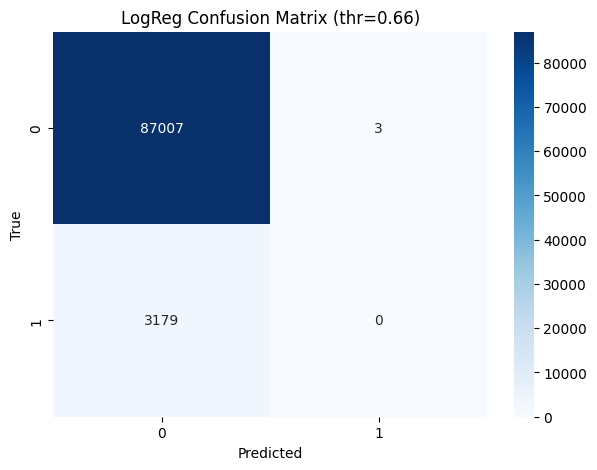

4600

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(
    class_weight="balanced",  # компенсируем перекос
    max_iter=1000,
    solver='saga',  # устойчив к большим наборам
    n_jobs=-1
)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_train, sample_weight=y_train.map({0:1, 1:(y_train.value_counts()[0]/y_train.value_counts()[1])}))

best_lr = grid_lr.best_estimator_
print("Best LogisticRegression params:", grid_lr.best_params_)

# Калибровка (Platt scaling)
cal_lr = CalibratedClassifierCV(best_lr, method='sigmoid', cv=cv)
cal_lr.fit(X_train, y_train)
y_cal_proba = cal_lr.predict_proba(X_test)[:,1]
roc_auc_cal = roc_auc_score(y_test, y_cal_proba)

# Подбор оптимального порога
prec, rec, thr = precision_recall_curve(y_test, y_cal_proba)
f1_scores = 2*prec*rec/(prec+rec)
best_thr = thr[np.argmax(f1_scores)]

final_preds = (y_cal_proba >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()

print(f"Confusion @thr={best_thr:.3f} -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print("ROC-AUC:", roc_auc_cal, "F1:", f1_score(y_test, final_preds))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title(f'LogReg Confusion Matrix (thr={best_thr:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

del grid_lr, cal_lr, best_lr
gc.collect()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RandomForest params: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 400}
Confusion @thr=0.069 -> TP:765 FP:7282 FN:2414 TN:79728
ROC-AUC: 0.6850642680482865 F1: 0.1362907536076964


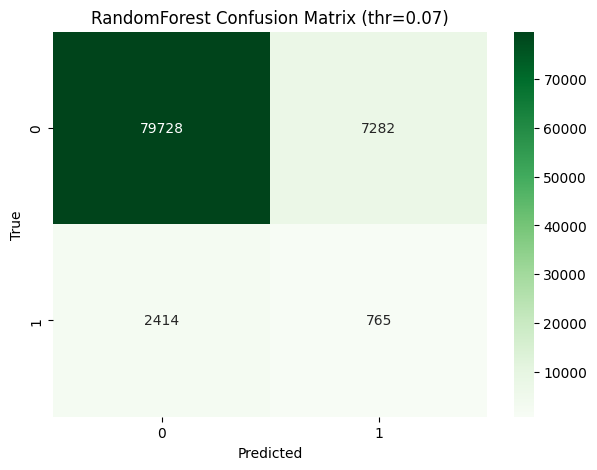

4525

In [ ]:
# Cell X2: Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

param_grid_rf = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best RandomForest params:", grid_rf.best_params_)

# Калибровка
cal_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv=cv)
cal_rf.fit(X_train, y_train)
y_cal_proba = cal_rf.predict_proba(X_test)[:,1]
roc_auc_cal = roc_auc_score(y_test, y_cal_proba)

# Подбор порога
prec, rec, thr = precision_recall_curve(y_test, y_cal_proba)
f1_scores = 2*prec*rec/(prec+rec)
best_thr = thr[np.argmax(f1_scores)]

final_preds = (y_cal_proba >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()

print(f"Confusion @thr={best_thr:.3f} -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print("ROC-AUC:", roc_auc_cal, "F1:", f1_score(y_test, final_preds))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='Greens')
plt.title(f'RandomForest Confusion Matrix (thr={best_thr:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

del grid_rf, cal_rf, best_rf
gc.collect()


### 2.3.2 тюнинг модели через байесовскую оптимизацию


In [ ]:
### постараемся улучшить модель LightGBM, так как она показала лучшие результаты.

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import numpy as np

In [ ]:
# --- Кросс-валидация
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Упрощённое пространство поиска
param_space = {
    'num_leaves': Integer(40, 120),
    'learning_rate': Real(0.01, 0.05, prior='log-uniform'),
    'min_child_samples': Integer(20, 80),
    'feature_fraction': Real(0.7, 1.0),
    'bagging_fraction': Real(0.7, 1.0),
    'n_estimators': Integer(200, 600),
    'reg_alpha': Real(0.0, 0.5),
    'reg_lambda': Real(0.0, 0.5)
}

# --- Базовая модель
base_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=-1
)

# --- Байесовская оптимизация (ускорённая)
opt = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    scoring='roc_auc',
    cv=cv,
    n_iter=20,             # ↓ с 60 до 20 итераций
    n_points=2,            # параллельные итерации
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [ ]:
opt.fit(X_train, y_train, sample_weight=sample_weight)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
              estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                       objective='binary', random_state=42,
                                       verbose=-1),
              n_iter=20, n_jobs=-1, n_points=2, random_state=42,
              scoring='roc_auc',
              search_spaces={'bagging_fraction': Real(low=0.7, high=1.0, prior='uniform', transform='normalize'),
                             'feature_f...
                             'min_child_samples': Integer(low=20, high=80, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=200, high=600, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=40, high=120, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=0.5, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=0.5, prior='uniform', transform='normalize')},
              verbose=1)

In [ ]:
print("Лучшие параметры:", opt.best_params_)
print("Лучшая средняя ROC-AUC (CV):", opt.best_score_)

Лучшие параметры: OrderedDict({'bagging_fraction': 0.7973237793661018, 'feature_fraction': 0.7020057702983197, 'learning_rate': 0.01005248250839521, 'min_child_samples': 47, 'n_estimators': 522, 'num_leaves': 40, 'reg_alpha': 0.17632582980625547, 'reg_lambda': 0.2853459546195048})
Лучшая средняя ROC-AUC (CV): 0.6853196702405934


In [ ]:
# Обучение финальной модели
best_model = opt.best_estimator_
best_model.fit(X_train, y_train, sample_weight=sample_weight)

# Предсказания
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Метрики
roc_auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"ROC-AUC (test): {roc_auc:.4f}")
print(f"Confusion Matrix -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")

ROC-AUC (test): 0.6912
Confusion Matrix -> TP:3163 FP:84817 FN:16 TN:2193


### 2.3.3. тюнинг модели с помощью совмещения Logistic Regression, LightGBM и байесовской оптимизации

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_parquet("/content/drive/My Drive/ML engineer/Final/df_prepared.parquet")
print("Rows:", len(df))
df.head()


Rows: 450945


,rn,pre_loans_credit_limit_mean,pre_loans_next_pay_summ_sum,pre_loans_outstanding_sum,pre_loans_outstanding_mean,pre_loans5_sum,pre_loans530_sum,pre_loans3060_sum,pre_loans6090_sum,pre_loans90_sum,...,pre_over2limit_mode_count,pre_maxover2limit_mode_count,enc_loans_credit_status_mode_count,enc_loans_credit_type_mode,enc_paym_total_mode,enc_paym_value_0,enc_paym_value_1,enc_paym_value_2,enc_paym_value_3,flag
0,3,9,8,11,4,18,48,15,12,24,...,3,2,2,0,0,47,8,0,16,0
1,1,13,2,3,3,6,16,5,4,8,...,1,1,1,3,3,2,0,0,20,0
2,6,11,7,20,3,36,96,30,24,48,...,6,6,4,4,0,67,5,0,65,0
3,15,10,28,44,3,90,240,75,60,120,...,15,15,12,4,0,168,23,0,153,0
4,11,9,27,29,3,60,172,55,44,88,...,11,10,8,4,3,83,49,6,115,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450945 entries, 0 to 450944
Data columns (total 23 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   rn                                  450945 non-null  int64
 1   pre_loans_credit_limit_mean         450945 non-null  int64
 2   pre_loans_next_pay_summ_sum         450945 non-null  int64
 3   pre_loans_outstanding_sum           450945 non-null  int64
 4   pre_loans_outstanding_mean          450945 non-null  int64
 5   pre_loans5_sum                      450945 non-null  int64
 6   pre_loans530_sum                    450945 non-null  int64
 7   pre_loans3060_sum                   450945 non-null  int64
 8   pre_loans6090_sum                   450945 non-null  int64
 9   pre_loans90_sum                     450945 non-null  int64
 10  pre_loan_for_60_days                450945 non-null  int64
 11  pre_util_mode                       450945 non-null 

In [ ]:
df.describe()

,rn,pre_loans_credit_limit_mean,pre_loans_next_pay_summ_sum,pre_loans_outstanding_sum,pre_loans_outstanding_mean,pre_loans5_sum,pre_loans530_sum,pre_loans3060_sum,pre_loans6090_sum,pre_loans90_sum,...,pre_over2limit_mode_count,pre_maxover2limit_mode_count,enc_loans_credit_status_mode_count,enc_loans_credit_type_mode,enc_paym_total_mode,enc_paym_value_0,enc_paym_value_1,enc_paym_value_2,enc_paym_value_3,flag
count,450945.000000,450945.000000,450945.000000,450945.000000,450945.000000,450945.000000,450945.00000,450945.000000,450945.000000,450945.000000,...,450945.000000,450945.000000,450945.000000,450945.000000,450945.000000,450945.00000,450945.000000,450945.000000,450945.000000,450945.000000
mean,8.718150,9.719287,20.603309,26.118806,3.036171,52.086281,138.37682,43.602322,34.871188,69.773706,...,8.139365,7.845618,6.325700,3.538330,1.624471,89.66120,12.517305,0.870131,96.110681,0.035246
std,6.178034,2.921734,14.814783,18.614049,0.440595,36.969481,98.17383,30.895191,24.711895,49.434883,...,5.804058,5.624972,4.870364,0.861231,1.493561,67.91544,13.524543,2.047198,78.797115,0.184401
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,2.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,9.000000,11.000000,3.000000,24.000000,64.00000,20.000000,16.000000,32.000000,...,4.000000,3.000000,3.000000,3.000000,0.000000,35.00000,3.000000,0.000000,39.000000,0.000000
50%,7.000000,10.000000,17.000000,22.000000,3.000000,42.000000,112.00000,35.000000,28.000000,56.000000,...,7.000000,7.000000,5.000000,4.000000,3.000000,75.00000,9.000000,0.000000,76.000000,0.000000
75%,12.000000,11.000000,29.000000,37.000000,3.000000,72.000000,192.00000,60.000000,48.000000,96.000000,...,12.000000,11.000000,9.000000,4.000000,3.000000,130.00000,17.000000,1.000000,132.000000,0.000000
max,46.000000,19.000000,128.000000,142.000000,5.000000,276.000000,720.00000,230.000000,184.000000,368.000000,...,46.000000,44.000000,44.000000,7.000000,3.000000,509.00000,237.000000,47.000000,876.000000,1.000000


In [ ]:
# --- 1. Разделение на признаки и цель
target = "flag"
feature_cols = [c for c in df.columns if c not in (target, "rn")]
X = df[feature_cols].copy()
y = df[target].astype(int)

print("Feature count:", X.shape[1])
print("Positive rate:", y.mean())

Feature count: 21
Positive rate: 0.035245983434786944


In [ ]:
# --- 2. Частотное кодирование категориальных признаков
low_cardinality = [c for c in feature_cols if df[c].nunique() <= 20]
print("Low-cardinality features:", low_cardinality)

for c in low_cardinality:
    freq_map = df[c].value_counts(normalize=True)
    X[c + "_freq"] = X[c].map(freq_map)

Low-cardinality features: ['pre_loans_credit_limit_mean', 'pre_loans_outstanding_mean', 'pre_util_mode', 'enc_loans_credit_type_mode', 'enc_paym_total_mode']


In [ ]:
# --- 3. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 4. Веса классов
w0 = 1.0
w1 = (y_train == 0).sum() / max(1, (y_train == 1).sum())
sample_weight = np.where(y_train == 1, w1, w0)

print(f"Train class balance: {np.mean(y_train):.4f}, weight_1 = {w1:.2f}")

Train class balance: 0.0352, weight_1 = 27.37


In [ ]:
# --- 5. Кросс-валидация
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- 6. Пространство поиска
param_space = {
    'num_leaves': Integer(40, 120),
    'learning_rate': Real(0.01, 0.05, prior='log-uniform'),
    'min_child_samples': Integer(20, 80),
    'feature_fraction': Real(0.7, 1.0),
    'bagging_fraction': Real(0.7, 1.0),
    'n_estimators': Integer(200, 600),
    'reg_alpha': Real(0.0, 0.5),
    'reg_lambda': Real(0.0, 0.5),
    'min_split_gain': Real(0.0, 0.3)
}

# --- 7. Базовая модель
base_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [ ]:
# --- 8. Байесовская оптимизация
opt = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    scoring='roc_auc',
    cv=cv,
    n_iter=25,      # разумный компромисс
    n_points=2,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train, sample_weight=sample_weight)

print("Лучшие параметры:", opt.best_params_)
print(f"Лучшая средняя ROC-AUC (CV): {opt.best_score_:.4f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Лучшие параметры: OrderedDict({'bagging_fraction': 0.7, 'feature_fraction': 0.7, 'learning_rate': 0.0165873347639857, 'min_child_samples': 80, 'min_split_gain': 0.3, 'n_estimators': 415, 'num_leaves': 40, 'reg_alpha': 0.5, 'reg_lambd

In [ ]:
# --- 9. Обучаем лучшую LightGBM модель
best_model = opt.best_estimator_
best_model.fit(X_train, y_train, sample_weight=sample_weight)

# --- 10. Получаем вероятности
train_pred_proba = best_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
test_pred_proba = best_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

# --- 11. Логистическая регрессия как мета-модель
meta_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    )
)

meta_model.fit(train_pred_proba, y_train)

# --- 12. Финальные вероятности
y_prob = meta_model.predict_proba(test_pred_proba)[:, 1]

In [ ]:
# --- 13. Оптимизация порога
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# --- 14. Применяем порог
y_pred_opt = (y_prob >= best_threshold).astype(int)

# --- 15. Метрики
roc_auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()

print(f"ROC-AUC (test): {roc_auc:.4f}")
print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Confusion Matrix -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print(f"Precision: {tp / (tp + fp + 1e-8):.4f} | Recall: {tp / (tp + fn + 1e-8):.4f} | F1: {f1_scores[best_idx]:.4f}")


ROC-AUC (test): 0.6993
Оптимальный порог: 0.7260
Confusion Matrix -> TP:784 FP:6959 FN:2395 TN:80051
Precision: 0.1013 | Recall: 0.2466 | F1: 0.1436


### 2.3.4. оценка

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450945 entries, 0 to 450944
Data columns (total 23 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   rn                                  450945 non-null  int64
 1   pre_loans_credit_limit_mean         450945 non-null  int64
 2   pre_loans_next_pay_summ_sum         450945 non-null  int64
 3   pre_loans_outstanding_sum           450945 non-null  int64
 4   pre_loans_outstanding_mean          450945 non-null  int64
 5   pre_loans5_sum                      450945 non-null  int64
 6   pre_loans530_sum                    450945 non-null  int64
 7   pre_loans3060_sum                   450945 non-null  int64
 8   pre_loans6090_sum                   450945 non-null  int64
 9   pre_loans90_sum                     450945 non-null  int64
 10  pre_loan_for_60_days                450945 non-null  int64
 11  pre_util_mode                       450945 non-null 

In [ ]:
# --- 1. Получаем вероятности класса 1 ---
y_probs = best_model.predict_proba(X_test)[:, 1]

# --- 2. Строим Precision-Recall кривую ---
prec, rec, thr = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-9)

# --- 3. Находим оптимальный порог по F1 ---
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]

print(f"Оптимальный порог по F1: {best_thr:.4f}")
print(f"Precision: {prec[best_idx]:.4f} | Recall: {rec[best_idx]:.4f} | F1: {f1_scores[best_idx]:.4f}")

Оптимальный порог по F1: 0.6665
Precision: 0.1013 | Recall: 0.2466 | F1: 0.1436


In [ ]:
# --- 4. Применяем новый порог ---
y_pred_new = (y_probs >= best_thr).astype(int)

# --- 5. Считаем Confusion Matrix и отчёт ---
cm = confusion_matrix(y_test, y_pred_new)
tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print(classification_report(y_test, y_pred_new, digits=4))


Confusion Matrix -> TP:784 FP:6959 FN:2395 TN:80051
              precision    recall  f1-score   support

           0     0.9710    0.9200    0.9448     87010
           1     0.1013    0.2466    0.1436      3179

    accuracy                         0.8963     90189
   macro avg     0.5361    0.5833    0.5442     90189
weighted avg     0.9403    0.8963    0.9166     90189



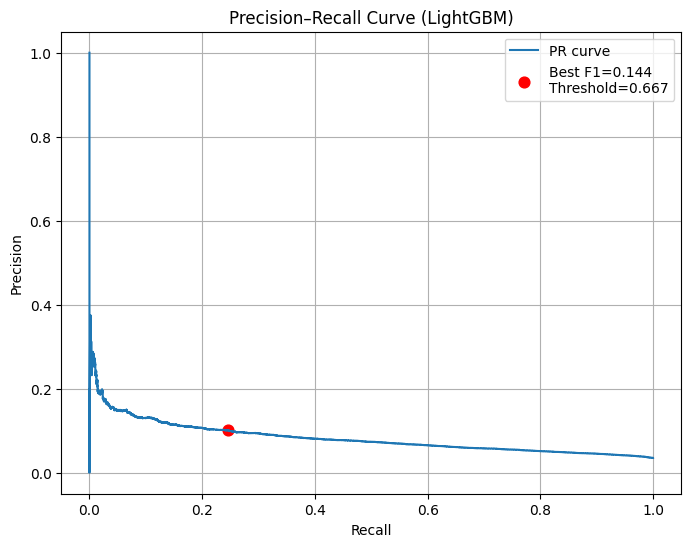

In [ ]:
# --- 6. Визуализация Precision-Recall ---
plt.figure(figsize=(8,6))
plt.plot(rec, prec, label='PR curve')
plt.scatter(rec[best_idx], prec[best_idx], color='red', s=60,
            label=f'Best F1={f1_scores[best_idx]:.3f}\nThreshold={best_thr:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

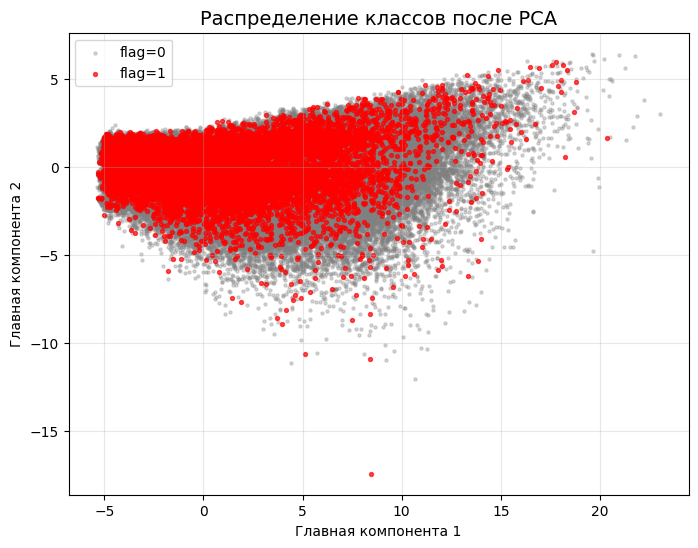

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Берем признаки (все кроме rn и flag)
X = df.drop(columns=["rn", "flag"])
y = df["flag"]

# Стандартизуем (важно для PCA)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# PCA до 2 компонент
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1],
            s=5, alpha=0.3, label="flag=0", color="gray")
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1],
            s=8, alpha=0.7, label="flag=1", color="red")

plt.title("Распределение классов после PCA", fontsize=14)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


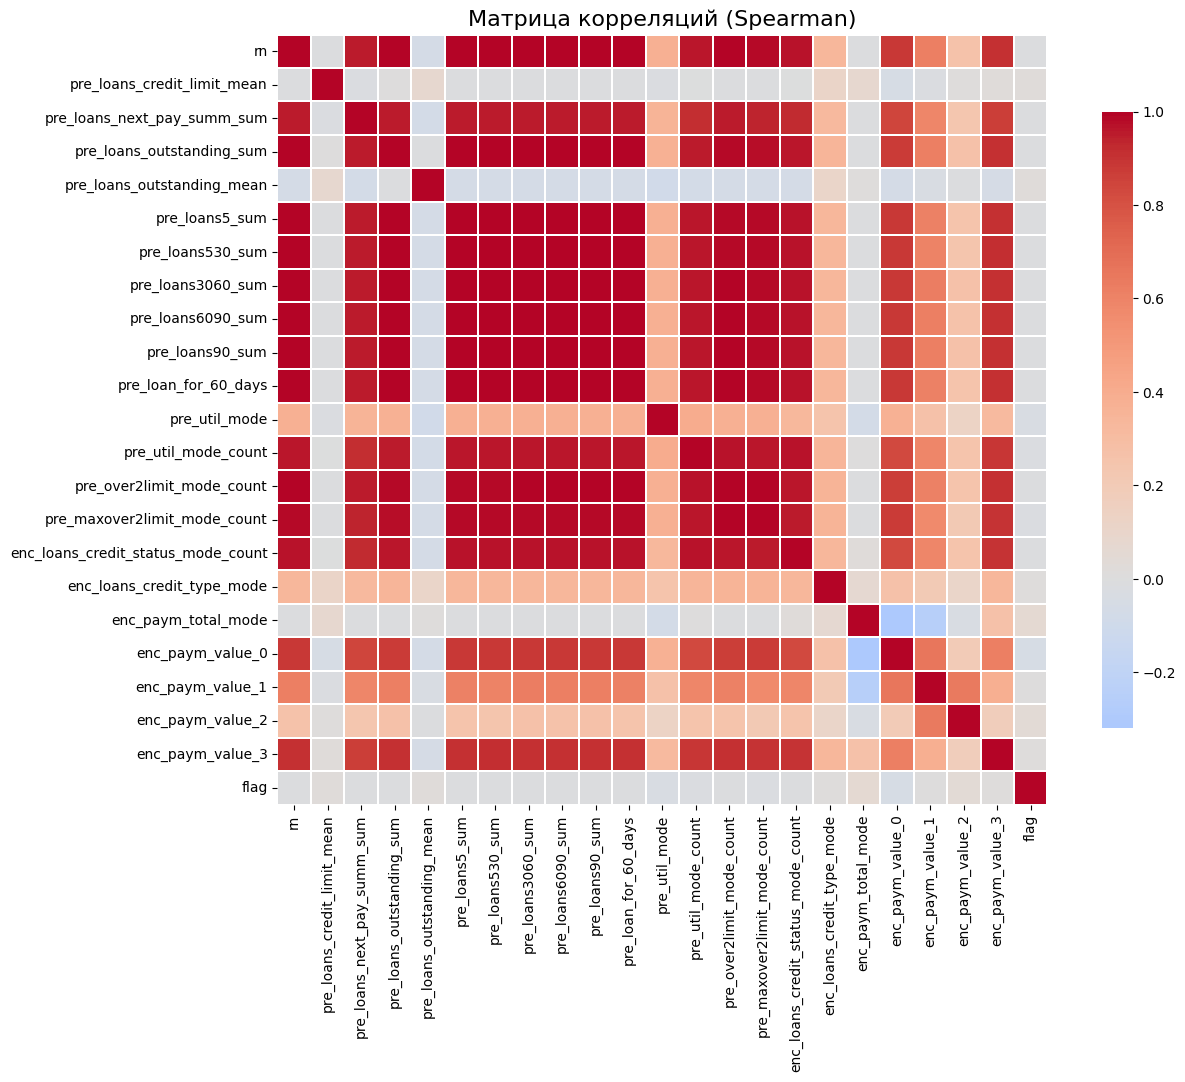

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Вычисляем корреляцию (Spearman более устойчив)
corr = df.corr(method='pearson')

# --- Визуализация
plt.figure(figsize=(14, 10))
sns.heatmap(corr,
            cmap='coolwarm',
            center=0,
            annot=False,
            fmt=".2f",
            square=True,
            cbar_kws={'shrink': .8},
            linewidths=0.1)

plt.title("Матрица корреляций (Spearman)", fontsize=16)
plt.show()


### 2.3.5. тюнинг 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.feature_selection import SelectFromModel

from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [ ]:
# --- 1. Разделение на признаки и цель
target = "flag"
X = df.drop(columns=["rn", target])
y = df[target].astype(int)

print("Feature count:", X.shape[1])
print("Positive rate:", y.mean())

# --- 2. Частотное кодирование категориальных признаков
low_cardinality = [c for c in X.columns if X[c].nunique() <= 20]
print("Low-cardinality features:", low_cardinality)

for c in low_cardinality:
    freq_map = X[c].value_counts(normalize=True)
    X[c + "_freq"] = X[c].map(freq_map)

# --- 3. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Feature count: 21
Positive rate: 0.035245983434786944
Low-cardinality features: ['pre_loans_credit_limit_mean', 'pre_loans_outstanding_mean', 'pre_util_mode', 'enc_loans_credit_type_mode', 'enc_paym_total_mode']


In [ ]:
# --- 4. Веса классов
w0 = 1.0
w1 = (y_train == 0).sum() / max(1, (y_train == 1).sum())
sample_weight = np.where(y_train == 1, w1, w0)
print(f"Train class balance: {np.mean(y_train):.4f}, weight_1 = {w1:.2f}")

Train class balance: 0.0352, weight_1 = 27.37


In [ ]:
# --- 5. Отбор важных признаков
tmp_model = LGBMClassifier(random_state=42, n_jobs=-1)
tmp_model.fit(X_train, y_train, sample_weight=sample_weight)
sfm = SelectFromModel(tmp_model, threshold="median", prefit=True)
X_train_sel = sfm.transform(X_train)
X_test_sel = sfm.transform(X_test)
print(f"Selected features: {X_train_sel.shape[1]} из {X_train.shape[1]}")

# --- 6. Полиномиальные признаки на выделенных
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_sel)
X_test_poly = poly.transform(X_test_sel)
print(f"After poly features: {X_train_poly.shape[1]}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: 13 из 26
After poly features: 91


In [ ]:
# --- 7. Байесовская оптимизация LightGBM
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_space = {
    'num_leaves': Integer(40, 160),
    'max_depth': Integer(4, 12),
    'learning_rate': Real(0.01, 0.05, prior='log-uniform'),
    'min_child_samples': Integer(10, 100),
    'feature_fraction': Real(0.7, 1.0),
    'bagging_fraction': Real(0.7, 1.0),
    'scale_pos_weight': Real(1.0, w1 * 1.5),
    'n_estimators': Integer(300, 700),
    'reg_alpha': Real(0.0, 0.8),
    'reg_lambda': Real(0.0, 0.8),
    'min_split_gain': Real(0.0, 0.5)
}

base_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

opt = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    scoring='roc_auc',
    cv=cv,
    n_iter=40,  # увеличим итерации для поиска
    n_points=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train_poly, y_train, sample_weight=sample_weight)
print("Лучшие параметры:", opt.best_params_)
print(f"Лучшая средняя ROC-AUC (CV): {opt.best_score_:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Лучшие параметры: OrderedDict({'bagging_fraction': 1.0, 'feature_fraction': 0.7, 'learning_rate': 0.01, 'max_depth': 12, 'min_child_samples': 100, 'min_split_gain': 0.5, 'n_estimators': 577, 'num_leaves': 40, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'scale_pos_weight': 1.0})
Лучшая средняя ROC-AUC (CV): 0.6942


In [ ]:
# --- 8. Финальная модель
best_model = opt.best_estimator_
best_model.fit(X_train_poly, y_train, sample_weight=sample_weight)

# --- 9. Метамодель (логистическая регрессия)
train_pred_proba = best_model.predict_proba(X_train_poly)[:, 1].reshape(-1, 1)
test_pred_proba = best_model.predict_proba(X_test_poly)[:, 1].reshape(-1, 1)

meta_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    )
)

meta_model.fit(train_pred_proba, y_train)
y_prob = meta_model.predict_proba(test_pred_proba)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# --- 10. Оптимизация порога
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# --- 11. Итоговые метрики
y_pred_opt = (y_prob >= best_threshold).astype(int)
roc_auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()

print(f"ROC-AUC (test): {roc_auc:.4f}")
print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Confusion Matrix -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print(f"Precision: {tp / (tp + fp + 1e-8):.4f} | Recall: {tp / (tp + fn + 1e-8):.4f} | F1: {f1_scores[best_idx]:.4f}")

ROC-AUC (test): 0.6968
Оптимальный порог: 0.7167
Confusion Matrix -> TP:879 FP:8322 FN:2300 TN:78688
Precision: 0.0955 | Recall: 0.2765 | F1: 0.1420


## 2.4. Инжениринг признаков 2

Наша модель смогла сделать 0,69 ROC-AUC, с такими показателями: Confusion Matrix -> TP:879 FP:8322 FN:2300 TN:78688
Precision: 0.0955 | Recall: 0.2765 | F1: 0.1420. Сама модель неплоха, нужно еще больше перевести FN в TP. Для этого попробуем больше поработать с фичами.

### 2.4.1. создаем сессию

In [ ]:
import pandas as pd
import os
import numpy as np
import math

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [ ]:
spark = (SparkSession.builder
    .appName("SynapseML-LightGBM")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.1")
    .getOrCreate())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/ML engineer/Final/train_target.csv"

df_target = spark.read.option("delimiter", ",").csv(file_path, header=True, inferSchema=True)

In [ ]:
df_sample = df_target.sample(withReplacement=False, fraction=0.15, seed=42)
print('Sample size:', df_sample.count())

Sample size: 450945


In [ ]:
#собираем датафрейм для анализа из файлов parquet
from pyspark.sql import functions as F

ids_with_flag = F.broadcast(df_sample.select("id", "flag"))

pq_files = [
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_0.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_1.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_2.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_3.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_4.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_5.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_6.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_7.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_8.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_9.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_10.pq",
    "/content/drive/My Drive/ML engineer/Final/train_data/train_data_11.pq"
]

df_all = spark.read.parquet(*pq_files)

df_joined = df_all.join(ids_with_flag, on="id", how="inner")

print("Final count:", df_joined.count())
print("Columns:", df_joined.columns)

Final count: 3931406
Columns: ['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_typ

In [ ]:
pandas_df = df_joined.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Проверим, что всё ок:
print(pandas_df.shape)
pandas_df.head()

(393271, 62)


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,2750007,8,13,16,0,7,12,2,14,2,...,0,0,1,1,3,3,1,0,0,0
1,2750007,17,5,17,2,10,15,14,14,2,...,3,3,4,1,3,4,1,0,0,0
2,2750007,19,17,17,12,15,15,14,7,2,...,3,3,4,1,3,4,1,0,0,0
3,2750021,15,7,9,4,8,1,11,1,1,...,3,3,4,1,2,3,1,1,1,0
4,2750027,6,11,0,11,0,8,14,7,2,...,3,3,4,1,3,4,1,0,0,0


In [ ]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393271 entries, 0 to 393270
Data columns (total 72 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             393271 non-null  int64  
 1   rn                             393271 non-null  int64  
 2   pre_since_opened               393271 non-null  int64  
 3   pre_since_confirmed            393271 non-null  int64  
 4   pre_pterm                      393271 non-null  int64  
 5   pre_fterm                      393271 non-null  int64  
 6   pre_till_pclose                393271 non-null  int64  
 7   pre_till_fclose                393271 non-null  int64  
 8   pre_loans_credit_limit         393271 non-null  int64  
 9   pre_loans_next_pay_summ        393271 non-null  int64  
 10  pre_loans_outstanding          393271 non-null  int64  
 11  pre_loans_total_overdue        393271 non-null  int64  
 12  pre_loans_max_overdue_sum     

In [ ]:
pandas_df.describe()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
count,3.932710e+05,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,...,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000,393271.000000
mean,1.546078e+06,7.039416,9.362046,8.228471,8.368235,8.320410,7.139535,8.363660,9.676689,2.364110,...,2.348574,2.382454,3.532470,1.033354,2.694046,3.520089,1.001752,0.148862,0.228062,0.033793
std,8.680686e+05,5.396556,5.780339,4.707177,5.322042,4.481337,5.151501,4.225878,5.823134,1.311444,...,1.224615,1.201361,1.078236,0.301080,0.499028,1.037665,0.048414,0.355953,0.419583,0.180697
min,4.800000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.954770e+05,3.000000,4.000000,4.000000,4.000000,6.000000,2.000000,5.000000,5.000000,2.000000,...,3.000000,3.000000,4.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,1.565728e+06,6.000000,9.000000,9.000000,8.000000,8.000000,7.000000,10.000000,10.000000,2.000000,...,3.000000,3.000000,4.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.000000
75%,2.305494e+06,10.000000,14.000000,12.000000,14.000000,12.000000,12.000000,11.000000,15.000000,2.000000,...,3.000000,3.000000,4.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.000000
max,2.999999e+06,43.000000,19.000000,17.000000,17.000000,16.000000,16.000000,15.000000,19.000000,6.000000,...,3.000000,3.000000,4.000000,6.000000,6.000000,7.000000,3.000000,1.000000,1.000000,1.000000


In [ ]:
pd.set_option("display.max_rows", None)
print(pandas_df.nunique())

id                               237128
rn                                   43
pre_since_opened                     20
pre_since_confirmed                  18
pre_pterm                            18
pre_fterm                            17
pre_till_pclose                      17
pre_till_fclose                      16
pre_loans_credit_limit               20
pre_loans_next_pay_summ               7
pre_loans_outstanding                 5
pre_loans_total_overdue               1
pre_loans_max_overdue_sum             3
pre_loans_credit_cost_rate           13
pre_loans5                            9
pre_loans530                         13
pre_loans3060                         7
pre_loans6090                         2
pre_loans90                           6
is_zero_loans5                        2
is_zero_loans530                      2
is_zero_loans3060                     2
is_zero_loans6090                     2
is_zero_loans90                       2
pre_util                             20


In [ ]:
pd.set_option('display.max_rows', None)

print(pandas)

Мы перевели датафрейм в pandas, и выделели маленькую выборку, чтобы лучше исследовать данные. Сфокусируемся на агрегации признаков по id, как и раньше. Но в этот раз mean, std, min, max, sum, median, iqr сделаем по признакам enc_paym_{0..N}, pre_loans_credit_limit, pre_loans_next_pay_summ, pre_loans_outstanding, pre_util, pre_over2limit, pre_maxover2limit. Для бинарных (где значения 0 и 1) сделаем mean - что покажет нам долю флагов. Также в отдельных признаках можно посчитать энтропию, что покажет, насколько разнообразны были значения. Также постараемся посмотреть соотношеня некоторых признаков, особенно тех, которые касаются времени открытия \ закрытия кредита, а также соотношения сумм остатков, просрочек и лимитов. Можно подумать над созданием бинарных признаков, которые будут отражать состояние кредита: закрыт ли он раньше, чем планировалось, насколько это новый кредит и т.д.

### 2.4.2. сборка нового датафрейма

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats


In [ ]:
# --- 1. Базовые соотношения
pandas_df["ratio_overdue_to_limit"] = pandas_df["pre_loans_total_overdue"] / (pandas_df["pre_loans_credit_limit"] + 1e-8)

pandas_df["ratio_outstanding_to_limit"] = pandas_df["pre_loans_outstanding"] / (pandas_df["pre_loans_credit_limit"] + 1e-8)

pandas_df["ratio_util_to_over2limit"] = pandas_df["pre_util"] / (pandas_df["pre_over2limit"] + 1e-8)

pandas_df["ratio_fterm_to_pterm"] = pandas_df["pre_fterm"] / (pandas_df["pre_pterm"] + 1e-8)

pandas_df["ratio_confirmed_to_opened"] = pandas_df["pre_since_confirmed"] / (pandas_df["pre_since_opened"] + 1e-8)

pandas_df["ratio_rn_to_pterm"] = pandas_df["rn"] / (pandas_df["pre_pterm"] + 1e-8)

In [ ]:
# --- 2. Просрочки
pandas_df["has_overdue"] = (pandas_df["pre_loans_total_overdue"] > 0).astype(int)

# --- 3. Флаги и категории
flag_cols = [c for c in pandas_df.columns if c.startswith("is_zero_")]

cat_cols = [c for c in pandas_df.columns if c.startswith("enc_") and not c.startswith("enc_paym_")]

In [ ]:
# Все колонки с историей платежей
paym_cols = [c for c in pandas_df.columns if c.startswith("enc_paym_")]

# Средний статус (чем выше — тем хуже)
pandas_df["paym_mean"] = pandas_df[paym_cols].mean(axis=1)

# Мода — наиболее частое значение
pandas_df["paym_mode"] = pandas_df[paym_cols].mode(axis=1)[0]

# Кол-во отклонений от моды
pandas_df["paym_deviation_count"] = (pandas_df[paym_cols].ne(pandas_df["paym_mode"], axis=0)).sum(axis=1)

In [ ]:
# --- 5. Базовые числовые признаки
num_cols = [
    "pre_loans_credit_limit", "pre_loans_outstanding", "pre_util",
    "pre_loans_total_overdue", "pre_over2limit", "pre_maxover2limit"
] + [
    "ratio_overdue_to_limit", "ratio_outstanding_to_limit",
    "ratio_util_to_over2limit", "ratio_fterm_to_pterm",
    "ratio_confirmed_to_opened", "ratio_rn_to_pterm",
    "paym_mean", "paym_deviation_count"
]

# --- 6. Определяем функции агрегации
agg_funcs = {col: ["mean", "std", "min", "max"] for col in num_cols}
agg_funcs.update({c: ["mean"] for c in flag_cols})
agg_funcs.update({"has_overdue": ["mean", "max"], "flag": ["max"]})  # добавили флаг

# --- 7. Категориальные признаки: разнообразие и энтропия
agg_cats = pandas_df.groupby("id")[cat_cols].agg(
    ["nunique", lambda x: stats.entropy(pd.Series(x).value_counts(normalize=True))]
)
agg_cats.columns = [f"{c[0]}_{c[1]}" for c in agg_cats.columns]
agg_cats.reset_index(inplace=True)

# --- 8. Основная агрегация
df_client = pandas_df.groupby("id").agg(agg_funcs)
df_client.columns = ["_".join(col).strip() for col in df_client.columns.values]
df_client.reset_index(inplace=True)

# --- 9. Объединяем категориальные агрегаты
df_client = df_client.merge(agg_cats, on="id", how="left")

In [ ]:
# --- 10. Коэффициенты вариации
for col in num_cols:
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    if mean_col in df_client.columns and std_col in df_client.columns:
        df_client[f"{col}_cv"] = df_client[std_col] / (df_client[mean_col] + 1e-8)

# --- 11. Количество нулей / ненулей
for col in num_cols:
    zero_ratio = pandas_df.groupby("id")[col].apply(lambda x: (x == 0).mean())
    df_client = df_client.merge(
        zero_ratio.rename(f"{col}_zero_ratio"),
        on="id",
        how="left"
    )

# --- 12. Проверяем результат
print("Размерность df_client:", df_client.shape)
print(df_client.head())

Размерность df_client: (237128, 104)
   id  pre_loans_credit_limit_mean  pre_loans_credit_limit_std  \
0  48                          6.0                         NaN   
1  50                         12.0                         NaN   
2  58                         17.0                         NaN   
3  63                          2.0                         NaN   
4  88                          8.0                         NaN   

   pre_loans_credit_limit_min  pre_loans_credit_limit_max  \
0                           6                           6   
1                          12                          12   
2                          17                          17   
3                           2                           2   
4                           8                           8   

   pre_loans_outstanding_mean  pre_loans_outstanding_std  \
0                         3.0                        NaN   
1                         3.0                        NaN   
2                  

In [ ]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# 1. Определяем числовые признаки
num_cols = df_client.select_dtypes(include=[np.number]).columns

# 2. Создаем имутер
num_imputer = SimpleImputer(strategy='median')

# 3. Заполняем пропуски
df_client[num_cols] = num_imputer.fit_transform(df_client[num_cols])

# 4. Проверяем
print("Осталось пропусков:", df_client.isna().sum().sum())


Осталось пропусков: 0


In [ ]:
save_path = "/content/drive/My Drive/ML engineer/Final/processed_features.csv"
df_client.to_csv(save_path, index=False)
print(f"Файл сохранен: {save_path}")

Файл сохранен: /content/drive/My Drive/ML engineer/Final/processed_features.csv


In [ ]:
df_client = pd.read_csv("/content/drive/My Drive/ML engineer/Final/processed_features.csv")

df_client.head(10)

,id,pre_loans_credit_limit_mean,pre_loans_credit_limit_std,pre_loans_credit_limit_min,pre_loans_credit_limit_max,pre_loans_outstanding_mean,pre_loans_outstanding_std,pre_loans_outstanding_min,pre_loans_outstanding_max,pre_util_mean,...,pre_over2limit_zero_ratio,pre_maxover2limit_zero_ratio,ratio_overdue_to_limit_zero_ratio,ratio_outstanding_to_limit_zero_ratio,ratio_util_to_over2limit_zero_ratio,ratio_fterm_to_pterm_zero_ratio,ratio_confirmed_to_opened_zero_ratio,ratio_rn_to_pterm_zero_ratio,paym_mean_zero_ratio,paym_deviation_count_zero_ratio
0,48,6.0,NaN,6,6,3.0,NaN,3,3,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50,12.0,NaN,12,12,3.0,NaN,3,3,16.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58,17.0,NaN,17,17,2.0,NaN,2,2,11.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,63,2.0,NaN,2,2,3.0,NaN,3,3,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,88,8.0,NaN,8,8,5.0,NaN,5,5,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,103,7.0,NaN,7,7,3.0,NaN,3,3,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,106,0.0,NaN,0,0,3.0,NaN,3,3,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,109,10.0,NaN,10,10,3.0,NaN,3,3,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,122,5.0,NaN,5,5,3.0,NaN,3,3,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,130,7.5,10.606602,0,15,2.0,1.414214,1,3,13.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pd.set_option("display.max_rows", None)
print(df_client.info(103))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237128 entries, 0 to 237127
Data columns (total 104 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    id                                        float64
 1    pre_loans_credit_limit_mean               float64
 2    pre_loans_credit_limit_std                float64
 3    pre_loans_credit_limit_min                float64
 4    pre_loans_credit_limit_max                float64
 5    pre_loans_outstanding_mean                float64
 6    pre_loans_outstanding_std                 float64
 7    pre_loans_outstanding_min                 float64
 8    pre_loans_outstanding_max                 float64
 9    pre_util_mean                             float64
 10   pre_util_std                              float64
 11   pre_util_min                              float64
 12   pre_util_max                              float64
 13   pre_loans_total_overdue_mean              

In [ ]:
df_client.describe()

,id,pre_loans_credit_limit_mean,pre_loans_credit_limit_std,pre_loans_credit_limit_min,pre_loans_credit_limit_max,pre_loans_outstanding_mean,pre_loans_outstanding_std,pre_loans_outstanding_min,pre_loans_outstanding_max,pre_util_mean,...,pre_over2limit,pre_maxover2limit,ratio_overdue_to_limit,ratio_outstanding_to_limit,ratio_util_to_over2limit,ratio_fterm_to_pterm,ratio_confirmed_to_opened,ratio_rn_to_pterm,paym_mean,paym_deviation_count
count,2.371280e+05,237128.000000,100156.000000,237128.000000,237128.000000,237128.000000,100156.000000,237128.000000,237128.000000,237128.000000,...,237128.000000,237128.000000,237128.0,237128.0,237128.000000,237128.000000,237128.000000,237128.0,237128.0,237128.0
mean,1.527137e+06,9.658167,4.857644,7.949521,11.349663,2.996018,0.392780,2.861788,3.128842,13.707293,...,0.000052,0.006190,1.0,0.0,0.011339,0.061104,0.045506,0.0,0.0,0.0
std,8.674593e+05,5.079453,3.060987,5.719836,5.647378,0.651546,0.560979,0.751164,0.743499,3.989333,...,0.006391,0.068393,0.0,0.0,0.094793,0.208541,0.182657,0.0,0.0,0.0
min,4.800000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,7.765242e+05,6.000000,2.121320,3.000000,7.000000,3.000000,0.000000,3.000000,3.000000,12.333333,...,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,1.539637e+06,10.000000,4.898979,7.000000,13.000000,3.000000,0.000000,3.000000,3.000000,16.000000,...,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,2.284124e+06,14.000000,7.071068,13.000000,16.000000,3.000000,0.707107,3.000000,3.000000,16.000000,...,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,2.999999e+06,19.000000,13.435029,19.000000,19.000000,5.000000,2.828427,5.000000,5.000000,19.000000,...,1.000000,1.000000,1.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,0.0


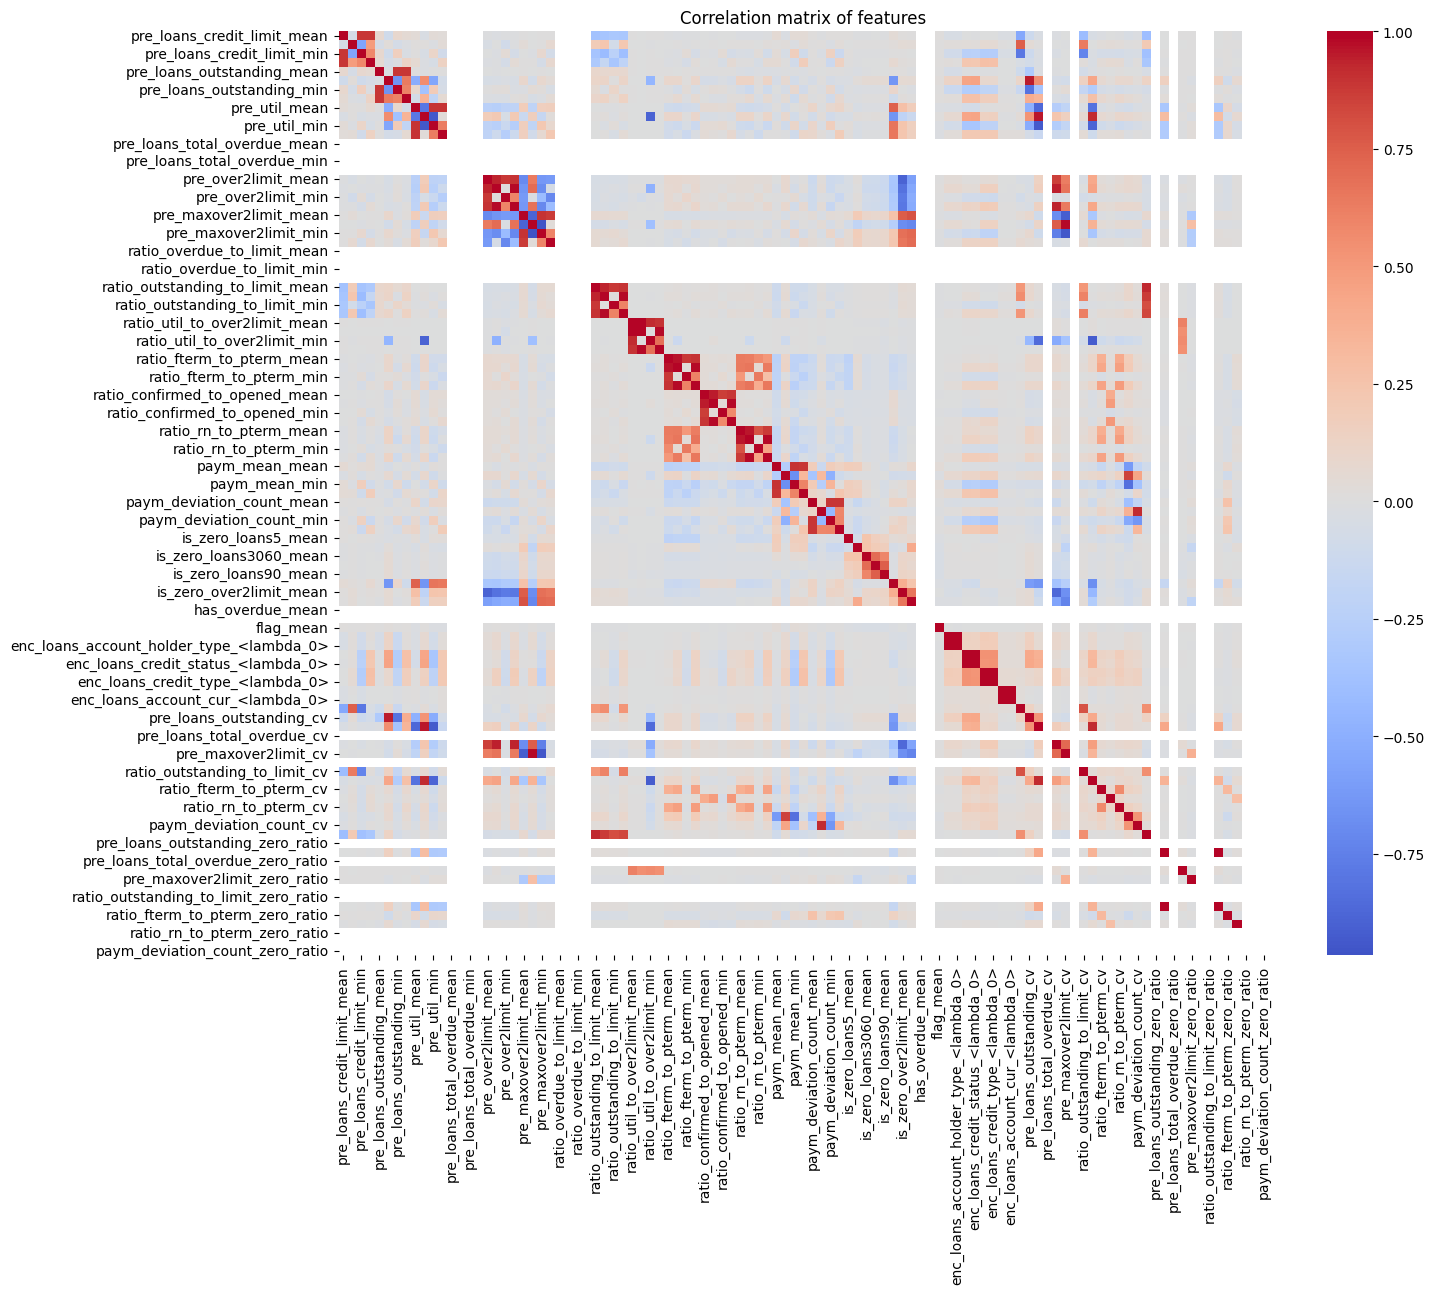

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Убираем идентификатор
features_df = df_client.drop(columns=["id"])

# Вычисляем корреляцию Пирсона
corr_matrix = features_df.corr(method='pearson')

# Визуализируем
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation matrix of features")
plt.show()


In [ ]:
# Корреляция признаков с целевой переменной
features_df = df_client.drop(columns=["id"])

corr_with_flag = features_df.corr(method='pearson')["flag_max"].drop("flag_max")

# Сортируем по абсолютному значению корреляции, в порядке убывания
top_30_features = corr_with_flag.abs().sort_values(ascending=False).head(30)

print(top_30_features)


is_zero_loans3060_mean             0.040666
is_zero_loans6090_mean             0.039256
is_zero_loans90_mean               0.038900
paym_mean_mean                     0.035186
paym_mean_min                      0.034437
is_zero_loans530_mean              0.033088
paym_mean_max                      0.028047
paym_mean_cv                       0.019030
is_zero_util_mean                  0.019008
pre_util_mean                      0.018329
pre_util_min                       0.018066
is_zero_loans5_mean                0.015221
pre_util_max                       0.015008
is_zero_maxover2limit_mean         0.014350
paym_mean_std                      0.013369
ratio_outstanding_to_limit_max     0.012262
pre_loans_outstanding_max          0.012169
ratio_outstanding_to_limit_mean    0.011902
pre_maxover2limit_min              0.010458
pre_loans_credit_limit_mean        0.010167
pre_maxover2limit_mean             0.010082
pre_loans_outstanding_std          0.009628
pre_loans_credit_limit_max      

### 2.4.3. тестируем модель с новыми признаками

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

# Цель и признаки
target = "flag_max"
X = df_client.drop(columns=["id", target])
y = (df_client[target] >= 0.5).astype(int)  # бинаризация флага риска

# --- Отбор признаков по корреляции
corr_with_flag = X.corrwith(df_client[target])
selected_features = corr_with_flag[abs(corr_with_flag) > 0.01].index.tolist()
X = X[selected_features]

print("Feature count after correlation filter:", X.shape[1])
print("Positive rate:", y.mean())


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Feature count after correlation filter: 21
Positive rate: 0.033762356195809855


In [ ]:
low_cardinality = [c for c in X.columns if X[c].nunique() <= 20]
print("Low-cardinality features:", low_cardinality)

for c in low_cardinality:
    freq_map = X[c].value_counts(normalize=True)
    X[c + "_freq"] = X[c].map(freq_map)


Low-cardinality features: ['pre_loans_outstanding_max', 'pre_util_min', 'pre_util_max', 'pre_maxover2limit_min', 'is_zero_loans5_mean', 'is_zero_loans3060_mean', 'is_zero_loans6090_mean', 'is_zero_loans90_mean']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
w0 = 1.0
w1 = (y_train == 0).sum() / max(1, (y_train == 1).sum())
sample_weight = np.where(y_train == 1, w1, w0)
print(f"Train class balance: {np.mean(y_train):.4f}, weight_1 = {w1:.2f}")


Train class balance: 0.0338, weight_1 = 28.62


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel

tmp_model = LGBMClassifier(random_state=42, n_jobs=-1)
tmp_model.fit(X_train, y_train, sample_weight=sample_weight)

sfm = SelectFromModel(tmp_model, threshold="median", prefit=True)
X_train_sel = sfm.transform(X_train)
X_test_sel = sfm.transform(X_test)

print(f"Selected features: {X_train_sel.shape[1]} из {X_train.shape[1]}")


Selected features: 15 из 29


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_sel)
X_test_poly = poly.transform(X_test_sel)

print(f"After poly features: {X_train_poly.shape[1]}")


After poly features: 120


In [ ]:
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_space = {
    'num_leaves': Integer(40, 160),
    'max_depth': Integer(4, 12),
    'learning_rate': Real(0.01, 0.05, prior='log-uniform'),
    'min_child_samples': Integer(10, 100),
    'feature_fraction': Real(0.7, 1.0),
    'bagging_fraction': Real(0.7, 1.0),
    'scale_pos_weight': Real(1.0, w1 * 1.5),
    'n_estimators': Integer(300, 700),
    'reg_alpha': Real(0.0, 0.8),
    'reg_lambda': Real(0.0, 0.8),
    'min_split_gain': Real(0.0, 0.5)
}

base_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

opt = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    scoring='roc_auc',
    cv=cv,
    n_iter=40,
    n_points=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train_poly, y_train, sample_weight=sample_weight)
print("Лучшие параметры:", opt.best_params_)
print(f"Лучшая средняя ROC-AUC (CV): {opt.best_score_:.4f}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Лучшие параметры: OrderedDict({'bagging_fraction': 0.7, 'feature_fraction': 0.7, 'learning_rate': 0.01627881618008333, 'max_depth': 4, 'min_child_samples': 63, 'min_split_gain': 0.0, 'n_estimators': 300, 'num_leaves': 40, 'reg_alpha': 0.8, 'reg_lambda': 0.8, 'scale_pos_weight': 1.0})
Лучшая средняя ROC-AUC (CV): 0.6173


In [ ]:
best_model = opt.best_estimator_
best_model.fit(X_train_poly, y_train, sample_weight=sample_weight)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier(bagging_fraction=0.7, feature_fraction=0.7,
               learning_rate=0.01627881618008333, max_depth=4,
               min_child_samples=63, n_estimators=300, num_leaves=40,
               objective='binary', random_state=42, reg_alpha=0.8,
               reg_lambda=0.8, scale_pos_weight=1.0, verbose=-1)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# --- Предсказания LightGBM для метамодели
train_pred_proba = best_model.predict_proba(X_train_poly)[:, 1].reshape(-1, 1)
test_pred_proba = best_model.predict_proba(X_test_poly)[:, 1].reshape(-1, 1)

# --- Нормализация выходов бустинга перед логистической регрессией
from sklearn.preprocessing import StandardScaler

scaler_meta = StandardScaler()
train_pred_scaled = scaler_meta.fit_transform(train_pred_proba)
test_pred_scaled = scaler_meta.transform(test_pred_proba)

# --- Мета-модель (логрег)
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

meta_model.fit(train_pred_scaled, y_train)
y_prob = meta_model.predict_proba(test_pred_scaled)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix
import numpy as np

# --- Метрики для метамодели
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Защита от деления на ноль
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Индекс наилучшего порога по F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # fallback на случай пустоты

# Прогноз с оптимальным порогом
y_pred_opt = (y_prob >= best_threshold).astype(int)

# --- ROC-AUC и confusion matrix
roc_auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()

# --- Вывод
print(f"ROC-AUC (test): {roc_auc:.4f}")
print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Confusion Matrix -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print(
    f"Precision: {tp / (tp + fp + 1e-8):.4f} | "
    f"Recall: {tp / (tp + fn + 1e-8):.4f} | "
    f"F1: {f1_scores[best_idx]:.4f}"
)


ROC-AUC (test): 0.6145
Оптимальный порог: 0.6362
Confusion Matrix -> TP:378 FP:5593 FN:1223 TN:40232
Precision: 0.0633 | Recall: 0.2361 | F1: 0.0998


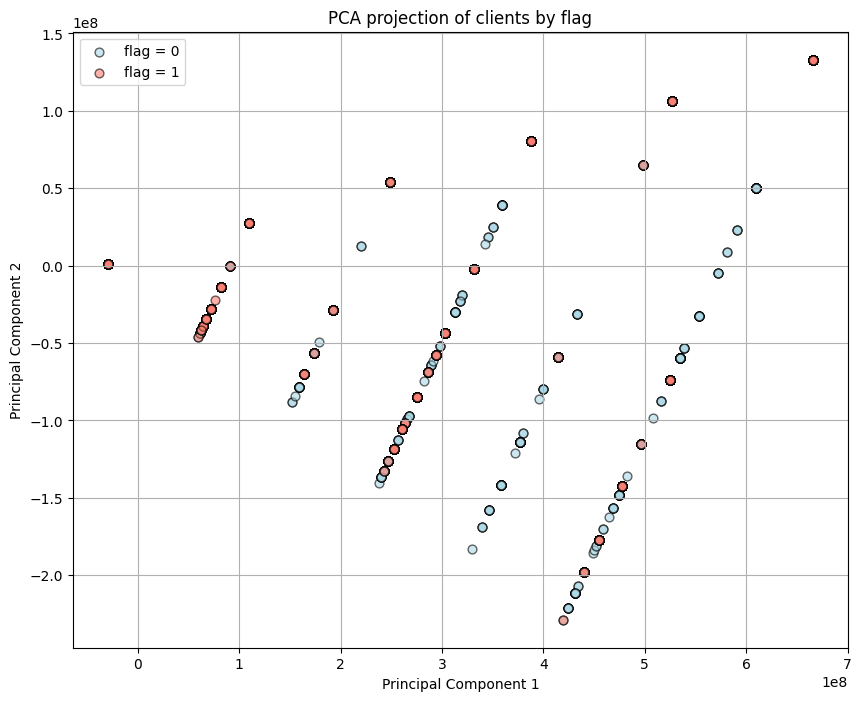

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["flag"] = y.values

plt.figure(figsize=(10, 8))
plt.scatter(df_plot[df_plot["flag"] == 0]["PC1"],
            df_plot[df_plot["flag"] == 0]["PC2"],
            c="lightblue", label="flag = 0", s=40, alpha=0.6, edgecolor="k")
plt.scatter(df_plot[df_plot["flag"] == 1]["PC1"],
            df_plot[df_plot["flag"] == 1]["PC2"],
            c="salmon", label="flag = 1", s=40, alpha=0.6, edgecolor="k")

plt.title("PCA projection of clients by flag")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


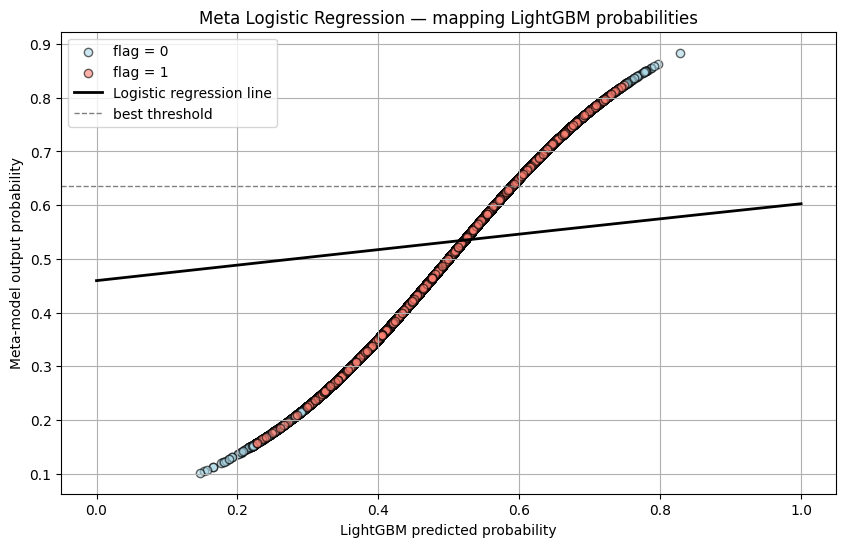

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Предсказания LightGBM и метамодели
x_vals = test_pred_proba.ravel()  # вероятность LightGBM
y_true = y_test.values             # фактические метки
y_meta = y_prob                    # вероятность после логистики

# Для плавной линии модели
x_grid = np.linspace(0, 1, 500).reshape(-1, 1)
y_grid = meta_model.predict_proba(x_grid)[:, 1]

plt.figure(figsize=(10, 6))

# Точки клиентов
plt.scatter(x_vals[y_true == 0], y_meta[y_true == 0],
            color='lightblue', alpha=0.6, edgecolor='k', label='flag = 0')
plt.scatter(x_vals[y_true == 1], y_meta[y_true == 1],
            color='salmon', alpha=0.6, edgecolor='k', label='flag = 1')

# Линия логистической модели
plt.plot(x_grid, y_grid, color='black', linewidth=2, label='Logistic regression line')

# Порог
plt.axhline(best_threshold, color='gray', linestyle='--', linewidth=1, label='best threshold')

plt.title("Meta Logistic Regression — mapping LightGBM probabilities")
plt.xlabel("LightGBM predicted probability")
plt.ylabel("Meta-model output probability")
plt.legend()
plt.grid(True)
plt.show()


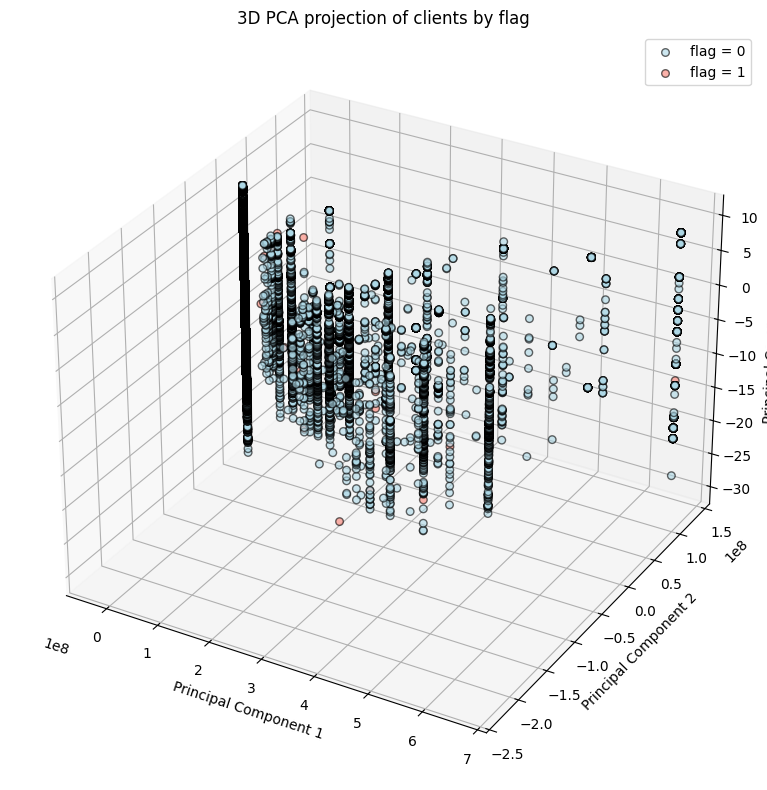

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # активирует 3D-проекции
import pandas as pd

# --- PCA до 3 компонент
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

# --- Подготовка DataFrame
df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_plot["flag"] = y.values

# --- Создание 3D-графика
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Точки
ax.scatter(
    df_plot.loc[df_plot["flag"] == 0, "PC1"],
    df_plot.loc[df_plot["flag"] == 0, "PC2"],
    df_plot.loc[df_plot["flag"] == 0, "PC3"],
    c="lightblue", label="flag = 0", s=30, alpha=0.6, edgecolor="k"
)
ax.scatter(
    df_plot.loc[df_plot["flag"] == 1, "PC1"],
    df_plot.loc[df_plot["flag"] == 1, "PC2"],
    df_plot.loc[df_plot["flag"] == 1, "PC3"],
    c="salmon", label="flag = 1", s=30, alpha=0.6, edgecolor="k"
)

# Оформление
ax.set_title("3D PCA projection of clients by flag")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix

# --- 1. Подготовка данных
target = "flag_max"
X = df_client.drop(columns=["id", target])
y = (df_client[target] >= 0.5).astype(int)

# --- 2. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. Балансировка весов
w0 = 1.0
w1 = (y_train == 0).sum() / max(1, (y_train == 1).sum())
sample_weight = np.where(y_train == 1, w1, w0)
print(f"Train class balance: {np.mean(y_train):.4f}, weight_1 = {w1:.2f}")

# --- 4. Модель LightGBM
model = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    bagging_fraction=0.7,
    feature_fraction=0.7,
    learning_rate=0.0165873347639857,
    min_child_samples=80,
    min_split_gain=0.3,
    n_estimators=415,
    num_leaves=40,
    reg_alpha=0.5,
    reg_lambda=0.5
)

# --- 5. Обучение
model.fit(X_train, y_train, sample_weight=sample_weight)

# --- 6. Предсказания
y_prob = model.predict_proba(X_test)[:, 1]

# --- 7. Оптимизация порога по F1
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

y_pred_opt = (y_prob >= best_threshold).astype(int)

# --- 8. Метрики
roc_auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()

print(f"ROC-AUC (test): {roc_auc:.4f}")
print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Confusion Matrix -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print(f"Precision: {tp / (tp + fp + 1e-8):.4f} | Recall: {tp / (tp + fn + 1e-8):.4f} | F1: {f1_scores[best_idx]:.4f}")


Train class balance: 0.0338, weight_1 = 28.62
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
ROC-AUC (test): 0.6193
Оптимальный порог: 0.5960
Confusion Matrix -> TP:336 FP:4291 FN:1265 TN:41534
Precision: 0.0726 | Recall: 0.2099 | F1: 0.1079


## 2.5. Комбинированная модель

Итак, мы поняли, что новая модель инжиниринга данных, в которых мы вычисляли соотношение признаков между собой не показала результата, несмотря на разные модели машинного обучения, котоыре мы применяли. При этом совмещенная модель LightGBM, LogisticRegression и байесовской оптимизации имеет свой потенциал. Эта модель лучше дифференцирует TN и TP.  Необходимо вернутся к старой модели инжениринга данных, в которой мы агрегировали по id, общие значения для enc_paym_*. Таким образом мы постараемся совместить положительные стороны обеих моделей и обучить модель уже на всех данных, а не только на выборке.


### 2.5.1 создаем сессию

In [ ]:
!pip install synapseml==0.11.1 pyspark==3.3.1 lightgbm==3.3.5

In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql.window import Window


In [ ]:
from google.colab import drive

# Единожды создаём SparkSession
spark = (SparkSession.builder
         .master("local[*]")
         .appName("FeatureAggregation")
         .config("spark.driver.memory", "8g")
         .config("spark.executor.memory", "8g")
         .config("spark.sql.shuffle.partitions", "200")   # снизить давление на память при shuffle
         .config("spark.sql.execution.arrow.pyspark.enabled", "true")
         .getOrCreate())

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


df_target count: 3000000
+---+----+
|id |flag|
+---+----+
|0  |0   |
|1  |0   |
|2  |0   |
|3  |0   |
|4  |0   |
+---+----+
only showing top 5 rows



### 2.5.2 создаем датафрейм

In [ ]:
BASE = "/content/drive/My Drive/ML engineer/Final"
target_path = f"{BASE}/train_target.csv"
parquet_dir = f"{BASE}/train_data"

# Список parquet-файлов (можно через паттерн)
pq_files = [os.path.join(parquet_dir, f"train_data_{i}.pq") for i in range(12)]

# Читаем таргет
df_target = (spark.read.option("delimiter", ",")
             .csv(target_path, header=True, inferSchema=True)
             .select(F.col("id").cast("long").alias("id"),
                     F.col("flag").cast("int").alias("flag")))

# Проверка
print("df_target count:", df_target.count())
df_target.show(5, truncate=False)


In [ ]:
# Колонки enc_paym_0..24
enc_paym_cols = [f"enc_paym_{i}" for i in range(25)]

# Колонки, для которых нужна «мода» (категории/дискретные)
mode_columns = [
    "pre_util", "pre_over2limit", "pre_maxover2limit",
    "enc_loans_account_holder_type", "enc_loans_credit_status",
    "enc_loans_credit_type", "enc_loans_account_cur"
]

# Колонки double, которые потом округлим
round_cols = [
    "pre_since_opened_mean","pre_since_confirmed_mean","pre_term_diff_mean",
    "pre_pterm_mean","pre_fterm_mean","pre_till_diff_mean","pre_till_pclose_mean",
    "pre_till_fclose_mean","pre_loans_credit_limit_mean","pre_loans_next_pay_summ_mean",
    "pre_loans_outstanding_mean","pre_loans_total_overdue_mean","pre_loans_max_overdue_sum_mean",
    "pre_loans_credit_cost_rate_mean","enc_paym_total_mean"
]

# Утилита для моды по одной колонке
def compute_mode_df(source_df, colname, mode_alias=None, count_alias=None):
    if mode_alias is None:
        mode_alias = f"{colname}_mode"
    if count_alias is None:
        count_alias = f"{colname}_mode_count"

    counts = (source_df
              .select("id", colname)
              .where(F.col(colname).isNotNull())
              .groupBy("id", colname)
              .count())

    w = Window.partitionBy("id").orderBy(F.desc("count"), F.asc(colname))
    mode_df = (counts
               .withColumn("rn", F.row_number().over(w))
               .filter(F.col("rn") == 1)
               .select("id",
                       F.col(colname).alias(mode_alias),
                       F.col("count").alias(count_alias)))
    return mode_df


In [ ]:
PROCESS_IN_BATCHES = True

In [ ]:
ids_broadcast = F.broadcast(df_target.select("id"))

if not PROCESS_IN_BATCHES:
    # Единый DataFrame
    df_all = spark.read.parquet(*pq_files)
    df_all = df_all.join(ids_broadcast, on="id", how="inner")
else:
    # Партиями: читаем каждый parquet, фильтруем по id, складываем
    dfs = []
    for p in pq_files:
        part = spark.read.parquet(p).join(ids_broadcast, on="id", how="inner")
        dfs.append(part)
        # Опционально: можно материализовать в диск, чтобы разгрузить память
        # part.write.mode("overwrite").parquet("/tmp/part_xxx")
        # и потом прочитать обратно. Здесь оставим в памяти.
    df_all = dfs[0]
    for d in dfs[1:]:
        df_all = df_all.unionByName(d, allowMissingColumns=True)

print("Raw filtered count:", df_all.count())
df_all.printSchema()


Raw filtered count: 26162717
root
 |-- id: long (nullable = true)
 |-- rn: long (nullable = true)
 |-- pre_since_opened: long (nullable = true)
 |-- pre_since_confirmed: long (nullable = true)
 |-- pre_pterm: long (nullable = true)
 |-- pre_fterm: long (nullable = true)
 |-- pre_till_pclose: long (nullable = true)
 |-- pre_till_fclose: long (nullable = true)
 |-- pre_loans_credit_limit: long (nullable = true)
 |-- pre_loans_next_pay_summ: long (nullable = true)
 |-- pre_loans_outstanding: long (nullable = true)
 |-- pre_loans_total_overdue: long (nullable = true)
 |-- pre_loans_max_overdue_sum: long (nullable = true)
 |-- pre_loans_credit_cost_rate: long (nullable = true)
 |-- pre_loans5: long (nullable = true)
 |-- pre_loans530: long (nullable = true)
 |-- pre_loans3060: long (nullable = true)
 |-- pre_loans6090: long (nullable = true)
 |-- pre_loans90: long (nullable = true)
 |-- is_zero_loans5: long (nullable = true)
 |-- is_zero_loans530: long (nullable = true)
 |-- is_zero_loans30

In [ ]:
# Главные агрегаты: времена/сроки/платежи/просрочки/бакеты
main_agg = (
    df_all.groupBy("id")
      .agg(
          F.max("rn").alias("rn_max"),

          # времена
          F.avg("pre_since_opened").alias("pre_since_opened_mean"),
          F.avg("pre_since_confirmed").alias("pre_since_confirmed_mean"),

          # разницы term
          F.avg(F.col("pre_fterm") - F.col("pre_pterm")).alias("pre_term_diff_mean"),
          F.avg("pre_pterm").alias("pre_pterm_mean"),
          F.avg("pre_fterm").alias("pre_fterm_mean"),

          # разницы till_close
          F.avg(F.col("pre_till_fclose") - F.col("pre_till_pclose")).alias("pre_till_diff_mean"),
          F.avg("pre_till_pclose").alias("pre_till_pclose_mean"),
          F.avg("pre_till_fclose").alias("pre_till_fclose_mean"),

          # кредиты
          F.avg("pre_loans_credit_limit").alias("pre_loans_credit_limit_mean"),

          F.sum("pre_loans_next_pay_summ").alias("pre_loans_next_pay_summ_sum"),
          F.avg("pre_loans_next_pay_summ").alias("pre_loans_next_pay_summ_mean"),

          F.sum("pre_loans_outstanding").alias("pre_loans_outstanding_sum"),
          F.avg("pre_loans_outstanding").alias("pre_loans_outstanding_mean"),

          F.max("pre_loans_total_overdue").alias("pre_loans_total_overdue_max"),
          F.avg("pre_loans_total_overdue").alias("pre_loans_total_overdue_mean"),

          F.max("pre_loans_max_overdue_sum").alias("pre_loans_max_overdue_sum_max"),
          F.avg("pre_loans_max_overdue_sum").alias("pre_loans_max_overdue_sum_mean"),

          F.avg("pre_loans_credit_cost_rate").alias("pre_loans_credit_cost_rate_mean"),

          # суммы по bucket'ам
          F.sum("pre_loans5").alias("pre_loans5_sum"),
          F.sum("pre_loans530").alias("pre_loans530_sum"),
          F.sum("pre_loans3060").alias("pre_loans3060_sum"),
          F.sum("pre_loans6090").alias("pre_loans6090_sum"),
          F.sum("pre_loans90").alias("pre_loans90_sum")
      )
)

main_agg = main_agg.withColumn(
    "pre_loan_for_60_days",
    (F.coalesce(F.col("pre_loans5_sum"), F.lit(0)) +
     F.coalesce(F.col("pre_loans530_sum"), F.lit(0)) +
     F.coalesce(F.col("pre_loans3060_sum"), F.lit(0)) +
     F.coalesce(F.col("pre_loans6090_sum"), F.lit(0)))
)


In [ ]:
# Моды по mode_columns
result_df = main_agg
for col in mode_columns:
    mode_df = compute_mode_df(df_all, col, mode_alias=f"{col}_mode", count_alias=f"{col}_mode_count")
    result_df = result_df.join(mode_df, on="id", how="left")


In [ ]:
# Собираем enc_paym_* в массив, взрываем, считаем статистики
present_cols = [c for c in enc_paym_cols if c in df_all.columns]
if len(present_cols) != 25:
    print(f"Внимание: найдено {len(present_cols)} из 25 enc_paym_* колонок.")

enc_arr_df = df_all.select("id", F.array(*[F.col(c) for c in present_cols]).alias("enc_arr"))
enc_exploded = (enc_arr_df
                .select("id", F.explode("enc_arr").alias("enc_val"))
                .where(F.col("enc_val").isNotNull()))

# Подсчёт частот значений 0/1/2/3
enc_counts_df = (enc_exploded
                 .groupBy("id", "enc_val")
                 .count()
                 .groupBy("id")
                 .pivot("enc_val", [0,1,2,3])
                 .sum("count")
                 .fillna(0))

# Переименуем
for v in [0,1,2,3]:
    if str(v) in enc_counts_df.columns:
        enc_counts_df = enc_counts_df.withColumnRenamed(str(v), f"enc_paym_value_{v}")

# Min/Max/Mean
enc_stats = (enc_exploded
             .groupBy("id")
             .agg(
                 F.min("enc_val").alias("enc_paym_total_min"),
                 F.max("enc_val").alias("enc_paym_total_max"),
                 F.avg("enc_val").alias("enc_paym_total_mean")
             ))

# Mode
w_enc = Window.partitionBy("id").orderBy(F.desc("count"), F.asc("enc_val"))
enc_mode = (enc_exploded.groupBy("id", "enc_val").count()
            .withColumn("rn", F.row_number().over(w_enc))
            .filter(F.col("rn")==1)
            .select("id", F.col("enc_val").alias("enc_paym_total_mode")))

# Присоединяем
result_df = (result_df
             .join(enc_stats, on="id", how="left")
             .join(enc_mode,  on="id", how="left")
             .join(enc_counts_df, on="id", how="left"))


In [ ]:
# Восстановим flag по df_target и гарантируем наличие всех id
res_full = (df_target
            .join(result_df, on="id", how="left")
            .withColumn("flag", F.col("flag").cast("int"))
            .withColumnRenamed("rn_max", "rn"))

# Если хочешь, можно заполнить пропуски в числовых агрегатах нулями
# но осторожно с семантикой. Ниже — щадящее поведение: только enc-подсчёты.
fill_zero_cols = [c for c in res_full.columns if c.startswith("enc_paym_value_")]
res_full = res_full.fillna(0, subset=fill_zero_cols)

print("Final rowcount must equal df_target:", res_full.count())


Final rowcount must equal df_target: 3000000


In [ ]:
for c in round_cols:
    if c in res_full.columns:
        res_full = res_full.withColumn(c, F.round(F.col(c), 0).cast("bigint"))

res_full.printSchema()
res_full.show(5, truncate=False)


root
 |-- id: long (nullable = true)
 |-- flag: integer (nullable = true)
 |-- rn: long (nullable = true)
 |-- pre_since_opened_mean: long (nullable = true)
 |-- pre_since_confirmed_mean: long (nullable = true)
 |-- pre_term_diff_mean: long (nullable = true)
 |-- pre_pterm_mean: long (nullable = true)
 |-- pre_fterm_mean: long (nullable = true)
 |-- pre_till_diff_mean: long (nullable = true)
 |-- pre_till_pclose_mean: long (nullable = true)
 |-- pre_till_fclose_mean: long (nullable = true)
 |-- pre_loans_credit_limit_mean: long (nullable = true)
 |-- pre_loans_next_pay_summ_sum: long (nullable = true)
 |-- pre_loans_next_pay_summ_mean: long (nullable = true)
 |-- pre_loans_outstanding_sum: long (nullable = true)
 |-- pre_loans_outstanding_mean: long (nullable = true)
 |-- pre_loans_total_overdue_max: long (nullable = true)
 |-- pre_loans_total_overdue_mean: long (nullable = true)
 |-- pre_loans_max_overdue_sum_max: long (nullable = true)
 |-- pre_loans_max_overdue_sum_mean: long (nulla

In [ ]:
# Загружаем таблицу Cramér's V (из предыдущего оффлайн-анализа)
cramer_csv = f"{BASE}/cramers_results_v3.csv"
cramer_df = pd.read_csv(cramer_csv)

# Удаляем признаки со слабой связью (V < 0.03), кроме 'flag' и 'id' разумеется
low_corr_features = cramer_df[
    (cramer_df["Cramer's V"].notna()) & (cramer_df["Cramer's V"] < 0.03)
]["Feature"].tolist()

# Фильтруем Spark DF
cols_to_drop = [c for c in low_corr_features if c in res_full.columns and c not in ("id", "flag")]
result_df_filtered = res_full.drop(*cols_to_drop)

# Дополнительно уберём мусорные колонки, как ты хотел
extra_drop = [
    "enc_paym_total_mean",                    # ты просил убрать
    "enc_loans_credit_status_mode",           # спорно, но следую твоему списку
    "enc_loans_account_cur_mode_count",
    "enc_loans_account_holder_type_mode_count"
]
extra_drop = [c for c in extra_drop if c in result_df_filtered.columns]
df_prepared = result_df_filtered.drop(*extra_drop)

print("Columns before:", len(res_full.columns), "after:", len(df_prepared.columns))


Columns before: 49 after: 24


In [ ]:
output_path = f"{BASE}/df_prepared.parquet"
(df_prepared
 .repartition(200)            # больше партиций для последующих чтений
 .write
 .mode("overwrite")
 .parquet(output_path))

print("Saved to:", output_path)


Saved to: /content/drive/My Drive/ML engineer/Final/df_prepared.parquet


### 2.5.3. информация о датафрейме


In [ ]:
import pandas as pd

path = "/content/drive/My Drive/ML engineer/Final/df_prepared.parquet"
df = pd.read_parquet(path)

print("DataFrame загружен.")
print(f"Shape: {df.shape[0]:,} строк × {df.shape[1]:,} столбцов")
print("Пример:")
display(df.head(3))


DataFrame загружен.
Shape: 3,000,000 строк × 24 столбцов
Пример:


,id,flag,rn,pre_loans_credit_limit_mean,pre_loans_next_pay_summ_sum,pre_loans_outstanding_sum,pre_loans_outstanding_mean,pre_loans5_sum,pre_loans530_sum,pre_loans3060_sum,...,pre_util_mode_count,pre_over2limit_mode_count,pre_maxover2limit_mode_count,enc_loans_credit_status_mode_count,enc_loans_credit_type_mode,enc_paym_total_mode,enc_paym_value_0,enc_paym_value_1,enc_paym_value_2,enc_paym_value_3
0,1229300,0,11,9,28,33,3,66,176,55,...,8,10,10,8,4,0,178,19,0,62
1,1535487,0,9,8,15,28,3,54,141,45,...,6,9,9,6,4,0,110,22,2,78
2,2921772,0,10,13,29,32,3,60,157,50,...,7,8,7,7,4,3,89,12,1,122


In [ ]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 24 columns):
 #   Column                              Dtype
---  ------                              -----
 0   id                                  int64
 1   flag                                int32
 2   rn                                  int64
 3   pre_loans_credit_limit_mean         int64
 4   pre_loans_next_pay_summ_sum         int64
 5   pre_loans_outstanding_sum           int64
 6   pre_loans_outstanding_mean          int64
 7   pre_loans5_sum                      int64
 8   pre_loans530_sum                    int64
 9   pre_loans3060_sum                   int64
 10  pre_loans6090_sum                   int64
 11  pre_loans90_sum                     int64
 12  pre_loan_for_60_days                int64
 13  pre_util_mode                       int64
 14  pre_util_mode_count                 int64
 15  pre_over2limit_mode_count           int64
 16  pre_maxover2limit_mode_count        

In [ ]:
import numpy as np

missing = df.isna().mean().sort_values(ascending=False)
zeros = (df == 0).mean().sort_values(ascending=False)

print("Топ-10 признаков по доле пропусков:")
display(missing.head(10))
print("Топ-10 признаков по доле нулей:")
display(zeros.head(10))


Топ-10 признаков по доле пропусков:


,0
id,0.0
flag,0.0
rn,0.0
pre_loans_credit_limit_mean,0.0
pre_loans_next_pay_summ_sum,0.0
pre_loans_outstanding_sum,0.0
pre_loans_outstanding_mean,0.0
pre_loans5_sum,0.0
pre_loans530_sum,0.0
pre_loans3060_sum,0.0


Топ-10 признаков по доле нулей:


,0
flag,0.964519
enc_paym_value_2,0.692045
enc_paym_total_mode,0.458131
enc_paym_value_1,0.100463
enc_loans_credit_type_mode,0.024903
enc_paym_value_3,0.016040
pre_util_mode,0.012013
pre_loans_next_pay_summ_sum,0.006441
enc_paym_value_0,0.004750
pre_loans_credit_limit_mean,0.003260


In [ ]:
num_cols = df.select_dtypes(include=["int", "float"]).columns.tolist()
desc = df[num_cols].describe().T
print("Основная статистика по числовым фичам:")
display(desc.head(10))


Основная статистика по числовым фичам:


,count,mean,std,min,25%,50%,75%,max
id,3000000.0,1.500000e+06,866025.548122,0.0,749999.75,1499999.5,2249999.25,2999999.0
flag,3000000.0,3.548067e-02,0.184991,0.0,0.00,0.0,0.00,1.0
rn,3000000.0,8.720906e+00,6.176249,1.0,4.00,7.0,12.00,58.0
pre_loans_credit_limit_mean,3000000.0,9.721800e+00,2.921792,0.0,8.00,10.0,11.00,19.0
pre_loans_next_pay_summ_sum,3000000.0,2.061374e+01,14.819785,0.0,9.00,17.0,29.00,150.0
pre_loans_outstanding_sum,3000000.0,2.612863e+01,18.609548,1.0,11.00,22.0,37.00,172.0
pre_loans_outstanding_mean,3000000.0,3.036030e+00,0.440970,1.0,3.00,3.0,3.00,5.0
pre_loans5_sum,3000000.0,5.210335e+01,36.958672,0.0,24.00,42.0,72.00,348.0
pre_loans530_sum,3000000.0,1.384201e+02,98.144784,0.0,64.00,112.0,192.00,928.0
pre_loans3060_sum,3000000.0,4.361575e+01,30.886055,2.0,20.00,35.0,60.00,290.0


In [ ]:
cat_cols = [c for c in df.columns if df[c].dtype == "object" or df[c].nunique() <= 20]
print(f"Категориальных признаков: {len(cat_cols)}")
print(cat_cols[:20])


Категориальных признаков: 6
['flag', 'pre_loans_credit_limit_mean', 'pre_loans_outstanding_mean', 'pre_util_mode', 'enc_loans_credit_type_mode', 'enc_paym_total_mode']


In [ ]:
target = "flag"
print("Распределение целевой переменной:")
display(df[target].value_counts(normalize=True))


Распределение целевой переменной:


,proportion
flag,
0,0.964519
1,0.035481


In [ ]:
corr = df.corr(numeric_only=True)[target].sort_values(ascending=False)
print("Топ-20 признаков по корреляции с целевой переменной:")
display(corr.head(20))
print("Наименее коррелированные (хвост):")
display(corr.tail(20))


Топ-20 признаков по корреляции с целевой переменной:


,flag
flag,1.000000
enc_paym_total_mode,0.057915
enc_paym_value_2,0.040291
pre_loans_credit_limit_mean,0.023373
pre_loans_outstanding_mean,0.020962
enc_loans_credit_type_mode,0.015369
enc_paym_value_3,0.011750
enc_paym_value_1,0.003772
id,-0.000037
pre_loans_outstanding_sum,-0.011529


Наименее коррелированные (хвост):


,flag
pre_loans_outstanding_mean,0.020962
enc_loans_credit_type_mode,0.015369
enc_paym_value_3,0.011750
enc_paym_value_1,0.003772
id,-0.000037
pre_loans_outstanding_sum,-0.011529
pre_loans90_sum,-0.013980
pre_loans3060_sum,-0.014040
rn,-0.014138
pre_loans6090_sum,-0.014158


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

X = df.drop(columns=["id", target])
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = LGBMClassifier(random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

import pandas as pd
feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Топ-20 признаков по важности LightGBM:")
display(feat_imp.head(20))


Топ-20 признаков по важности LightGBM:


,0
enc_paym_value_3,420
enc_paym_value_0,412
enc_paym_value_1,339
pre_util_mode_count,287
pre_util_mode,222
enc_loans_credit_type_mode,184
enc_paym_value_2,177
pre_loans_credit_limit_mean,140
pre_over2limit_mode_count,135
pre_loans_next_pay_summ_sum,130


In [ ]:
df.nunique()

,0
id,3000000
flag,2
rn,54
pre_loans_credit_limit_mean,20
pre_loans_next_pay_summ_sum,136
pre_loans_outstanding_sum,151
pre_loans_outstanding_mean,5
pre_loans5_sum,249
pre_loans530_sum,629
pre_loans3060_sum,203


### 2.5.4. создаем модель

In [ ]:
!pip install --quiet lightgbm scikit-optimize pyarrow

import os, gc, math, hashlib
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression

from skopt import BayesSearchCV
from skopt.space import Real, Integer


In [ ]:
# Путь к агрегату "одна строка на id"
PARQUET_PATH = "/content/drive/My Drive/ML engineer/Final/df_prepared.parquet"

# Размеры и ограничения под ОЗУ
N_SAMPLE_FOR_TUNING = 400_000     # сколько строк взять для байес-опта и препроцессоров
TEST_FRACTION_HASH = 0.10         # 10% пойдёт в тест по детерминированному хэшу id
BATCH_ROWS = 200_000              # размер батча при финальном обучении
MAX_POLY_INPUT = 60               # максимум входных признаков для poly (иначе RIP RAM)

TARGET_COL = "flag"
ID_COL = "id"

# Читатель датасета батчами: отдаёт pandas DataFrame'ы по ~BATCH_ROWS
dataset = ds.dataset(PARQUET_PATH, format="parquet")

def iter_batches(selected_columns=None, batch_rows=BATCH_ROWS):
    scanner = dataset.scanner(columns=selected_columns)
    batch = []
    total = 0
    for rec_batch in scanner.to_batches():
        df = rec_batch.to_pandas(types_mapper=pd.ArrowDtype)  # без лишних копий
        batch.append(df)
        total += len(df)
        if total >= batch_rows:
            yield pd.concat(batch, ignore_index=True)
            batch, total = [], 0
    if batch:
        yield pd.concat(batch, ignore_index=True)


In [ ]:
# Берём первых ~N_SAMPLE_FOR_TUNING строк пачками
sample_parts = []
needed = N_SAMPLE_FOR_TUNING
cols_needed_initial = None  # сначала возьмём все, потом сузим

for part in iter_batches(batch_rows= min(BATCH_ROWS, N_SAMPLE_FOR_TUNING*2)):
    sample_parts.append(part)
    if sum(len(p) for p in sample_parts) >= needed:
        break

sample_df = pd.concat(sample_parts, ignore_index=True)
del sample_parts; gc.collect()

# Приведение типов полегче для памяти
for c in sample_df.select_dtypes(include="float64").columns:
    sample_df[c] = sample_df[c].astype("float32")
for c in sample_df.select_dtypes(include="int64").columns:
    if c not in (ID_COL, TARGET_COL):
        sample_df[c] = sample_df[c].astype("int32")

print("Sample shape:", sample_df.shape)


Sample shape: (419935, 24)


In [ ]:
# 1) базовые X/y
y_sample = sample_df[TARGET_COL].astype(int).values
X_sample = sample_df.drop(columns=[ID_COL, TARGET_COL])

# 2) отбор по корреляции
corr = X_sample.corrwith(pd.Series(y_sample))
selected_corr = corr[abs(corr) > 0.01].index.tolist()
X_sample = X_sample[selected_corr]

# 3) частотное кодирование низкой кардинальности
low_card_cols = [c for c in X_sample.columns if X_sample[c].nunique() <= 20]
freq_maps = {}
for c in low_card_cols:
    freq_series = X_sample[c].value_counts(normalize=True)
    freq_maps[c] = freq_series
    X_sample[c + "_freq"] = X_sample[c].map(freq_series).astype("float32")

# 4) первичный LightGBM на сэмпле для важностей
tmp = LGBMClassifier(random_state=42, n_jobs=-1)
tmp.fit(X_sample, y_sample)
importances = pd.Series(tmp.feature_importances_, index=X_sample.columns)

# оставим половину признаков по важности (медианный порог)
thr = importances.median()
selected_by_imp = importances[importances >= thr].index.tolist()
X_sfm = X_sample[selected_by_imp].copy()

# 5) ограничим вход в poly
ordered_for_poly = selected_by_imp[:min(MAX_POLY_INPUT, len(selected_by_imp))]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly_sample = poly.fit_transform(X_sfm[ordered_for_poly].values)

print("After corr filter:", len(selected_corr))
print("Low-card cols:", len(low_card_cols))
print("After importance filter:", len(selected_by_imp))
print("Poly input:", len(ordered_for_poly), " -> Poly out:", X_poly_sample.shape[1])

# Сохраним имена фичей пайплайна для применения на стриминговых батчах
PIPELINE_SPEC = {
    "selected_corr": selected_corr,
    "low_card_cols": low_card_cols,
    "freq_maps": freq_maps,                 # dict[col] -> pandas Series
    "selected_by_imp": selected_by_imp,
    "ordered_for_poly": ordered_for_poly,
    "poly": poly
}


After corr filter: 20
Low-card cols: 5
After importance filter: 13
Poly input: 13  -> Poly out: 91


In [ ]:
# Train/test на сэмпле только для подбора гиперов
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    X_poly_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

# дисбаланс
w0 = 1.0
w1 = (y_train_s == 0).sum() / max(1, (y_train_s == 1).sum())
print(f"Sample pos_rate={y_train_s.mean():.4f}, scale_pos_weight~{w1:.2f}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_space = {
    'num_leaves': Integer(40, 120),
    'max_depth': Integer(4, 10),
    'learning_rate': Real(0.01, 0.05, prior='log-uniform'),
    'min_child_samples': Integer(10, 80),
    'feature_fraction': Real(0.7, 1.0),
    'bagging_fraction': Real(0.7, 1.0),
    'scale_pos_weight': Real(1.0, max(1.0, float(w1))),
    'n_estimators': Integer(300, 500),
    'reg_alpha': Real(0.0, 0.6),
    'reg_lambda': Real(0.0, 0.6),
    'min_split_gain': Real(0.0, 0.4)
}

base = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

opt = BayesSearchCV(
    estimator=base,
    search_spaces=param_space,
    scoring='roc_auc',
    cv=cv,
    n_iter=25,
    n_points=2,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
opt.fit(X_train_s, y_train_s)

print("Best params:", opt.best_params_)
print("Best CV ROC-AUC:", round(opt.best_score_, 4))

BEST_PARAMS = opt.best_params_.copy()


Sample pos_rate=0.0353, scale_pos_weight~27.34
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best params: OrderedDict({'bagging_fraction': 0.810709964349524, 'feature_fraction': 0.8489940152490127, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 44, 'min_split_gain': 0.27833994125689276, 'n_estimators': 323, 'num_leaves': 40, 'reg_alpha': 0.22094104056390593, 'reg_lambda': 0.4611675503201021, 'scale_pos_weight': 24.678443047115323})
Best CV ROC-AUC: 0.6805


In [ ]:
best_clf_sample = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    **BEST_PARAMS
)
best_clf_sample.fit(X_train_s, y_train_s)

# мета-логрег обучим на сэмпле (чтобы не грузить весь датасет)
train_pred_s = best_clf_sample.predict_proba(X_train_s)[:, 1].reshape(-1, 1)
val_pred_s = best_clf_sample.predict_proba(X_val_s)[:, 1].reshape(-1, 1)

scaler_meta = StandardScaler()
train_scaled_s = scaler_meta.fit_transform(train_pred_s)
val_scaled_s = scaler_meta.transform(val_pred_s)

meta = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
meta.fit(train_scaled_s, y_train_s)

# быстрый чек метрик на валидации сэмпла
y_prob_s = meta.predict_proba(val_scaled_s)[:, 1]
roc_s = roc_auc_score(y_val_s, y_prob_s)
print("Sample meta ROC-AUC:", round(roc_s, 4))

# Сохраним мета-штуки
META_SPEC = {"scaler": scaler_meta, "meta": meta}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sample meta ROC-AUC: 0.6769


In [ ]:
def transform_batch(df_batch, PIPE):
    # ожидаем, что df_batch содержит ID_COL, TARGET_COL и кандидаты признаков
    Xb = df_batch.drop(columns=[ID_COL, TARGET_COL], errors="ignore")

    # 1) корреляционный срез
    cols = [c for c in PIPE["selected_corr"] if c in Xb.columns]
    Xb = Xb[cols].copy()

    # 2) частотное кодирование
    for c in PIPE["low_card_cols"]:
        if c in Xb.columns:
            mp = PIPE["freq_maps"].get(c, None)
            if mp is not None:
                Xb[c + "_freq"] = Xb[c].map(mp).astype("float32")
            else:
                Xb[c + "_freq"] = 0.0

    # 3) срез по важностям
    cols_imp = [c for c in PIPE["selected_by_imp"] if c in Xb.columns or c.endswith("_freq")]
    # некоторые "_freq" появились только что, убедимся в порядке
    Xb = Xb.reindex(columns=cols_imp, fill_value=0)

    # 4) poly over ограниченного подмножества
    poly_input = [c for c in PIPE["ordered_for_poly"] if c in Xb.columns]
    # если чего-то не хватает в батче, добавим нули
    for c in poly_input:
        if c not in Xb.columns:
            Xb[c] = 0.0
    X_poly = PIPE["poly"].transform(Xb[poly_input].values)

    # таргет и id, если есть
    yb = df_batch[TARGET_COL].astype(int).values if TARGET_COL in df_batch.columns else None
    ids = df_batch[ID_COL].values if ID_COL in df_batch.columns else None
    return X_poly, yb, ids


In [ ]:
def is_test_id(x, frac=TEST_FRACTION_HASH):
    # стабильная маска по хэшу id (без хранения всего в памяти)
    h = int(hashlib.md5(str(int(x)).encode()).hexdigest(), 16)
    return (h % 10_000) < int(frac * 10_000)


In [ ]:
# Параметры под lgb.train (они близки к найденным BEST_PARAMS)
params_final = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": BEST_PARAMS.get("learning_rate", 0.03),
    "num_leaves": BEST_PARAMS.get("num_leaves", 80),
    "max_depth": BEST_PARAMS.get("max_depth", -1),
    "min_child_samples": BEST_PARAMS.get("min_child_samples", 20),
    "feature_fraction": BEST_PARAMS.get("feature_fraction", 0.9),
    "bagging_fraction": BEST_PARAMS.get("bagging_fraction", 0.9),
    "scale_pos_weight": BEST_PARAMS.get("scale_pos_weight", 1.0),
    "lambda_l1": BEST_PARAMS.get("reg_alpha", 0.0),
    "lambda_l2": BEST_PARAMS.get("reg_lambda", 0.0),
    "min_split_gain": BEST_PARAMS.get("min_split_gain", 0.0),
    "verbosity": -1
}

booster = None
total_trained = 0

# Для теста будем накапливать X_test_poly и y_test из 10% датасета
X_test_full_parts, y_test_full_parts = [], []

needed_cols = None  # читаем все, экономим позже

for batch in iter_batches(selected_columns=None, batch_rows=BATCH_ROWS):
    # Разделим на train/test по детерминированной маске
    mask_test = batch[ID_COL].apply(is_test_id).values
    batch_test = batch.loc[mask_test]
    batch_train = batch.loc[~mask_test]

    # Трансформация
    X_poly_train, y_train_b, _ = transform_batch(batch_train, PIPELINE_SPEC)
    X_poly_test,  y_test_b,  _ = transform_batch(batch_test,  PIPELINE_SPEC)

    # Копим тест, но это только 10% датасета, должно влезть
    if len(X_poly_test) > 0:
        X_test_full_parts.append(X_poly_test)
        y_test_full_parts.append(y_test_b)

    # Учим на батче, дообучая бустер
    if len(X_poly_train) > 0:
        dtrain = lgb.Dataset(X_poly_train, label=y_train_b, free_raw_data=False)
        booster = lgb.train(
            params=params_final,
            train_set=dtrain,
            num_boost_round=100,           # можно уменьшить/увеличить, это «скорость» дообучения на батч
            init_model=booster,            # вот оно, продолжение обучения
            keep_training_booster=True
        )
        total_trained += len(X_poly_train)
        del dtrain, X_poly_train, y_train_b, X_poly_test, y_test_b, batch, batch_train, batch_test
        gc.collect()

print(f"Streaming training done. Total rows seen for training: {total_trained:,}")


Streaming training done. Total rows seen for training: 2,699,684


In [ ]:
# Собираем тест
X_test_full = np.vstack(X_test_full_parts) if X_test_full_parts else np.empty((0, PIPELINE_SPEC["poly"].n_output_features_))
y_test_full = np.concatenate(y_test_full_parts) if y_test_full_parts else np.array([], dtype=int)
del X_test_full_parts, y_test_full_parts; gc.collect()

# Предсказания бустера
y_prob_boost = booster.predict(X_test_full)

# Мета-логрег (обученная на сэмпле) для финального скейлинга вероятностей
y_prob_meta = META_SPEC["meta"].predict_proba(META_SPEC["scaler"].transform(y_prob_boost.reshape(-1,1)))[:,1]

# Оптимальный порог по F1
precision, recall, thresholds = precision_recall_curve(y_test_full, y_prob_meta)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

y_pred = (y_prob_meta >= best_thr).astype(int)
roc_auc = roc_auc_score(y_test_full, y_prob_meta)
tn, fp, fn, tp = confusion_matrix(y_test_full, y_pred).ravel()

print(f"ROC-AUC (test): {roc_auc:.4f}")
print(f"Оптимальный порог: {best_thr:.4f}")
print(f"Confusion Matrix -> TP:{tp} FP:{fp} FN:{fn} TN:{tn}")
print(
    f"Precision: {tp / (tp + fp + 1e-8):.4f} | "
    f"Recall: {tp / (tp + fn + 1e-8):.4f} | "
    f"F1: {f1_scores[best_idx]:.4f}"
)


ROC-AUC (test): 0.6833
Оптимальный порог: 0.7558
Confusion Matrix -> TP:2676 FP:25793 FN:7964 TN:263883
Precision: 0.0940 | Recall: 0.2515 | F1: 0.1368


## 2.6. Инжениринг фичей 3

Улучшить модель не удалось, TP до сих пор лишь 1/4 от общей целевой переменной. Следует сказать, что мы попробовали несколько моделей, несколько способов инжениринга признаков. Стоит продолжить именно с признаков. Мы не учли временной контекст. В описании rn сказано, что номер присваивается в зависимости от последовательности заявки. Также стоит попробовать кросс-групповые и поведенческие признаки, которые покажут изменение поведения конкретного клиента с течением времени. Можно также попробовать сжать все признаки с помощью PCA и уже на основе этого сделать модель. Перед моделью и после PCA можно попробовать еще раз визуализировать признаки и посмотреть, что именно изменилось.


### 2.6.1. Сбор нового датафрейма

In [ ]:
!pip install synapseml==0.11.1 pyspark==3.3.1 lightgbm==3.3.5

In [ ]:
import os, gc, re
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

from google.colab import drive
drive.mount('/content/drive')

# Пути
TARGET_CSV = "/content/drive/My Drive/ML engineer/Final/train_target.csv"
PQ_FILES = [f"/content/drive/My Drive/ML engineer/Final/train_data/train_data_{i}.pq" for i in range(12)]

# Выход (пишем по частям, чтобы не словить OOM)
OUT_ROOT = "/content/drive/My Drive/ML engineer/Final/prepared_credit_dataset"
TRAIN_DIR = os.path.join(OUT_ROOT, "train")
TEST_DIR  = os.path.join(OUT_ROOT, "test")
for d in [OUT_ROOT, TRAIN_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)
    # подчистим старые файлы
    for fn in os.listdir(d):
        p = os.path.join(d, fn)
        if os.path.isfile(p):
            os.remove(p)

# Блок просрочек: РЕАЛЬНЫЕ имена из твоей схемы
PRE_LOANS_BLOCK = ["pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90"]

# Платежи: возьмём последние 4 месяца из реально существующих enc_paym_*
def detect_last_paym4(parquet_path):
    schema_names = pq.read_schema(parquet_path).names
    paym_cols = sorted([c for c in schema_names if re.fullmatch(r"enc_paym_\d+", c)],
                       key=lambda x: int(x.split("_")[2]))
    if len(paym_cols) < 4:
        raise RuntimeError("В parquet меньше 4 колонок enc_paym_* — выбрать последние 4 невозможно.")
    return paym_cols[-4:]

PAYM_BLOCK = detect_last_paym4(PQ_FILES[0])

# Базовые колонки чтения (только то, что реально есть)
BASE_COLS = ["id", "rn",
             "pre_since_opened","pre_since_confirmed","pre_pterm","pre_fterm","pre_till_pclose","pre_till_fclose",
             "pre_loans_credit_limit","pre_loans_next_pay_summ","pre_loans_outstanding",
             "pre_loans_total_overdue","pre_loans_max_overdue_sum","pre_loans_credit_cost_rate",
             "pre_util","pre_over2limit","pre_maxover2limit",
             "enc_loans_credit_status","enc_loans_credit_type",
             "enc_loans_account_holder_type","enc_loans_account_cur",
             "pclose_flag","fclose_flag"] + PRE_LOANS_BLOCK + PAYM_BLOCK


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # A. Просрочки (из твоих реальных колонок)
    d = df[["pre_loans5","pre_loans530","pre_loans3060","pre_loans6090","pre_loans90"]]
    df["pre_loans_total_delay"] = d.sum(axis=1)
    df["pre_loans_heavy_ratio"] = (df["pre_loans6090"] + df["pre_loans90"]) / (df["pre_loans_total_delay"] + 1)
    df["pre_loans_light_ratio"] = (df["pre_loans5"] + df["pre_loans530"]) / (df["pre_loans_total_delay"] + 1)
    df["has_heavy_delay"] = ((df["pre_loans6090"] + df["pre_loans90"]) > 0).astype(int)

    # B. Utilization/overdue — в твоих данных это уже отношения (не "counts")
    df["over2limit_ratio"] = df["pre_over2limit"]
    df["maxover2limit_ratio"] = df["pre_maxover2limit"]
    # риск-интенсивность относительно utilization
    df["risk_ratio"] = (df["pre_over2limit"] + df["pre_maxover2limit"]) / (df["pre_util"] + 1)

    # C. Платежные статусы — последние 4 месяца из PAYM_BLOCK
    paym = df[PAYM_BLOCK]
    df["enc_paym_mean"] = paym.mean(axis=1)
    df["enc_paym_std"]  = paym.std(axis=1)
    # тренд: текущий минус самый ранний из выбранного окна
    df["enc_paym_trend"] = df[PAYM_BLOCK[-1]] - df[PAYM_BLOCK[0]]
    # "плохой" — всё, что > 0
    df["enc_paym_bad_count"] = (paym.values > 0).sum(axis=1)
    df["enc_paym_zero_ratio"] = (paym.values == 0).mean(axis=1)
    # энтропия
    def row_entropy(vals):
        vals = np.array(vals, dtype=float)
        u, cnt = np.unique(vals, return_counts=True)
        p = cnt / cnt.sum()
        return -(p * np.log2(p + 1e-12)).sum()
    df["enc_paym_entropy"] = paym.apply(row_entropy, axis=1)

    # D. Тип/статус кредита
    df["type_to_status_ratio"] = df["enc_loans_credit_status"] / (df["enc_loans_credit_type"] + 1)
    df["status_density"] = df["enc_loans_credit_status"] / (df["rn"] + 1)

    # E. Взаимодействия
    df["payment_behavior_score"] = df["enc_paym_mean"] * (1 - df["pre_loans_heavy_ratio"])
    df["limit_risk"] = df["pre_loans_credit_limit"] * df["risk_ratio"]
    df["credit_maturity_factor"] = df["rn"] / (df["pre_loans_outstanding"] + 1)

    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)
    return df


def write_part(df: pd.DataFrame, out_dir: str, idx: int):
    path = os.path.join(out_dir, f"part_{idx:04d}.parquet")
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_table(table, path)


class CorrAccumulator:
    def __init__(self, target_col="flag"):
        self.t = target_col
        self.n = 0
        self.sy = 0.0; self.sy2 = 0.0
        self.sx = defaultdict(float)
        self.sx2 = defaultdict(float)
        self.sxy = defaultdict(float)

    def update(self, df: pd.DataFrame, numeric_cols: list):
        y = df[self.t].astype(float).values
        self.n += len(y)
        self.sy += y.sum()
        self.sy2 += (y*y).sum()
        X = df[numeric_cols].astype(float)
        self_dict = self
        sx  = X.sum(axis=0).to_dict()
        sx2 = (X*X).sum(axis=0).to_dict()
        sxy = (X.mul(y, axis=0)).sum(axis=0).to_dict()
        for k,v in sx.items():  self_dict.sx[k]  += float(v)
        for k,v in sx2.items(): self_dict.sx2[k] += float(v)
        for k,v in sxy.items(): self_dict.sxy[k] += float(v)

    def finalize(self, numeric_cols: list):
        n = float(self.n)
        Ey  = self.sy / n
        Ey2 = self.sy2 / n
        Vy = max(Ey2 - Ey*Ey, 0.0)
        Sy = np.sqrt(Vy) + 1e-12
        out = []
        for c in numeric_cols:
            Ex  = self.sx[c] / n
            Ex2 = self.sx2[c] / n
            Vx  = max(Ex2 - Ex*Ex, 0.0)
            Sx  = np.sqrt(Vx) + 1e-12
            Exy = self.sxy[c] / n
            Cov = Exy - Ex*Ey
            corr = Cov / (Sx * Sy)
            out.append((c, corr))
        return sorted(out, key=lambda x: abs(x[1]), reverse=True)


In [ ]:
# читаем таргет
target = pd.read_csv(TARGET_CSV, usecols=["id","flag"])
target["flag"] = target["flag"].astype(int)

# Стандартизаторы и IPCA
scaler_pre  = StandardScaler()
scaler_paym = StandardScaler()
ipca_pre  = IncrementalPCA(n_components=3, batch_size=200_000)  # 3 из 5
ipca_paym = IncrementalPCA(n_components=3, batch_size=200_000)  # 3 из 4

# Соберём сэмпл ~400k строк для fit scaler+PCA
SAMPLE_TARGET = 400_000
picked = 0
sample_pre = []
sample_paym = []

total_rows_after_join = 0

for path in PQ_FILES:
    # читаем только доступные колонки
    available = pq.read_schema(path).names
    cols = [c for c in BASE_COLS if c in available]
    part = pd.read_parquet(path, columns=cols)
    m = part.merge(target, on="id", how="inner")
    total_rows_after_join += len(m)

    need = SAMPLE_TARGET - picked
    if need > 0 and len(m) > 0:
        take = min(need, len(m))
        ms = m.sample(n=take, random_state=42)
        sample_pre.append(ms[PRE_LOANS_BLOCK].to_numpy())
        sample_paym.append(ms[PAYM_BLOCK].to_numpy())
        picked += take

    del part, m
    gc.collect()

if picked == 0:
    raise RuntimeError("Совпадений по id между признаками и таргетом не найдено.")

Xpre = np.vstack(sample_pre)
Xpay = np.vstack(sample_paym)

scaler_pre.fit(Xpre)
scaler_paym.fit(Xpay)
ipca_pre.fit(scaler_pre.transform(Xpre))
ipca_paym.fit(scaler_paym.transform(Xpay))

print(f"Строк после join по id: {total_rows_after_join:,}")
print("Готово: scalerы и IPCA обучены на реальных колонках.")


Строк после join по id: 26,162,717
Готово: scalerы и IPCA обучены на реальных колонках.


In [ ]:
# граница для train (по числу строк после join)
train_target_count = int(total_rows_after_join * 0.80)
seen = 0
train_idx = 0
test_idx  = 0

corr_acc = CorrAccumulator(target_col="flag")
numeric_cols = None  # зафиксируем после первой партии

for path in PQ_FILES:
    available = pq.read_schema(path).names
    cols = [c for c in BASE_COLS if c in available]
    part = pd.read_parquet(path, columns=cols)
    part = part.merge(target, on="id", how="inner")

    # сортируем по времени через id (time-based)
    part.sort_values("id", inplace=True)

    # PCA по реальным блокам
    Xpre  = scaler_pre.transform(part[PRE_LOANS_BLOCK].to_numpy())
    Xpaym = scaler_paym.transform(part[PAYM_BLOCK].to_numpy())
    A = ipca_pre.transform(Xpre)
    B = ipca_paym.transform(Xpaym)
    for j in range(A.shape[1]):
        part[f"pre_loans_pca_{j+1}"] = A[:, j]
    for j in range(B.shape[1]):
        part[f"enc_paym_pca_{j+1}"] = B[:, j]

    # Фиче-инжиниринг (A–E) на РЕАЛЬНЫХ колонках
    part = build_features(part)

    # числовые колонки (кроме id) зафиксируем один раз
    if numeric_cols is None:
        numeric_cols = [c for c in part.columns if c != "id" and np.issubdtype(part[c].dtype, np.number)]

    # делим батч на train/test по глобальному счётчику
    n = len(part)
    remain_train = max(0, train_target_count - seen)

    if remain_train >= n:
        write_part(part, TRAIN_DIR, train_idx); train_idx += 1
        corr_acc.update(part, [c for c in numeric_cols if c != "flag"])
        seen += n
    elif remain_train <= 0:
        write_part(part, TEST_DIR,  test_idx);  test_idx  += 1
    else:
        train_chunk = part.iloc[:remain_train].copy()
        test_chunk  = part.iloc[remain_train:].copy()
        write_part(train_chunk, TRAIN_DIR, train_idx); train_idx += 1
        write_part(test_chunk,  TEST_DIR,  test_idx);  test_idx  += 1
        corr_acc.update(train_chunk, [c for c in numeric_cols if c != "flag"])
        seen += remain_train

    del part
    gc.collect()

print(f"Готово: train parts={train_idx}, test parts={test_idx}")
print("Train dir:", TRAIN_DIR)
print("Test  dir:", TEST_DIR)


Готово: train parts=10, test parts=3
Train dir: /content/drive/My Drive/ML engineer/Final/prepared_credit_dataset/train
Test  dir: /content/drive/My Drive/ML engineer/Final/prepared_credit_dataset/test


In [ ]:
corr_sorted = corr_acc.finalize([c for c in numeric_cols if c != "flag"])

print("Топ-15 признаков по |corr| с flag (train):")
for name, val in corr_sorted[:15]:
    print(f"{name:32s}  {val: .5f}")


Топ-15 признаков по |corr| с flag (train):
enc_loans_credit_type              0.02563
enc_paym_bad_count                 0.02192
enc_paym_zero_ratio               -0.02192
enc_paym_21                        0.02023
enc_paym_22                        0.01960
enc_paym_mean                      0.01929
enc_paym_pca_1                     0.01925
type_to_status_ratio              -0.01920
enc_paym_23                        0.01901
payment_behavior_score             0.01896
pre_util                          -0.01536
enc_paym_24                        0.01431
enc_paym_trend                    -0.01237
pre_maxover2limit                 -0.01203
maxover2limit_ratio               -0.01203


### 2.6.1. без PCA

In [ ]:
import os, gc, re
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

# Пути
TARGET_CSV = "/content/drive/My Drive/ML engineer/Final/train_target.csv"
PQ_FILES = [f"/content/drive/My Drive/ML engineer/Final/train_data/train_data_{i}.pq" for i in range(12)]

# Выход
OUT_ROOT = "/content/drive/My Drive/ML engineer/Final/prepared_credit_dataset_no_pca"
TRAIN_DIR = os.path.join(OUT_ROOT, "train")
TEST_DIR  = os.path.join(OUT_ROOT, "test")
for d in [OUT_ROOT, TRAIN_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)
    for fn in os.listdir(d):
        p = os.path.join(d, fn)
        if os.path.isfile(p):
            os.remove(p)

# реальные блоки из твоей схемы
PRE_LOANS_BLOCK = ["pre_loans5","pre_loans530","pre_loans3060","pre_loans6090","pre_loans90"]

def detect_last_paym4(parquet_path):
    schema_names = pq.read_schema(parquet_path).names
    paym_cols = sorted([c for c in schema_names if re.fullmatch(r"enc_paym_\d+", c)],
                       key=lambda x: int(x.split("_")[2]))
    return paym_cols[-4:]

PAYM_BLOCK = detect_last_paym4(PQ_FILES[0])

BASE_COLS = ["id","rn",
             "pre_loans_credit_limit","pre_loans_next_pay_summ","pre_loans_outstanding",
             "pre_loans_total_overdue","pre_loans_max_overdue_sum",
             "pre_util","pre_over2limit","pre_maxover2limit",
             "enc_loans_credit_status","enc_loans_credit_type"] \
             + PRE_LOANS_BLOCK + PAYM_BLOCK


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # A. просрочки
    d = df[PRE_LOANS_BLOCK]
    df["pre_loans_total_delay"] = d.sum(axis=1)
    df["pre_loans_heavy_ratio"] = (df["pre_loans6090"] + df["pre_loans90"]) / (df["pre_loans_total_delay"] + 1)
    df["pre_loans_light_ratio"] = (df["pre_loans5"] + df["pre_loans530"]) / (df["pre_loans_total_delay"] + 1)
    df["has_heavy_delay"] = ((df["pre_loans6090"] + df["pre_loans90"]) > 0).astype(int)

    # B. utilization / overdue
    df["over2limit_ratio"] = df["pre_over2limit"]
    df["maxover2limit_ratio"] = df["pre_maxover2limit"]
    df["risk_ratio"] = (df["pre_over2limit"] + df["pre_maxover2limit"]) / (df["pre_util"] + 1)

    # C. платежи
    paym = df[PAYM_BLOCK]
    df["enc_paym_mean"] = paym.mean(axis=1)
    df["enc_paym_std"]  = paym.std(axis=1)
    df["enc_paym_trend"] = df[PAYM_BLOCK[-1]] - df[PAYM_BLOCK[0]]
    df["enc_paym_bad_count"] = (paym.values > 0).sum(axis=1)
    df["enc_paym_zero_ratio"] = (paym.values == 0).mean(axis=1)
    def row_entropy(vals):
        vals = np.array(vals, dtype=float)
        u, cnt = np.unique(vals, return_counts=True)
        p = cnt / cnt.sum()
        return -(p * np.log2(p + 1e-12)).sum()
    df["enc_paym_entropy"] = paym.apply(row_entropy, axis=1)

    # D. тип/статус
    df["type_to_status_ratio"] = df["enc_loans_credit_status"] / (df["enc_loans_credit_type"] + 1)
    df["status_density"] = df["enc_loans_credit_status"] / (df["rn"] + 1)

    # E. взаимодействия
    df["payment_behavior_score"] = df["enc_paym_mean"] * (1 - df["pre_loans_heavy_ratio"])
    df["limit_risk"] = df["pre_loans_credit_limit"] * df["risk_ratio"]
    df["credit_maturity_factor"] = df["rn"] / (df["pre_loans_outstanding"] + 1)

    df.replace([np.inf,-np.inf],0,inplace=True)
    df.fillna(0,inplace=True)
    return df

def write_part(df: pd.DataFrame, out_dir: str, idx: int):
    path = os.path.join(out_dir, f"part_{idx:04d}.parquet")
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_table(table, path)

class CorrAccumulator:
    def __init__(self, target_col="flag"):
        self.t = target_col; self.n=0
        self.sy=self.sy2=0.0
        from collections import defaultdict
        self.sx=defaultdict(float); self.sx2=defaultdict(float); self.sxy=defaultdict(float)
    def update(self, df, cols):
        y=df[self.t].astype(float).values
        self.n+=len(y); self.sy+=y.sum(); self.sy2+=(y*y).sum()
        X=df[cols].astype(float)
        sx=X.sum(axis=0).to_dict()
        sx2=(X*X).sum(axis=0).to_dict()
        sxy=(X.mul(y,axis=0)).sum(axis=0).to_dict()
        for k,v in sx.items():  self.sx[k]+=float(v)
        for k,v in sx2.items(): self.sx2[k]+=float(v)
        for k,v in sxy.items(): self.sxy[k]+=float(v)
    def finalize(self, cols):
        n=float(self.n)
        Ey=self.sy/n; Ey2=self.sy2/n; Vy=max(Ey2-Ey*Ey,0); Sy=np.sqrt(Vy)+1e-12
        res=[]
        for c in cols:
            Ex=self.sx[c]/n; Ex2=self.sx2[c]/n
            Vx=max(Ex2-Ex*Ex,0); Sx=np.sqrt(Vx)+1e-12
            Exy=self.sxy[c]/n; Cov=Exy-Ex*Ey
            corr=Cov/(Sx*Sy)
            res.append((c,corr))
        return sorted(res,key=lambda x:abs(x[1]),reverse=True)


In [ ]:
target = pd.read_csv(TARGET_CSV, usecols=["id","flag"])
target["flag"] = target["flag"].astype(int)

# считаем общее количество строк после join
total_rows = 0
for path in PQ_FILES:
    part = pd.read_parquet(path, columns=["id"])
    total_rows += part.merge(target, on="id", how="inner").shape[0]
train_limit = int(total_rows * 0.8)

seen = 0
train_idx = test_idx = 0
corr_acc = CorrAccumulator(target_col="flag")
numeric_cols = None

for path in PQ_FILES:
    available = pq.read_schema(path).names
    cols = [c for c in BASE_COLS if c in available]
    df = pd.read_parquet(path, columns=cols)
    df = df.merge(target, on="id", how="inner")
    df.sort_values("id", inplace=True)

    df = build_features(df)

    if numeric_cols is None:
        numeric_cols = [c for c in df.columns if c != "id" and np.issubdtype(df[c].dtype, np.number)]

    n = len(df)
    remain_train = max(0, train_limit - seen)

    if remain_train >= n:
        write_part(df, TRAIN_DIR, train_idx); train_idx+=1
        corr_acc.update(df,[c for c in numeric_cols if c!="flag"])
        seen += n
    elif remain_train <= 0:
        write_part(df, TEST_DIR, test_idx); test_idx+=1
    else:
        train_chunk = df.iloc[:remain_train].copy()
        test_chunk  = df.iloc[remain_train:].copy()
        write_part(train_chunk, TRAIN_DIR, train_idx); train_idx+=1
        write_part(test_chunk,  TEST_DIR, test_idx);  test_idx+=1
        corr_acc.update(train_chunk,[c for c in numeric_cols if c!="flag"])
        seen += remain_train

    del df; gc.collect()

print(f"train_parts={train_idx}, test_parts={test_idx}")


train_parts=10, test_parts=3


In [ ]:
corr_sorted = corr_acc.finalize([c for c in numeric_cols if c != "flag"])
print("Топ-15 признаков по |corr| с flag (train):")
for name,val in corr_sorted[:15]:
    print(f"{name:32s} {val: .5f}")
print("\nTrain dir:", TRAIN_DIR)
print("Test  dir:", TEST_DIR)


Топ-15 признаков по |corr| с flag (train):
enc_loans_credit_type             0.02563
enc_paym_bad_count                0.02192
enc_paym_zero_ratio              -0.02192
enc_paym_21                       0.02023
enc_paym_22                       0.01960
enc_paym_mean                     0.01929
type_to_status_ratio             -0.01920
enc_paym_23                       0.01901
payment_behavior_score            0.01896
pre_util                         -0.01536
enc_paym_24                       0.01431
enc_paym_trend                   -0.01237
pre_maxover2limit                -0.01203
maxover2limit_ratio              -0.01203
enc_paym_std                     -0.01084

Train dir: /content/drive/My Drive/ML engineer/Final/prepared_credit_dataset_no_pca/train
Test  dir: /content/drive/My Drive/ML engineer/Final/prepared_credit_dataset_no_pca/test


### 2.6.2 LightGBM


In [ ]:
import os, gc
import numpy as np
import pandas as pd
from glob import glob
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

TRAIN_DIR = "/content/drive/My Drive/ML engineer/Final/prepared_credit_dataset_no_pca/train"
TEST_DIR  = "/content/drive/My Drive/ML engineer/Final/prepared_credit_dataset_no_pca/test"

# Какие признаки используем (все числовые плюс наши новые A–E)
# Пропускаем id, flag
EXCLUDE = {"id","flag"}
# если хочешь явно зафиксировать набор, можно так:
# FEATURE_LIST = [...]
# иначе возьмем "все кроме"
def list_features(sample_path):
    df = pd.read_parquet(sample_path)
    return [c for c in df.columns if c not in EXCLUDE and np.issubdtype(df[c].dtype, np.number)]

train_parts = sorted(glob(os.path.join(TRAIN_DIR, "part_*.parquet")))
test_parts  = sorted(glob(os.path.join(TEST_DIR,  "part_*.parquet")))
assert train_parts, "Нет train parts"
assert test_parts,  "Нет test parts"

FEATURE_LIST = list_features(train_parts[0])
len(FEATURE_LIST), FEATURE_LIST[:10]


(38,
 ['rn',
  'pre_loans_credit_limit',
  'pre_loans_next_pay_summ',
  'pre_loans_outstanding',
  'pre_loans_total_overdue',
  'pre_loans_max_overdue_sum',
  'pre_util',
  'pre_over2limit',
  'pre_maxover2limit',
  'enc_loans_credit_status'])

In [ ]:
VALID_TAIL_PARTS = 2  # можно увеличить до 3–4, если частей много

valid_parts = train_parts[-VALID_TAIL_PARTS:]
fit_parts   = train_parts[:-VALID_TAIL_PARTS]
print(f"fit_parts={len(fit_parts)}, valid_parts={len(valid_parts)}, test_parts={len(test_parts)}")


fit_parts=8, valid_parts=2, test_parts=3


In [ ]:
def load_concat(parts, feature_cols, downsample_neg=1.0, max_rows=None):
    chunks = []
    pos = neg = 0
    for p in parts:
        df = pd.read_parquet(p, columns=["id","flag"]+feature_cols)
        # даунсемпл отрицательного класса по желанию
        if downsample_neg < 1.0:
            neg_mask = (df["flag"]==0)
            keep_neg = neg_mask.sample(frac=downsample_neg, random_state=42)
            df = pd.concat([df[~neg_mask], df.loc[keep_neg.index]], axis=0)
        chunks.append(df)
        pos += (df["flag"]==1).sum()
        neg += (df["flag"]==0).sum()
        if max_rows and sum(len(x) for x in chunks) >= max_rows:
            break
    data = pd.concat(chunks, axis=0, ignore_index=True)
    # сортировка по id для кросс-проверки
    data.sort_values("id", inplace=True)
    return data, pos, neg

# 2.1 соберем fit/valid с легким даунсемплом негатива, чтобы влезть в ОЗУ
FIT_DOWNSAMPLE_NEG = 0.6   # оставляем 60% нулевого класса
VALID_DOWNSAMPLE_NEG = 1.0 # валидацию не трогаем

fit_df, fit_pos, fit_neg = load_concat(fit_parts, FEATURE_LIST, downsample_neg=FIT_DOWNSAMPLE_NEG)
valid_df, val_pos, val_neg = load_concat(valid_parts, FEATURE_LIST, downsample_neg=VALID_DOWNSAMPLE_NEG)

print(f"fit_df: {fit_df.shape}, pos={fit_pos}, neg={fit_neg}")
print(f"valid_df: {valid_df.shape}, pos={val_pos}, neg={val_neg}")

X_fit = fit_df[FEATURE_LIST].values
y_fit = fit_df["flag"].values
X_val = valid_df[FEATURE_LIST].values
y_val = valid_df["flag"].values

# веса класса на базе ИЗНАЧАЛЬНОЙ доли (лучше не искажать весами даунсемпл)
# Оценим на всём train (fit+valid) до даунсемпла:
tmp_cnt_pos = fit_pos + val_pos
tmp_cnt_neg = fit_neg + val_neg
scale_pos_weight = (tmp_cnt_neg / (tmp_cnt_pos+1e-12))
scale_pos_weight


In [ ]:
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 48,          # небольшие листья, чтобы не переучиваться на бины
    "max_depth": -1,
    "min_data_in_leaf": 200,   # увеличим минимальный лист
    "feature_fraction": 0.7,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "max_bin": 63,             # агрессивнее бининг, меньше ОЗУ
    "lambda_l1": 0.5,
    "lambda_l2": 1.0,
    "min_gain_to_split": 0.1,
    "scale_pos_weight": scale_pos_weight,  # из исходного дисбаланса
    "verbosity": -1,
}

dtrain = lgb.Dataset(X_fit, label=y_fit, free_raw_data=False)
dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain, free_raw_data=False)

model = lgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    valid_sets=[dtrain, dvalid],
    valid_names=["train","valid"],
    early_stopping_rounds=150,
    verbose_eval=100
)

# Валидационный AUC
val_pred = model.predict(X_val, num_iteration=model.best_iteration)
val_auc = roc_auc_score(y_val, val_pred)
print("VALID AUC:", round(val_auc, 5))


In [ ]:
from sklearn.metrics import roc_auc_score

test_auc_parts = []
for p in test_parts:
    df = pd.read_parquet(p, columns=["id","flag"]+FEATURE_LIST)
    df.sort_values("id", inplace=True)
    y = df["flag"].values
    X = df[FEATURE_LIST].values
    proba = model.predict(X, num_iteration=model.best_iteration)
    auc = roc_auc_score(y, proba) if y.sum()>0 else np.nan
    test_auc_parts.append((os.path.basename(p), auc, len(df)))
    del df, X, y, proba
    gc.collect()

# сводный AUC по всему тесту
# аккумулируем без слияния в RAM
all_y = []
all_p = []
for p in test_parts:
    df = pd.read_parquet(p, columns=["flag"]+FEATURE_LIST)
    y = df["flag"].values
    proba = model.predict(df[FEATURE_LIST].values, num_iteration=model.best_iteration)
    all_y.append(y); all_p.append(proba)
    del df, y, proba; gc.collect()
all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
test_auc = roc_auc_score(all_y, all_p) if all_y.sum()>0 else np.nan

print("Per-part test AUC:", test_auc_parts[:3], "... total parts:", len(test_parts))
print("TEST AUC:", round(test_auc, 5))


In [ ]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

# 1. Оптимальный порог по F1
precision, recall, thresholds = precision_recall_curve(all_y, all_p)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_thr = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# 2. Предсказания по оптимальному порогу
y_pred = (all_p >= best_thr).astype(int)

# 3. Матрица ошибок
tn, fp, fn, tp = confusion_matrix(all_y, y_pred).ravel()

# 4. Метрики
precision_score = tp / (tp + fp + 1e-9)
recall_score = tp / (tp + fn + 1e-9)
f1_score_final = best_f1

# 5. Вывод
print("\n=== Confusion Matrix (test) ===")
print(f"Threshold (best F1): {best_thr:.4f}")
print(f"TP: {tp:,} | FP: {fp:,} | FN: {fn:,} | TN: {tn:,}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall:    {recall_score:.4f}")
print(f"F1-score:  {f1_score_final:.4f}")
print(f"ROC-AUC:   {test_auc:.4f}")
